In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

from skopt import gp_minimize
from skopt.space import Integer, Real

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_cdv


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, return_hilbert_x0
from tools.ae_v2 import Autoencoder
from tools.GRU_SingleStep_v1 import RNN_GRU
from tools.GRU_AR_v1 import AR_RNN_GRU
from tools.AEGRU_AR_v1 import AR_AERNN_GRU
from tools.hyper_param_GRU import trainGRU_and_return_PH

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-06-30 22:07:49.616297: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-30 22:07:49.616570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-30 22:07:49.650206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-30 22:07:49.650466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-30 22:07:49.650676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
# from numpy import *

# making RNN save directory
dir_name_rnn = os.getcwd() + dir_sep + 'GRU_params_Search'
if not os.path.isdir(dir_name_rnn):
    os.makedirs(dir_name_rnn)

counter = 0
while True:
    dir_check = 'params_search_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
        counter += 1
    else:
        break

dir_name_rnn = dir_name_rnn + dir_sep + dir_check
os.makedirs(dir_name_rnn)
dir_name_rnn_plots = dir_name_rnn+dir_sep+'plots'
os.makedirs(dir_name_rnn_plots)

# whether to use AE data or just work on raw data
use_ae_data = True # if false, specifying ae_idx will only show which dataset to use

# autoencoder directory
# ae_idx = '046'
# dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_008'.format(ds=dir_sep)

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_008
data_dir_idx: 004
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.027086916024239262, lyapunov time : 36.91819381713867s


In [14]:
positve_lp_idx = np.where(lyapunov_time_arr > 0)[0]
print(positve_lp_idx)

[0]


In [15]:
last_idx = all_data.shape[0]
temp_bia = np.zeros(shape=1+boundary_idx_arr.shape[0], dtype=np.int32)
temp_bia[1:] = boundary_idx_arr
print(temp_bia)
for i in range(boundary_idx_arr.shape[0]-1, -1, -1):
    if not (i in positve_lp_idx):
        print(i)
        num_idxs = last_idx - temp_bia[i+1]
        all_data[temp_bia[i]:temp_bia[i]+num_idxs] = all_data[temp_bia[i+1]:last_idx]
        last_idx = last_idx - (temp_bia[i+1]-temp_bia[i])

[     0 500001]


In [16]:
new_bia = np.empty_like(boundary_idx_arr)
new_bia[:] = boundary_idx_arr
new_pmat = np.empty_like(params_mat)
new_pmat[:, :] = params_mat
counter = 0
bia_counter = boundary_idx_arr.shape[0]
for i in range(boundary_idx_arr.shape[0]):
    if not (i in positve_lp_idx):
        new_bia[i:] -= temp_bia[i+1] - temp_bia[i]
        new_bia[i:bia_counter-1] = new_bia[i+1:bia_counter]
        new_pmat[i:bia_counter-1] = new_pmat[i+1:bia_counter]
        bia_counter -= 1

In [17]:
new_bia = new_bia[0:bia_counter]
new_pmat = new_pmat[0:bia_counter]

In [18]:
all_data = all_data[0:new_bia[-1]]

In [19]:
new_bia, boundary_idx_arr = boundary_idx_arr, new_bia
new_pmat, params_mat = params_mat, new_pmat

In [20]:
# delaing with normalizing the data before feeding into autoencoder
num_params = params_mat.shape[1]
og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

time_stddev_ogdata = np.std(all_data[:, 0:og_vars], axis=0)
time_mean_ogdata = np.mean(all_data[:, 0:og_vars], axis=0)
    
if use_ae_data == True:
    if ae_data_with_params == True and alldata_withparams_flag == False:
        new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
        new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
        del(all_data)
        all_data = new_all_data
        prev_idx = 0
        for i in range(boundary_idx_arr.shape[0]):
            all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
            prev_idx = boundary_idx_arr[i]

    if normalizeforae_flag == True:
        for i in range(all_data.shape[1]):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:og_vars]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:og_vars]

# Autoencoder

In [21]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [22]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [23]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    # del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]

# GRU

In [24]:
# RNN data parameters
num_lyaptimesteps_totrain = 3 # int(5000/np.mean(lyapunov_time_arr))#
dt_rnn = 0.2
T_sample_input = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
T_offset = dt_rnn
normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
normalization_arr = None
skip_intermediate = 'full sample'
noise_type = 'normal' # can be 'uniform' or 'normal'

# can be 'minmax', 'minmax2', 'stddev', or a list with
# sequential order of any of these; if it is 'minmax'
# then stddev_multiplier has no effect
normalization_type = 'stddev'
stddev_multiplier = 3

dense_layer_act_func = ['tanh']
use_weights_post_dense = True
stateful = True
use_learnable_state = False
use_trainable_weights_with_reslayers = False

if return_params_arr != False:
    params = params_arr
else:
    params = None

scalar_weights = None
num_layers = 1
if not isinstance(scalar_weights, type(None)):
    num_layers += int(((8*len(scalar_weights)+1)**0.5 - 1)/2)
rnn_layers_units = [20*num_latent_states]*num_layers
    
zoneout_x0 = 0.00
vary_zoneout = False


if return_params_arr != False:
    params = params_arr
else:
    params = None

# saving simulation data
sim_data = {
    'params_mat':params_mat,
    'init_state_mat':init_state_mat,
    't0':t0,
    'T':T,
    'delta_t':delta_t,
    'return_params_arr':return_params_arr,
    'dir_name_ae':dir_name_ae,
    'normalize_dataset':normalize_dataset,
    'stddev_multiplier':stddev_multiplier,
    'use_ae_data':use_ae_data,
}

# saving RNN specific data
RNN_specific_data = {    
    'dt_rnn':dt_rnn,
    'T_sample_input':T_sample_input,
    'T_sample_output':T_sample_output,
    'T_offset':T_offset,
    'boundary_idx_arr':boundary_idx_arr,
    'delta_t':delta_t,
    'params':params,
    'return_params_arr':return_params_arr,
    'normalize_dataset':normalize_dataset,
    'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
    'stddev_multiplier':stddev_multiplier,
    'skip_intermediate':skip_intermediate,
    'module':RNN_GRU.__module__,
    'noise_type':noise_type,
    'normalization_type':normalization_type,
    'dense_layer_act_func':dense_layer_act_func,
    'stateful':stateful,
    'use_learnable_state':use_learnable_state,
    'use_weights_post_dense':use_weights_post_dense,
    'use_trainable_weights_with_reslayers':use_trainable_weights_with_reslayers,
}

In [25]:
# latent_states_all = latent_states_all[0:375009]
# boundary_idx_arr = [375009]

In [26]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [27]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [28]:
rnn_res_dict = create_data_for_RNN(
    all_data,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=False,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
AR_data_rnn_input = rnn_res_dict['data_rnn_input']
AR_data_rnn_output = rnn_res_dict['data_rnn_output']
AR_org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
AR_org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
AR_num_samples = rnn_res_dict['num_samples']
AR_normalization_arr = rnn_res_dict['normalization_arr']
AR_rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

del(AR_org_data_idx_arr_input)
del(AR_org_data_idx_arr_output)
del(AR_rnn_data_boundary_idx_arr)

In [29]:
# setting up training params
learning_rate_list = [1e-2, 1e-3, 1e-4]#, 1e-5]
epochs = 150
patience = 10 # parameter for early stopping
min_delta = 1e-6  # parameter for early stopping
train_split = 0.8
val_split = 0.1
test_split = 1 - train_split - val_split
batch_size = 32
rnncell_dropout_rate = 0.0
denselayer_dropout_rate = 0.0

lambda_reg_x0 = 1e-7 # weight for regularizer
fRMS_x0 = 1e-3

rnncell_dropout_rate = 0.0
denselayer_dropout_rate = 0.0

# ph computation parameters
num_runs = 25
T_sample_input_AR_ratio = 1
T_sample_output_AR_ratio = 2

# saving training params
training_specific_params = {
    'epochs':epochs,
    'prng_seed':prng_seed,
    'train_split':train_split,
    'val_split':val_split,
    'batch_size':batch_size,
    # 'fRMS':fRMS,
    'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
    # 'stddev':stddev,
    # 'lambda_reg':lambda_reg,
    'min_delta':min_delta,
    'patience':patience,
    'rnncell_dropout_rate':rnncell_dropout_rate,
    'denselayer_dropout_rate':denselayer_dropout_rate,
}

In [30]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_val_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_test_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_samples_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
begin_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train_arr[i] = batch_size * int( np.round(train_split*num_samples/batch_size) )
    num_val_arr[i] = batch_size * int( np.round(val_split*num_samples/batch_size) )
    num_test_arr[i] = batch_size * int( np.round((num_samples - num_train_arr[i] - num_val_arr[i])/batch_size) )
    num_samples_arr[i] = num_train_arr[i] + num_val_arr[i] + num_test_arr[i]
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [np.sum(num_train_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [np.sum(num_train_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [np.sum(num_val_arr)]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [np.sum(num_val_arr)]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [np.sum(num_test_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [np.sum(num_test_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape, dtype=FTYPE)
training_data_rnn_output = np.empty(shape=training_output_shape, dtype=FTYPE)

val_data_rnn_input = np.empty(shape=val_input_shape, dtype=FTYPE)
val_data_rnn_output = np.empty(shape=val_output_shape, dtype=FTYPE)

testing_data_rnn_input = np.empty(shape=testing_input_shape, dtype=FTYPE)
testing_data_rnn_output = np.empty(shape=testing_output_shape, dtype=FTYPE)

AR_testing_data_rnn_input = np.empty(shape=tuple(testing_input_shape[0:2])+tuple(AR_data_rnn_input.shape[2:]), dtype=FTYPE)
AR_testing_data_rnn_output = np.empty(shape=tuple(testing_input_shape[0:2])+tuple(AR_data_rnn_input.shape[2:]), dtype=FTYPE)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( np.round(train_split*num_samples/batch_size) )*batch_size
    # num_val = int( np.round(val_split*num_samples/batch_size) )*batch_size
    
    num_samples = num_samples_arr[i]
    num_train = num_train_arr[i]
    num_val = num_val_arr[i]
    num_test = num_test_arr[i]
    
    nbatches_train = num_train // batch_size
    nbatches_val = num_val // batch_size
    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        training_data_rnn_input[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_input[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        training_data_rnn_output[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_output[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        
        val_data_rnn_input[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_input[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]
        val_data_rnn_output[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_output[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]

        testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        
        AR_testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = AR_data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        AR_testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = AR_data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]


    # training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    # training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    # val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    # val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    # num_test = num_samples-num_train-num_val+1
    # testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    # testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)
del(AR_data_rnn_input)
del(AR_data_rnn_output)

# further shuffling
if stateful == False:
    idx = np.arange(0, training_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    training_data_rnn_input = training_data_rnn_input[idx]
    training_data_rnn_output = training_data_rnn_output[idx]

    idx = np.arange(0, val_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    val_data_rnn_input = val_data_rnn_input[idx]
    val_data_rnn_output = val_data_rnn_output[idx]

    idx = np.arange(0, testing_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    testing_data_rnn_input = testing_data_rnn_input[idx]
    testing_data_rnn_output = testing_data_rnn_output[idx]

    del(idx)

In [31]:
s_in = AR_testing_data_rnn_input.shape
AR_testing_data_rnn_input = AR_testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])

s_out = AR_testing_data_rnn_output.shape
AR_testing_data_rnn_output = AR_testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])

T_sample_input_AR = T_sample_input_AR_ratio*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = T_sample_output_AR_ratio*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx = np.random.randint(low=0, high=AR_testing_data_rnn_input.shape[0])
maxpossible_num_runs = AR_testing_data_rnn_input.shape[1]-(num_sample_input_AR+num_sample_output_AR)

num_runs = np.min([num_runs, maxpossible_num_runs])

print('num_runs : ', num_runs)

data_idx_arr = np.linspace(0, maxpossible_num_runs-1, num_runs, dtype=np.int32)

num_runs :  25


In [32]:
AR_data_in = np.empty(shape=(num_runs, num_sample_input_AR)+tuple(s_in[2:]))
AR_data_out = np.empty(shape=(num_runs, num_sample_output_AR)+tuple(s_out[2:]))

for i in range(num_runs):
    d_idx = data_idx_arr[i]
    AR_data_in[i] = AR_testing_data_rnn_input[0, d_idx:d_idx+num_sample_input_AR]
    AR_data_out[i] = AR_testing_data_rnn_input[0, d_idx+num_sample_input_AR:d_idx+num_sample_input_AR+num_sample_output_AR]

In [33]:
del(AR_testing_data_rnn_input)
del(AR_testing_data_rnn_output)
AR_testing_data_rnn_input = AR_data_in
AR_testing_data_rnn_output = AR_data_out

In [34]:
print('   training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print('  training_data_rnn_output.shape : ', training_data_rnn_output.shape)
print('    testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('   testing_data_rnn_output.shape : ', testing_data_rnn_output.shape)
print('        val_data_rnn_input.shape : ', val_data_rnn_input.shape)
print('       val_data_rnn_output.shape : ', val_data_rnn_output.shape)
print('')
print(' AR_testing_data_rnn_input.shape : ', AR_testing_data_rnn_input.shape)
print('AR_testing_data_rnn_output.shape : ', AR_testing_data_rnn_output.shape)

   training_data_rnn_input.shape :  (352, 554, 5)
  training_data_rnn_output.shape :  (352, 554, 5)
    testing_data_rnn_input.shape :  (64, 554, 5)
   testing_data_rnn_output.shape :  (64, 554, 5)
        val_data_rnn_input.shape :  (32, 554, 5)
       val_data_rnn_output.shape :  (32, 554, 5)

 AR_testing_data_rnn_input.shape :  (25, 185, 6)
AR_testing_data_rnn_output.shape :  (25, 369, 6)


In [35]:
training_data_rnn_input.dtype

dtype('float32')

In [36]:
def optim_func(
        x, # [fRMS, lambda_reg, zoneout]
        time_stddev=time_stddev,
        og_vars=og_vars,
        RNN_GRU=RNN_GRU,
        AR_RNN_GRU=AR_RNN_GRU,
        AR_AERNN_GRU=AR_AERNN_GRU,
        ae_net=ae_net,
        mytimecallback=mytimecallback,
        SaveLosses=SaveLosses,
        plot_losses=plot_losses,
        dir_name_rnn=dir_name_rnn,
        boundary_idx_arr=rnn_data_boundary_idx_arr,
        lyapunov_time_arr=lyapunov_time_arr,
        sim_data_dict=sim_data,
        RNN_specific_data_dict=RNN_specific_data,
        training_specific_params_dict=training_specific_params,
        normalization_arr=normalization_arr,
        training_data_rnn_input=training_data_rnn_input,
        training_data_rnn_output=training_data_rnn_output,
        testing_data_rnn_input=testing_data_rnn_input,
        testing_data_rnn_output=testing_data_rnn_output,
        val_data_rnn_input=val_data_rnn_input,
        val_data_rnn_output=val_data_rnn_output,
        AR_testing_data_rnn_input=AR_testing_data_rnn_input,
        AR_testing_data_rnn_output=AR_testing_data_rnn_output,
        return_params_arr=return_params_arr,
        normalize_dataset=normalize_dataset,
        dt_rnn=dt_rnn,
        noise_type=noise_type,
        ae_data_normalization_arr=normalization_constant_arr_aedata,
        time_stddev_ogdata=time_stddev_ogdata,
        time_mean_ogdata=time_mean_ogdata,
        T_sample_input=T_sample_input_AR,
        T_sample_output=T_sample_output_AR,
        rnn_layers_units=rnn_layers_units,
        stateful=stateful,
        reg_name='L2',
        dense_layer_act_func=dense_layer_act_func,
        use_learnable_state=use_learnable_state,
        use_weights_post_dense=use_weights_post_dense,
        rnncell_dropout_rate=rnncell_dropout_rate,
        denselayer_dropout_rate=denselayer_dropout_rate,
        scalar_weights=scalar_weights,
        prng_seed=prng_seed,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        zoneout=zoneout_x0,
    ):
    
    compute_time = time.time()
    
    x = [elem for elem in np.array(x).flatten()]
    if len(x) < 3:
        x.append(zoneout)

    median_PH = trainGRU_and_return_PH(
        x, # [fRMS, lambda_reg, zoneout]
        time_stddev,
        og_vars,
        RNN_GRU,
        AR_RNN_GRU,
        AR_AERNN_GRU,
        ae_net,
        mytimecallback,
        SaveLosses,
        plot_losses,
        dir_name_rnn,
        boundary_idx_arr,
        lyapunov_time_arr,
        sim_data_dict,
        RNN_specific_data_dict,
        training_specific_params_dict,
        normalization_arr,
        training_data_rnn_input,
        training_data_rnn_output,
        testing_data_rnn_input,
        testing_data_rnn_output,
        val_data_rnn_input,
        val_data_rnn_output,
        AR_testing_data_rnn_input,
        AR_testing_data_rnn_output,
        return_params_arr,
        normalize_dataset,
        dt_rnn,
        noise_type,
        ae_data_normalization_arr,
        time_stddev_ogdata,
        time_mean_ogdata,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output,
        rnn_layers_units=rnn_layers_units,
        stateful=stateful,
        reg_name=reg_name,
        dense_layer_act_func=dense_layer_act_func,
        use_learnable_state=use_learnable_state,
        use_weights_post_dense=use_weights_post_dense,
        rnncell_dropout_rate=rnncell_dropout_rate,
        denselayer_dropout_rate=denselayer_dropout_rate,
        scalar_weights=scalar_weights,
        prng_seed=prng_seed,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        error_threshold=0.5,
        xlabel_kwargs={'fontsize':15},
        ylabel_kwargs={'fontsize':15},
        legend_kwargs={'fontsize':12},
    )
    
    compute_time = time.time() - compute_time
    print('compute_time : {:.0f}h {:.0f}m {:.0f}s'.format(
        float(compute_time // 3600),
        float((compute_time%3600)//60),
        float((compute_time%3600)%60),
    ))
    
    return -median_PH

In [37]:
x_bounds = [
    [1e-4, 1e-1, "log-uniform", "Real"], # fRMS
    [1e-7, 1e-3, "log-uniform", "Real"], # lambda_reg
]
if vary_zoneout == True:
    x_bounds.append([0.0, 0.5, "uniform", "Real"])

In [38]:
h_dims = len(x_bounds)
# num_points = 10*h_dims
num_points = 20

h_order = 0
while(True):
    if 2**(h_dims*h_order) >= num_points:
        break
    else:
        h_order += 1

print('h_dims : {} ; num_points : {} ; h_order : {}'.format(h_dims, num_points, h_order))

h_dims : 2 ; num_points : 20 ; h_order : 3


In [39]:
locs = return_hilbert_x0(num_points, h_dims, h_order)
# print(locs)
locs = np.array(locs, dtype=np.float64)
locs /= 2**h_order-1
# print(locs)

for i in range(h_dims):
    x1 = x_bounds[i][0]
    x2 = x_bounds[i][1]
    if x_bounds[i][2] == "log-uniform":
        x1 = np.log10(x1)
        x2 = np.log10(x2)
    spread = x2 - x1
    locs[:, i] *= spread
    locs[:, i] += x1
    if x_bounds[i][2] == "log-uniform":
        locs[:, i] = 10**(locs[:, i])

# print(locs)

In [40]:
dimensions = [
    eval(elem[3])(*elem[0:3]) for elem in x_bounds
]

In [41]:
print(locs)

x0 = [
    [elem2 for elem2 in elem1] for elem1 in locs
]

print(x0)

[[1.00000000e-04 1.00000000e-07]
 [2.68269580e-04 1.00000000e-07]
 [1.93069773e-03 3.72759372e-07]
 [1.93069773e-03 1.38949549e-06]
 [2.68269580e-04 5.17947468e-06]
 [1.00000000e-04 1.93069773e-05]
 [1.00000000e-04 7.19685673e-05]
 [2.68269580e-04 1.00000000e-03]
 [7.19685673e-04 1.00000000e-03]
 [1.93069773e-03 7.19685673e-05]
 [5.17947468e-03 1.93069773e-05]
 [5.17947468e-03 7.19685673e-05]
 [1.38949549e-02 1.00000000e-03]
 [3.72759372e-02 1.00000000e-03]
 [1.00000000e-01 7.19685673e-05]
 [1.00000000e-01 5.17947468e-06]
 [3.72759372e-02 5.17947468e-06]
 [5.17947468e-03 1.38949549e-06]
 [5.17947468e-03 3.72759372e-07]
 [3.72759372e-02 1.00000000e-07]]
[[0.0001, 1e-07], [0.00026826957952797245, 1e-07], [0.0019306977288832496, 3.727593720314938e-07], [0.0019306977288832496, 1.389495494373136e-06], [0.00026826957952797245, 5.179474679231212e-06], [0.0001, 1.9306977288832496e-05], [0.0001, 7.196856730011529e-05], [0.00026826957952797245, 0.001], [0.0007196856730011522, 0.001], [0.00193069

In [42]:
acq_func = "EI"
n_initial_points = 0
n_calls = n_initial_points + len(x0) + 10

In [43]:
optim_dict = {
    'fRMS_bounds':x_bounds[0],
    'lambda_reg_bounds':x_bounds[1],
    'n_calls':n_calls,
    'acq_func':acq_func,
    'n_initial_points':n_initial_points,
    'random_state':prng_seed,
    'vary_zoneout':vary_zoneout,
}
if vary_zoneout == True:
    optim_dict['zoneout_bounds'] = x_bounds[2]
with open(dir_name_rnn + '/optim_params.txt', 'w') as f:
    f.write(str(optim_dict))

In [44]:
res = gp_minimize(
    optim_func,
    dimensions,
    x0=x0,
    n_calls=n_calls,
    n_initial_points=n_initial_points,
    random_state=prng_seed,
    acq_func=acq_func,
)



--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0243 - mse: 0.0243 - NMSE: 0.2189 - tot_time: 0h 0m 7.0s

Epoch 1: val_NMSE improved from inf to 0.04007, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 7s 517ms/step - loss: 0.0243 - mse: 0.0243 - NMSE: 0.2189 - val_loss: 0.0045 - val_mse: 0.0045 - val_NMSE: 0.0401
Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0028 - NMSE: 0.0254

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 1.8305e-04 - mse: 1.5542e-04 - NMSE: 0.0014 - tot_time: 0h 1m 14.0s

Epoch 13: val_NMSE improved from 0.00215 to 0.00202, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 477ms/step - loss: 1.8305e-04 - mse: 1.5542e-04 - NMSE: 0.0014 - val_loss: 2.5183e-04 - val_mse: 2.2413e-04 - val_NMSE: 0.0020
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 1.6928e-04 - mse: 1.4156e-04 - NMSE: 0.0013 - tot_time: 0h 1m 19.8s

Epoch 14: val_NMSE improved from 0.00202 to 0.00190, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoi

Epoch 25/150
11/11 [==============================] - ETA: 0s - loss: 9.2907e-05 - mse: 6.5292e-05 - NMSE: 5.8771e-04 - tot_time: 0h 2m 20.3s

Epoch 25: val_NMSE improved from 0.00128 to 0.00125, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 507ms/step - loss: 9.2907e-05 - mse: 6.5292e-05 - NMSE: 5.8771e-04 - val_loss: 1.6642e-04 - val_mse: 1.3882e-04 - val_NMSE: 0.0012
Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 8.8455e-05 - mse: 6.0871e-05 - NMSE: 5.4791e-04 - tot_time: 0h 2m 25.7s

Epoch 26: val_NMSE improved from 0.00125 to 0.00122, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_

Epoch 37/150
11/11 [==============================] - ETA: 0s - loss: 5.8031e-05 - mse: 3.1913e-05 - NMSE: 2.8726e-04 - tot_time: 0h 3m 26.7s

Epoch 37: val_NMSE improved from 0.00098 to 0.00096, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 478ms/step - loss: 5.8031e-05 - mse: 3.1913e-05 - NMSE: 2.8726e-04 - val_loss: 1.3305e-04 - val_mse: 1.0704e-04 - val_NMSE: 9.6353e-04
Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 5.6314e-05 - mse: 3.0410e-05 - NMSE: 2.7373e-04 - tot_time: 0h 3m 31.8s

Epoch 38: val_NMSE improved from 0.00096 to 0.00094, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 49/150
11/11 [==============================] - ETA: 0s - loss: 4.4569e-05 - mse: 2.1181e-05 - NMSE: 1.9065e-04 - tot_time: 0h 4m 31.2s

Epoch 49: val_NMSE improved from 0.00083 to 0.00081, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 502ms/step - loss: 4.4569e-05 - mse: 2.1181e-05 - NMSE: 1.9065e-04 - val_loss: 1.1288e-04 - val_mse: 8.9611e-05 - val_NMSE: 8.0661e-04
Epoch 50/150
11/11 [==============================] - ETA: 0s - loss: 4.3521e-05 - mse: 2.0351e-05 - NMSE: 1.8319e-04 - tot_time: 0h 4m 36.9s

Epoch 50: val_NMSE improved from 0.00081 to 0.00079, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 62/150
11/11 [==============================] - ETA: 0s - loss: 3.6763e-05 - mse: 1.5738e-05 - NMSE: 1.4166e-04 - tot_time: 0h 5m 42.1s

Epoch 62: val_NMSE improved from 0.00066 to 0.00066, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 464ms/step - loss: 3.6763e-05 - mse: 1.5738e-05 - NMSE: 1.4166e-04 - val_loss: 9.3724e-05 - val_mse: 7.2785e-05 - val_NMSE: 6.5515e-04
Epoch 63/150
11/11 [==============================] - ETA: 0s - loss: 3.6313e-05 - mse: 1.5447e-05 - NMSE: 1.3905e-04 - tot_time: 0h 5m 47.7s

Epoch 63: val_NMSE improved from 0.00066 to 0.00065, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 75/150
11/11 [==============================] - ETA: 0s - loss: 3.4529e-05 - mse: 1.5161e-05 - NMSE: 1.3647e-04 - tot_time: 0h 6m 54.1s

Epoch 75: val_NMSE improved from 0.00058 to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 522ms/step - loss: 3.4529e-05 - mse: 1.5161e-05 - NMSE: 1.3647e-04 - val_loss: 8.0060e-05 - val_mse: 6.0722e-05 - val_NMSE: 5.4657e-04
Epoch 76/150
11/11 [==============================] - ETA: 0s - loss: 3.2318e-05 - mse: 1.3021e-05 - NMSE: 1.1720e-04 - tot_time: 0h 6m 59.6s

Epoch 76: val_NMSE improved from 0.00055 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 87/150
11/11 [==============================] - ETA: 0s - loss: 2.9278e-05 - mse: 1.1329e-05 - NMSE: 1.0197e-04 - tot_time: 0h 8m 0.4s

Epoch 87: val_NMSE improved from 0.00048 to 0.00048, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 504ms/step - loss: 2.9278e-05 - mse: 1.1329e-05 - NMSE: 1.0197e-04 - val_loss: 7.0720e-05 - val_mse: 5.2833e-05 - val_NMSE: 4.7556e-04
Epoch 88/150
11/11 [==============================] - ETA: 0s - loss: 2.8791e-05 - mse: 1.0950e-05 - NMSE: 9.8563e-05 - tot_time: 0h 8m 5.7s

Epoch 88: val_NMSE improved from 0.00048 to 0.00047, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rn

Epoch 100/150
11/11 [==============================] - ETA: 0s - loss: 2.6283e-05 - mse: 9.3076e-06 - NMSE: 8.3780e-05 - tot_time: 0h 9m 11.1s

Epoch 100: val_NMSE improved from 0.00039 to 0.00038, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 507ms/step - loss: 2.6283e-05 - mse: 9.3076e-06 - NMSE: 8.3780e-05 - val_loss: 5.9603e-05 - val_mse: 4.2676e-05 - val_NMSE: 3.8413e-04
Epoch 101/150
11/11 [==============================] - ETA: 0s - loss: 2.6004e-05 - mse: 9.1141e-06 - NMSE: 8.2038e-05 - tot_time: 0h 9m 16.7s

Epoch 101: val_NMSE improved from 0.00038 to 0.00038, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/t

11/11 [==============================] - ETA: 0s - loss: 2.3908e-05 - mse: 7.8548e-06 - NMSE: 7.0704e-05 - tot_time: 0h 10m 22.0s

Epoch 113: val_NMSE improved from 0.00035 to 0.00033, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 486ms/step - loss: 2.3908e-05 - mse: 7.8548e-06 - NMSE: 7.0704e-05 - val_loss: 5.2759e-05 - val_mse: 3.6739e-05 - val_NMSE: 3.3069e-04
Epoch 114/150
11/11 [==============================] - ETA: 0s - loss: 2.3200e-05 - mse: 7.2076e-06 - NMSE: 6.4877e-05 - tot_time: 0h 10m 27.4s

Epoch 114: val_NMSE improved from 0.00033 to 0.00033, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/

11/11 [==============================] - ETA: 0s - loss: 2.3693e-05 - mse: 8.3500e-06 - NMSE: 7.5161e-05 - tot_time: 0h 11m 37.8s

Epoch 127: val_NMSE did not improve from 0.00031
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 489ms/step - loss: 2.3693e-05 - mse: 8.3500e-06 - NMSE: 7.5161e-05 - val_loss: 5.3227e-05 - val_mse: 3.7924e-05 - val_NMSE: 3.4136e-04
Epoch 128/150
11/11 [==============================] - ETA: 0s - loss: 2.5224e-05 - mse: 9.9494e-06 - NMSE: 8.9558e-05 - tot_time: 0h 11m 43.4s

Epoch 128: val_NMSE did not improve from 0.00031
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 514ms/step - loss: 2.5224e-05 - mse: 9.9494e-06 - NMSE: 8.9558e

Epoch 8/150
11/11 [==============================] - ETA: 0s - loss: 2.1277e-05 - mse: 5.6902e-06 - NMSE: 5.1219e-05 - tot_time: 0h 12m 50.4s

Epoch 8: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 542ms/step - loss: 2.1277e-05 - mse: 5.6902e-06 - NMSE: 5.1219e-05 - val_loss: 4.8120e-05 - val_mse: 3.2538e-05 - val_NMSE: 2.9288e-04
Epoch 9/150
11/11 [==============================] - ETA: 0s - loss: 2.1255e-05 - mse: 5.6759e-06 - NMSE: 5.1090e-05 - tot_time: 0h 12m 56.1s

Epoch 9: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rn

Epoch 20/150
11/11 [==============================] - ETA: 0s - loss: 2.1025e-05 - mse: 5.5406e-06 - NMSE: 4.9872e-05 - tot_time: 0h 13m 57.1s

Epoch 20: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 509ms/step - loss: 2.1025e-05 - mse: 5.5406e-06 - NMSE: 4.9872e-05 - val_loss: 4.7582e-05 - val_mse: 3.2103e-05 - val_NMSE: 2.8897e-04
Epoch 21/150
11/11 [==============================] - ETA: 0s - loss: 2.1005e-05 - mse: 5.5303e-06 - NMSE: 4.9779e-05 - tot_time: 0h 14m 2.8s

Epoch 21: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test

Epoch 32/150
11/11 [==============================] - ETA: 0s - loss: 2.0796e-05 - mse: 5.4261e-06 - NMSE: 4.8842e-05 - tot_time: 0h 15m 3.1s

Epoch 32: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 522ms/step - loss: 2.0796e-05 - mse: 5.4261e-06 - NMSE: 4.8842e-05 - val_loss: 4.7033e-05 - val_mse: 3.1669e-05 - val_NMSE: 2.8506e-04
Epoch 33/150
11/11 [==============================] - ETA: 0s - loss: 2.0777e-05 - mse: 5.4175e-06 - NMSE: 4.8764e-05 - tot_time: 0h 15m 8.6s

Epoch 33: val_NMSE improved from 0.00029 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 44/150
11/11 [==============================] - ETA: 0s - loss: 2.0582e-05 - mse: 5.3338e-06 - NMSE: 4.8011e-05 - tot_time: 0h 16m 8.2s

Epoch 44: val_NMSE improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 471ms/step - loss: 2.0582e-05 - mse: 5.3338e-06 - NMSE: 4.8011e-05 - val_loss: 4.6461e-05 - val_mse: 3.1218e-05 - val_NMSE: 2.8100e-04
Epoch 45/150
11/11 [==============================] - ETA: 0s - loss: 2.0565e-05 - mse: 5.3273e-06 - NMSE: 4.7952e-05 - tot_time: 0h 16m 13.7s

Epoch 45: val_NMSE improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test

Epoch 56/150
11/11 [==============================] - ETA: 0s - loss: 2.0386e-05 - mse: 5.2636e-06 - NMSE: 4.7379e-05 - tot_time: 0h 17m 14.9s

Epoch 56: val_NMSE improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 504ms/step - loss: 2.0386e-05 - mse: 5.2636e-06 - NMSE: 4.7379e-05 - val_loss: 4.5871e-05 - val_mse: 3.0756e-05 - val_NMSE: 2.7683e-04
Epoch 57/150
11/11 [==============================] - ETA: 0s - loss: 2.0369e-05 - mse: 5.2574e-06 - NMSE: 4.7323e-05 - tot_time: 0h 17m 20.2s

Epoch 57: val_NMSE improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 68/150
11/11 [==============================] - ETA: 0s - loss: 2.0162e-05 - mse: 5.1706e-06 - NMSE: 4.6542e-05 - tot_time: 0h 18m 21.0s

Epoch 68: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 540ms/step - loss: 2.0162e-05 - mse: 5.1706e-06 - NMSE: 4.6542e-05 - val_loss: 4.5277e-05 - val_mse: 3.0293e-05 - val_NMSE: 2.7267e-04
Epoch 69/150
11/11 [==============================] - ETA: 0s - loss: 2.0140e-05 - mse: 5.1602e-06 - NMSE: 4.6448e-05 - tot_time: 0h 18m 26.8s

Epoch 69: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 80/150
11/11 [==============================] - ETA: 0s - loss: 1.9884e-05 - mse: 5.0269e-06 - NMSE: 4.5248e-05 - tot_time: 0h 19m 28.6s

Epoch 80: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 493ms/step - loss: 1.9884e-05 - mse: 5.0269e-06 - NMSE: 4.5248e-05 - val_loss: 4.4620e-05 - val_mse: 2.9770e-05 - val_NMSE: 2.6796e-04
Epoch 81/150
11/11 [==============================] - ETA: 0s - loss: 1.9857e-05 - mse: 5.0120e-06 - NMSE: 4.5114e-05 - tot_time: 0h 19m 34.1s

Epoch 81: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 92/150
11/11 [==============================] - ETA: 0s - loss: 1.9548e-05 - mse: 4.8284e-06 - NMSE: 4.3461e-05 - tot_time: 0h 20m 34.3s

Epoch 92: val_NMSE improved from 0.00026 to 0.00026, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 518ms/step - loss: 1.9548e-05 - mse: 4.8284e-06 - NMSE: 4.3461e-05 - val_loss: 4.3878e-05 - val_mse: 2.9165e-05 - val_NMSE: 2.6252e-04
Epoch 93/150
11/11 [==============================] - ETA: 0s - loss: 1.9522e-05 - mse: 4.8144e-06 - NMSE: 4.3335e-05 - tot_time: 0h 20m 39.8s

Epoch 93: val_NMSE improved from 0.00026 to 0.00026, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 104/150
11/11 [==============================] - ETA: 0s - loss: 1.9270e-05 - mse: 4.6920e-06 - NMSE: 4.2234e-05 - tot_time: 0h 21m 41.1s

Epoch 104: val_NMSE improved from 0.00026 to 0.00026, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 502ms/step - loss: 1.9270e-05 - mse: 4.6920e-06 - NMSE: 4.2234e-05 - val_loss: 4.3147e-05 - val_mse: 2.8576e-05 - val_NMSE: 2.5722e-04
Epoch 105/150
11/11 [==============================] - ETA: 0s - loss: 1.9248e-05 - mse: 4.6817e-06 - NMSE: 4.2141e-05 - tot_time: 0h 21m 47.1s

Epoch 105: val_NMSE improved from 0.00026 to 0.00026, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 116/150
11/11 [==============================] - ETA: 0s - loss: 1.9009e-05 - mse: 4.5750e-06 - NMSE: 4.1180e-05 - tot_time: 0h 22m 48.9s

Epoch 116: val_NMSE improved from 0.00025 to 0.00025, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 499ms/step - loss: 1.9009e-05 - mse: 4.5750e-06 - NMSE: 4.1180e-05 - val_loss: 4.2421e-05 - val_mse: 2.7994e-05 - val_NMSE: 2.5198e-04
Epoch 117/150
11/11 [==============================] - ETA: 0s - loss: 1.8987e-05 - mse: 4.5656e-06 - NMSE: 4.1096e-05 - tot_time: 0h 22m 54.8s

Epoch 117: val_NMSE improved from 0.00025 to 0.00025, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 128/150
11/11 [==============================] - ETA: 0s - loss: 1.8747e-05 - mse: 4.4604e-06 - NMSE: 4.0149e-05 - tot_time: 0h 23m 55.9s

Epoch 128: val_NMSE improved from 0.00025 to 0.00025, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 518ms/step - loss: 1.8747e-05 - mse: 4.4604e-06 - NMSE: 4.0149e-05 - val_loss: 4.1688e-05 - val_mse: 2.7409e-05 - val_NMSE: 2.4671e-04
Epoch 129/150
11/11 [==============================] - ETA: 0s - loss: 1.8725e-05 - mse: 4.4509e-06 - NMSE: 4.0063e-05 - tot_time: 0h 24m 1.4s

Epoch 129: val_NMSE improved from 0.00025 to 0.00025, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/

Epoch 140/150
11/11 [==============================] - ETA: 0s - loss: 1.8480e-05 - mse: 4.3425e-06 - NMSE: 3.9088e-05 - tot_time: 0h 25m 2.1s

Epoch 140: val_NMSE improved from 0.00024 to 0.00024, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 515ms/step - loss: 1.8480e-05 - mse: 4.3425e-06 - NMSE: 3.9088e-05 - val_loss: 4.0938e-05 - val_mse: 2.6809e-05 - val_NMSE: 2.4131e-04
Epoch 141/150
11/11 [==============================] - ETA: 0s - loss: 1.8457e-05 - mse: 4.3325e-06 - NMSE: 3.8998e-05 - tot_time: 0h 25m 7.6s

Epoch 141: val_NMSE improved from 0.00024 to 0.00024, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/t

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 490ms/step - loss: 1.8216e-05 - mse: 4.2131e-06 - NMSE: 3.7923e-05 - val_loss: 4.0259e-05 - val_mse: 2.6257e-05 - val_NMSE: 2.3634e-04
Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 1.8195e-05 - mse: 4.1934e-06 - NMSE: 3.7746e-05 - tot_time: 0h 26m 8.8s

Epoch 2: val_NMSE improved from 0.00024 to 0.00024, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 506ms/step - loss: 1.8195e-05 - mse: 4.1934e-06 - NMSE: 3.7746e-05 - val_loss: 4.0256e-05 - val_ms

analysis time : 47.04264283180237 s

compute_time : 0h 28m 12s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0243 - mse: 0.0243 - NMSE: 0.2189 - tot_time: 0h 0m 6.5s

Epoch 1: val_NMSE improved from inf to 0.04007, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 7s 529ms/step - loss: 0.0243 - mse: 0.0243 - NMSE: 0.2189 - val_loss: 0.0045 - val_mse: 0.0045 - val_NMSE: 0.0401
Epoch 2/150
11/11 [======================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 1.8305e-04 - mse: 1.5542e-04 - NMSE: 0.0014 - tot_time: 0h 1m 13.9s

Epoch 13: val_NMSE improved from 0.00215 to 0.00202, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 521ms/step - loss: 1.8305e-04 - mse: 1.5542e-04 - NMSE: 0.0014 - val_loss: 2.5183e-04 - val_mse: 2.2413e-04 - val_NMSE: 0.0020
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 1.6929e-04 - mse: 1.4156e-04 - NMSE: 0.0013 - tot_time: 0h 1m 19.3s

Epoch 14: val_NMSE improved from 0.00202 to 0.00190, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoi

Epoch 25/150
11/11 [==============================] - ETA: 0s - loss: 9.2912e-05 - mse: 6.5297e-05 - NMSE: 5.8776e-04 - tot_time: 0h 2m 21.3s

Epoch 25: val_NMSE improved from 0.00128 to 0.00125, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 521ms/step - loss: 9.2912e-05 - mse: 6.5297e-05 - NMSE: 5.8776e-04 - val_loss: 1.6642e-04 - val_mse: 1.3882e-04 - val_NMSE: 0.0012
Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 8.8460e-05 - mse: 6.0876e-05 - NMSE: 5.4796e-04 - tot_time: 0h 2m 26.9s

Epoch 26: val_NMSE improved from 0.00125 to 0.00122, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_

Epoch 37/150
11/11 [==============================] - ETA: 0s - loss: 5.8035e-05 - mse: 3.1918e-05 - NMSE: 2.8730e-04 - tot_time: 0h 3m 29.2s

Epoch 37: val_NMSE improved from 0.00098 to 0.00096, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 535ms/step - loss: 5.8035e-05 - mse: 3.1918e-05 - NMSE: 2.8730e-04 - val_loss: 1.3305e-04 - val_mse: 1.0705e-04 - val_NMSE: 9.6357e-04
Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 5.6319e-05 - mse: 3.0415e-05 - NMSE: 2.7377e-04 - tot_time: 0h 3m 34.7s

Epoch 38: val_NMSE improved from 0.00096 to 0.00094, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 49/150
11/11 [==============================] - ETA: 0s - loss: 4.4572e-05 - mse: 2.1184e-05 - NMSE: 1.9068e-04 - tot_time: 0h 4m 34.2s

Epoch 49: val_NMSE improved from 0.00083 to 0.00081, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 515ms/step - loss: 4.4572e-05 - mse: 2.1184e-05 - NMSE: 1.9068e-04 - val_loss: 1.1288e-04 - val_mse: 8.9615e-05 - val_NMSE: 8.0664e-04
Epoch 50/150
11/11 [==============================] - ETA: 0s - loss: 4.3529e-05 - mse: 2.0359e-05 - NMSE: 1.8326e-04 - tot_time: 0h 4m 40.0s

Epoch 50: val_NMSE improved from 0.00081 to 0.00079, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 62/150
11/11 [==============================] - ETA: 0s - loss: 3.6775e-05 - mse: 1.5749e-05 - NMSE: 1.4176e-04 - tot_time: 0h 5m 47.8s

Epoch 62: val_NMSE improved from 0.00066 to 0.00066, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 506ms/step - loss: 3.6775e-05 - mse: 1.5749e-05 - NMSE: 1.4176e-04 - val_loss: 9.3723e-05 - val_mse: 7.2784e-05 - val_NMSE: 6.5514e-04
Epoch 63/150
11/11 [==============================] - ETA: 0s - loss: 3.6318e-05 - mse: 1.5452e-05 - NMSE: 1.3909e-04 - tot_time: 0h 5m 53.6s

Epoch 63: val_NMSE improved from 0.00066 to 0.00065, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 75/150
11/11 [==============================] - ETA: 0s - loss: 3.4213e-05 - mse: 1.4844e-05 - NMSE: 1.3362e-04 - tot_time: 0h 6m 59.8s

Epoch 75: val_NMSE improved from 0.00058 to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 488ms/step - loss: 3.4213e-05 - mse: 1.4844e-05 - NMSE: 1.3362e-04 - val_loss: 7.9929e-05 - val_mse: 6.0592e-05 - val_NMSE: 5.4540e-04
Epoch 76/150
11/11 [==============================] - ETA: 0s - loss: 3.2215e-05 - mse: 1.2919e-05 - NMSE: 1.1629e-04 - tot_time: 0h 7m 5.3s

Epoch 76: val_NMSE improved from 0.00055 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_r

Epoch 87/150
11/11 [==============================] - ETA: 0s - loss: 2.9325e-05 - mse: 1.1381e-05 - NMSE: 1.0244e-04 - tot_time: 0h 8m 6.4s

Epoch 87: val_NMSE improved from 0.00048 to 0.00048, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 502ms/step - loss: 2.9325e-05 - mse: 1.1381e-05 - NMSE: 1.0244e-04 - val_loss: 7.0910e-05 - val_mse: 5.3029e-05 - val_NMSE: 4.7732e-04
Epoch 88/150
11/11 [==============================] - ETA: 0s - loss: 2.8897e-05 - mse: 1.1060e-05 - NMSE: 9.9559e-05 - tot_time: 0h 8m 11.7s

Epoch 88: val_NMSE improved from 0.00048 to 0.00047, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_r

Epoch 100/150
11/11 [==============================] - ETA: 0s - loss: 2.6385e-05 - mse: 9.3960e-06 - NMSE: 8.4576e-05 - tot_time: 0h 9m 19.0s

Epoch 100: val_NMSE improved from 0.00040 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 516ms/step - loss: 2.6385e-05 - mse: 9.3960e-06 - NMSE: 8.4576e-05 - val_loss: 5.9790e-05 - val_mse: 4.2846e-05 - val_NMSE: 3.8566e-04
Epoch 101/150
11/11 [==============================] - ETA: 0s - loss: 2.5852e-05 - mse: 8.9452e-06 - NMSE: 8.0518e-05 - tot_time: 0h 9m 24.6s

Epoch 101: val_NMSE improved from 0.00039 to 0.00038, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/t

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 514ms/step - loss: 2.4052e-05 - mse: 7.9787e-06 - NMSE: 7.1818e-05 - val_loss: 5.3274e-05 - val_mse: 3.7239e-05 - val_NMSE: 3.3520e-04
Epoch 114/150
11/11 [==============================] - ETA: 0s - loss: 2.3725e-05 - mse: 7.7176e-06 - NMSE: 6.9468e-05 - tot_time: 0h 10m 36.7s

Epoch 114: val_NMSE improved from 0.00034 to 0.00033, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 520ms/step - loss: 2.3725e-05 - mse: 7.7176e-06 - NMSE: 6.9468e-05 - val_loss: 5.2941e-05 - v

11/11 [==============================] - ETA: 0s - loss: 2.6964e-05 - mse: 1.1653e-05 - NMSE: 1.0489e-04 - tot_time: 0h 11m 49.0s

Epoch 127: val_NMSE did not improve from 0.00030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 478ms/step - loss: 2.6964e-05 - mse: 1.1653e-05 - NMSE: 1.0489e-04 - val_loss: 6.0336e-05 - val_mse: 4.5063e-05 - val_NMSE: 4.0562e-04
Epoch 128/150
11/11 [==============================] - ETA: 0s - loss: 3.9381e-05 - mse: 2.4134e-05 - NMSE: 2.1724e-04 - tot_time: 0h 11m 54.4s

Epoch 128: val_NMSE did not improve from 0.00030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 493ms/step - loss: 3.9381e-05 - mse: 2.4134e-05 - NMSE: 2.1724e

11/11 [==============================] - ETA: 0s - loss: 2.0945e-05 - mse: 5.5139e-06 - NMSE: 4.9632e-05 - tot_time: 0h 13m 1.8s

Epoch 6: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 486ms/step - loss: 2.0945e-05 - mse: 5.5139e-06 - NMSE: 4.9632e-05 - val_loss: 4.7411e-05 - val_mse: 3.1984e-05 - val_NMSE: 2.8790e-04
Epoch 7/150
11/11 [==============================] - ETA: 0s - loss: 2.0927e-05 - mse: 5.5034e-06 - NMSE: 4.9538e-05 - tot_time: 0h 13m 6.9s

Epoch 7: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoi

Epoch 18/150
11/11 [==============================] - ETA: 0s - loss: 2.0725e-05 - mse: 5.3955e-06 - NMSE: 4.8566e-05 - tot_time: 0h 14m 10.5s

Epoch 18: val_NMSE improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 536ms/step - loss: 2.0725e-05 - mse: 5.3955e-06 - NMSE: 4.8566e-05 - val_loss: 4.6900e-05 - val_mse: 3.1575e-05 - val_NMSE: 2.8421e-04
Epoch 19/150
11/11 [==============================] - ETA: 0s - loss: 2.0707e-05 - mse: 5.3861e-06 - NMSE: 4.8482e-05 - tot_time: 0h 14m 16.2s

Epoch 19: val_NMSE improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 30/150
11/11 [==============================] - ETA: 0s - loss: 2.0504e-05 - mse: 5.2860e-06 - NMSE: 4.7580e-05 - tot_time: 0h 15m 18.2s

Epoch 30: val_NMSE improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 497ms/step - loss: 2.0504e-05 - mse: 5.2860e-06 - NMSE: 4.7580e-05 - val_loss: 4.6371e-05 - val_mse: 3.1159e-05 - val_NMSE: 2.8046e-04
Epoch 31/150
11/11 [==============================] - ETA: 0s - loss: 2.0485e-05 - mse: 5.2769e-06 - NMSE: 4.7499e-05 - tot_time: 0h 15m 24.0s

Epoch 31: val_NMSE improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 42/150
11/11 [==============================] - ETA: 0s - loss: 2.0291e-05 - mse: 5.1914e-06 - NMSE: 4.6729e-05 - tot_time: 0h 16m 25.7s

Epoch 42: val_NMSE improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 498ms/step - loss: 2.0291e-05 - mse: 5.1914e-06 - NMSE: 4.6729e-05 - val_loss: 4.5799e-05 - val_mse: 3.0705e-05 - val_NMSE: 2.7638e-04
Epoch 43/150
11/11 [==============================] - ETA: 0s - loss: 2.0275e-05 - mse: 5.1850e-06 - NMSE: 4.6671e-05 - tot_time: 0h 16m 31.1s

Epoch 43: val_NMSE improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 54/150
11/11 [==============================] - ETA: 0s - loss: 2.0105e-05 - mse: 5.1276e-06 - NMSE: 4.6155e-05 - tot_time: 0h 17m 33.2s

Epoch 54: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 518ms/step - loss: 2.0105e-05 - mse: 5.1276e-06 - NMSE: 4.6155e-05 - val_loss: 4.5226e-05 - val_mse: 3.0255e-05 - val_NMSE: 2.7233e-04
Epoch 55/150
11/11 [==============================] - ETA: 0s - loss: 2.0089e-05 - mse: 5.1225e-06 - NMSE: 4.6109e-05 - tot_time: 0h 17m 38.8s

Epoch 55: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 66/150
11/11 [==============================] - ETA: 0s - loss: 1.9899e-05 - mse: 5.0479e-06 - NMSE: 4.5438e-05 - tot_time: 0h 18m 40.5s

Epoch 66: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 524ms/step - loss: 1.9899e-05 - mse: 5.0479e-06 - NMSE: 4.5438e-05 - val_loss: 4.4658e-05 - val_mse: 2.9814e-05 - val_NMSE: 2.6836e-04
Epoch 67/150
11/11 [==============================] - ETA: 0s - loss: 1.9876e-05 - mse: 5.0355e-06 - NMSE: 4.5326e-05 - tot_time: 0h 18m 46.2s

Epoch 67: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 78/150
11/11 [==============================] - ETA: 0s - loss: 1.9622e-05 - mse: 4.9005e-06 - NMSE: 4.4111e-05 - tot_time: 0h 19m 48.4s

Epoch 78: val_NMSE improved from 0.00026 to 0.00026, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 508ms/step - loss: 1.9622e-05 - mse: 4.9005e-06 - NMSE: 4.4111e-05 - val_loss: 4.4021e-05 - val_mse: 2.9306e-05 - val_NMSE: 2.6379e-04
Epoch 79/150
11/11 [==============================] - ETA: 0s - loss: 1.9599e-05 - mse: 4.8885e-06 - NMSE: 4.4002e-05 - tot_time: 0h 19m 54.0s

Epoch 79: val_NMSE improved from 0.00026 to 0.00026, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 90/150
11/11 [==============================] - ETA: 0s - loss: 1.9327e-05 - mse: 4.7391e-06 - NMSE: 4.2658e-05 - tot_time: 0h 20m 56.6s

Epoch 90: val_NMSE improved from 0.00026 to 0.00026, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 536ms/step - loss: 1.9327e-05 - mse: 4.7391e-06 - NMSE: 4.2658e-05 - val_loss: 4.3327e-05 - val_mse: 2.8745e-05 - val_NMSE: 2.5874e-04
Epoch 91/150
11/11 [==============================] - ETA: 0s - loss: 1.9304e-05 - mse: 4.7273e-06 - NMSE: 4.2552e-05 - tot_time: 0h 21m 2.5s

Epoch 91: val_NMSE improved from 0.00026 to 0.00026, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test

Epoch 102/150
11/11 [==============================] - ETA: 0s - loss: 1.9064e-05 - mse: 4.6128e-06 - NMSE: 4.1521e-05 - tot_time: 0h 22m 6.1s

Epoch 102: val_NMSE improved from 0.00025 to 0.00025, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 505ms/step - loss: 1.9064e-05 - mse: 4.6128e-06 - NMSE: 4.1521e-05 - val_loss: 4.2618e-05 - val_mse: 2.8174e-05 - val_NMSE: 2.5360e-04
Epoch 103/150
11/11 [==============================] - ETA: 0s - loss: 1.9042e-05 - mse: 4.6022e-06 - NMSE: 4.1425e-05 - tot_time: 0h 22m 12.0s

Epoch 103: val_NMSE improved from 0.00025 to 0.00025, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/

Epoch 114/150
11/11 [==============================] - ETA: 0s - loss: 1.8812e-05 - mse: 4.4994e-06 - NMSE: 4.0500e-05 - tot_time: 0h 23m 14.4s

Epoch 114: val_NMSE improved from 0.00025 to 0.00025, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 540ms/step - loss: 1.8812e-05 - mse: 4.4994e-06 - NMSE: 4.0500e-05 - val_loss: 4.1908e-05 - val_mse: 2.7603e-05 - val_NMSE: 2.4846e-04
Epoch 115/150
11/11 [==============================] - ETA: 0s - loss: 1.8791e-05 - mse: 4.4904e-06 - NMSE: 4.0419e-05 - tot_time: 0h 23m 19.8s

Epoch 115: val_NMSE improved from 0.00025 to 0.00025, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 126/150
11/11 [==============================] - ETA: 0s - loss: 1.8559e-05 - mse: 4.3885e-06 - NMSE: 3.9502e-05 - tot_time: 0h 24m 22.0s

Epoch 126: val_NMSE improved from 0.00024 to 0.00024, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 505ms/step - loss: 1.8559e-05 - mse: 4.3885e-06 - NMSE: 3.9502e-05 - val_loss: 4.1192e-05 - val_mse: 2.7030e-05 - val_NMSE: 2.4330e-04
Epoch 127/150
11/11 [==============================] - ETA: 0s - loss: 1.8538e-05 - mse: 4.3795e-06 - NMSE: 3.9421e-05 - tot_time: 0h 24m 27.6s

Epoch 127: val_NMSE improved from 0.00024 to 0.00024, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 138/150
11/11 [==============================] - ETA: 0s - loss: 1.8301e-05 - mse: 4.2755e-06 - NMSE: 3.8484e-05 - tot_time: 0h 25m 29.7s

Epoch 138: val_NMSE improved from 0.00024 to 0.00024, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 551ms/step - loss: 1.8301e-05 - mse: 4.2755e-06 - NMSE: 3.8484e-05 - val_loss: 4.0462e-05 - val_mse: 2.6444e-05 - val_NMSE: 2.3802e-04
Epoch 139/150
11/11 [==============================] - ETA: 0s - loss: 1.8279e-05 - mse: 4.2657e-06 - NMSE: 3.8396e-05 - tot_time: 0h 25m 35.2s

Epoch 139: val_NMSE improved from 0.00024 to 0.00024, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 150/150
11/11 [==============================] - ETA: 0s - loss: 1.8047e-05 - mse: 4.1682e-06 - NMSE: 3.7519e-05 - tot_time: 0h 26m 37.1s

Epoch 150: val_NMSE improved from 0.00023 to 0.00023, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 510ms/step - loss: 1.8047e-05 - mse: 4.1682e-06 - NMSE: 3.7519e-05 - val_loss: 3.9721e-05 - val_mse: 2.5850e-05 - val_NMSE: 2.3268e-04


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 521ms/step - loss: 1.7957e-05 - mse: 4.0988e-06 - NMSE: 3.6894e-05 - val_loss: 3.9599e-05 - val_mse: 2.5741e-05 - val_NMSE: 2.3170e-04
Epoch 11: early stopping
2/2 [==============================] - 0s 88ms/step - loss: 2.4650e-05 - mse: 1.0780e-05 - NMSE: 9.7029e-05
tested_rnn/test_rnn_001
num_runs : 25
    1 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    2 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    3 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    4 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    5 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    6 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    7 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    8 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    9 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    10 / 25 -- run_time : 0.00

Epoch 10/150
11/11 [==============================] - ETA: 0s - loss: 3.0581e-04 - mse: 2.2615e-04 - NMSE: 0.0020 - tot_time: 0h 0m 56.8s

Epoch 10: val_NMSE improved from 0.00286 to 0.00259, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 506ms/step - loss: 3.0581e-04 - mse: 2.2615e-04 - NMSE: 0.0020 - val_loss: 3.6708e-04 - val_mse: 2.8778e-04 - val_NMSE: 0.0026
Epoch 11/150
11/11 [==============================] - ETA: 0s - loss: 2.7813e-04 - mse: 1.9919e-04 - NMSE: 0.0018 - tot_time: 0h 1m 2.4s

Epoch 11: val_NMSE improved from 0.00259 to 0.00238, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoin

11/11 [==============================] - ETA: 0s - loss: 1.5374e-04 - mse: 8.8595e-05 - NMSE: 7.9747e-04 - tot_time: 0h 2m 5.7s

Epoch 22: val_NMSE improved from 0.00152 to 0.00148, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 524ms/step - loss: 1.5374e-04 - mse: 8.8595e-05 - NMSE: 7.9747e-04 - val_loss: 2.2894e-04 - val_mse: 1.6428e-04 - val_NMSE: 0.0015
Epoch 23/150
11/11 [==============================] - ETA: 0s - loss: 1.4874e-04 - mse: 8.4464e-05 - NMSE: 7.6029e-04 - tot_time: 0h 2m 11.3s

Epoch 23: val_NMSE improved from 0.00148 to 0.00144, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoint

Epoch 34/150
11/11 [==============================] - ETA: 0s - loss: 1.0380e-04 - mse: 4.5876e-05 - NMSE: 4.1294e-04 - tot_time: 0h 3m 12.7s

Epoch 34: val_NMSE improved from 0.00116 to 0.00113, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 507ms/step - loss: 1.0380e-04 - mse: 4.5876e-05 - NMSE: 4.1294e-04 - val_loss: 1.8330e-04 - val_mse: 1.2564e-04 - val_NMSE: 0.0011
Epoch 35/150
11/11 [==============================] - ETA: 0s - loss: 1.0120e-04 - mse: 4.3772e-05 - NMSE: 3.9400e-04 - tot_time: 0h 3m 18.5s

Epoch 35: val_NMSE improved from 0.00113 to 0.00111, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_

Epoch 46/150
11/11 [==============================] - ETA: 0s - loss: 8.2413e-05 - mse: 3.0623e-05 - NMSE: 2.7565e-04 - tot_time: 0h 4m 19.0s

Epoch 46: val_NMSE improved from 0.00096 to 0.00095, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 494ms/step - loss: 8.2413e-05 - mse: 3.0623e-05 - NMSE: 2.7565e-04 - val_loss: 1.5716e-04 - val_mse: 1.0563e-04 - val_NMSE: 9.5078e-04
Epoch 47/150
11/11 [==============================] - ETA: 0s - loss: 8.1575e-05 - mse: 3.0263e-05 - NMSE: 2.7240e-04 - tot_time: 0h 4m 24.5s

Epoch 47: val_NMSE improved from 0.00095 to 0.00095, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 533ms/step - loss: 1.0524e-04 - mse: 5.8441e-05 - NMSE: 5.2606e-04 - val_loss: 1.5940e-04 - val_mse: 1.1276e-04 - val_NMSE: 0.0010
Epoch 60/150
11/11 [==============================] - ETA: 0s - loss: 9.3189e-05 - mse: 4.6627e-05 - NMSE: 4.1971e-04 - tot_time: 0h 5m 37.6s

Epoch 60: val_NMSE did not improve from 0.00084
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 533ms/step - loss: 9.3189e-05 - mse: 4.6627e-05 - NMSE: 4.1971e-04 - val_loss: 1.5211e-04 - val_mse: 1.0562e-04 - val_NMSE: 9.5070e-04
Epoch 61/150
11/11 [==============================] - ETA: 0s - loss: 7.5225e-05 - mse: 2.8770e-05 - NMSE: 2.5897e-

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 524ms/step - loss: 7.9825e-05 - mse: 3.6495e-05 - NMSE: 3.2850e-04 - val_loss: 1.4869e-04 - val_mse: 1.0551e-04 - val_NMSE: 9.4974e-04
Epoch 73/150
11/11 [==============================] - ETA: 0s - loss: 1.0533e-04 - mse: 6.2241e-05 - NMSE: 5.6026e-04 - tot_time: 0h 6m 50.5s

Epoch 73: val_NMSE did not improve from 0.00071
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 535ms/step - loss: 1.0533e-04 - mse: 6.2241e-05 - NMSE: 5.6026e-04 - val_loss: 1.7607e-04 - val_mse: 1.3307e-04 - val_NMSE: 0.0012
Epoch 74/150
11/11 [==============================] - ETA: 0s - loss: 8.4568e-05 - mse: 4.1569e-05 - NMSE: 3.7419e-

Epoch 86/150
11/11 [==============================] - ETA: 0s - loss: 5.8415e-05 - mse: 1.8016e-05 - NMSE: 1.6217e-04 - tot_time: 0h 8m 4.2s

Epoch 86: val_NMSE improved from 0.00059 to 0.00057, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 493ms/step - loss: 5.8415e-05 - mse: 1.8016e-05 - NMSE: 1.6217e-04 - val_loss: 1.0406e-04 - val_mse: 6.3790e-05 - val_NMSE: 5.7418e-04
Epoch 87/150
11/11 [==============================] - ETA: 0s - loss: 5.7360e-05 - mse: 1.7175e-05 - NMSE: 1.5460e-04 - tot_time: 0h 8m 10.3s

Epoch 87: val_NMSE did not improve from 0.00057
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 100/150
11/11 [==============================] - ETA: 0s - loss: 5.4201e-05 - mse: 1.6174e-05 - NMSE: 1.4559e-04 - tot_time: 0h 9m 23.9s

Epoch 100: val_NMSE improved from 0.00050 to 0.00050, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 508ms/step - loss: 5.4201e-05 - mse: 1.6174e-05 - NMSE: 1.4559e-04 - val_loss: 9.3315e-05 - val_mse: 5.5431e-05 - val_NMSE: 4.9894e-04
Epoch 101/150
11/11 [==============================] - ETA: 0s - loss: 5.4088e-05 - mse: 1.6300e-05 - NMSE: 1.4672e-04 - tot_time: 0h 9m 29.3s

Epoch 101: val_NMSE improved from 0.00050 to 0.00049, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/t

Epoch 114/150
11/11 [==============================] - ETA: 0s - loss: 5.0542e-05 - mse: 1.4598e-05 - NMSE: 1.3140e-04 - tot_time: 0h 10m 41.9s

Epoch 114: val_NMSE improved from 0.00047 to 0.00044, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 509ms/step - loss: 5.0542e-05 - mse: 1.4598e-05 - NMSE: 1.3140e-04 - val_loss: 8.4876e-05 - val_mse: 4.9052e-05 - val_NMSE: 4.4153e-04
Epoch 115/150
11/11 [==============================] - ETA: 0s - loss: 4.9035e-05 - mse: 1.3298e-05 - NMSE: 1.1970e-04 - tot_time: 0h 10m 47.6s

Epoch 115: val_NMSE improved from 0.00044 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 128/150
11/11 [==============================] - ETA: 0s - loss: 6.9831e-05 - mse: 3.6136e-05 - NMSE: 3.2527e-04 - tot_time: 0h 12m 0.5s

Epoch 128: val_NMSE did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 512ms/step - loss: 6.9831e-05 - mse: 3.6136e-05 - NMSE: 3.2527e-04 - val_loss: 1.1047e-04 - val_mse: 7.6887e-05 - val_NMSE: 6.9207e-04
Epoch 129/150
11/11 [==============================] - ETA: 0s - loss: 5.9494e-05 - mse: 2.5952e-05 - NMSE: 2.3360e-04 - tot_time: 0h 12m 6.0s

Epoch 129: val_NMSE did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 496ms/step - loss: 5.9494e-05 - mse: 2.5952e-05 - N

Epoch 143/150
11/11 [==============================] - ETA: 0s - loss: 4.5876e-05 - mse: 1.4076e-05 - NMSE: 1.2670e-04 - tot_time: 0h 13m 24.3s

Epoch 143: val_NMSE did not improve from 0.00038
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 529ms/step - loss: 4.5876e-05 - mse: 1.4076e-05 - NMSE: 1.2670e-04 - val_loss: 7.7400e-05 - val_mse: 4.5699e-05 - val_NMSE: 4.1134e-04
Epoch 144/150
11/11 [==============================] - ETA: 0s - loss: 4.6260e-05 - mse: 1.4619e-05 - NMSE: 1.3159e-04 - tot_time: 0h 13m 29.9s

Epoch 144: val_NMSE did not improve from 0.00038
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 510ms/step - loss: 4.6260e-05 - mse: 1.4619e-05 -

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 515ms/step - loss: 3.8915e-05 - mse: 8.2747e-06 - NMSE: 7.4483e-05 - val_loss: 6.5660e-05 - val_mse: 3.5025e-05 - val_NMSE: 3.1527e-04
Epoch 7/150
11/11 [==============================] - ETA: 0s - loss: 3.8677e-05 - mse: 8.0458e-06 - NMSE: 7.2422e-05 - tot_time: 0h 14m 42.2s

Epoch 7: val_NMSE improved from 0.00032 to 0.00031, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 498ms/step - loss: 3.8677e-05 - mse: 8.0458e-06 - NMSE: 7.2422e-05 - val_loss: 6.5595e-05 - val_m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 516ms/step - loss: 3.8088e-05 - mse: 7.6504e-06 - NMSE: 6.8864e-05 - val_loss: 6.5010e-05 - val_mse: 3.4585e-05 - val_NMSE: 3.1131e-04
Epoch 19/150
11/11 [==============================] - ETA: 0s - loss: 3.8057e-05 - mse: 7.6402e-06 - NMSE: 6.8771e-05 - tot_time: 0h 15m 49.6s

Epoch 19: val_NMSE improved from 0.00031 to 0.00031, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 533ms/step - loss: 3.8057e-05 - mse: 7.6402e-06 - NMSE: 6.8771e-05 - val_loss: 6.4967e-05 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 528ms/step - loss: 3.7737e-05 - mse: 7.5589e-06 - NMSE: 6.8040e-05 - val_loss: 6.4536e-05 - val_mse: 3.4372e-05 - val_NMSE: 3.0939e-04
Epoch 31/150
11/11 [==============================] - ETA: 0s - loss: 3.7708e-05 - mse: 7.5523e-06 - NMSE: 6.7980e-05 - tot_time: 0h 16m 56.9s

Epoch 31: val_NMSE improved from 0.00031 to 0.00031, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 507ms/step - loss: 3.7708e-05 - mse: 7.5523e-06 - NMSE: 6.7980e-05 - val_loss: 6.4486e-05 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 523ms/step - loss: 3.7486e-05 - mse: 7.5814e-06 - NMSE: 6.8242e-05 - val_loss: 6.4099e-05 - val_mse: 3.4209e-05 - val_NMSE: 3.0792e-04
Epoch 43/150
11/11 [==============================] - ETA: 0s - loss: 3.7469e-05 - mse: 7.5880e-06 - NMSE: 6.8302e-05 - tot_time: 0h 18m 5.4s

Epoch 43: val_NMSE improved from 0.00031 to 0.00031, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 545ms/step - loss: 3.7469e-05 - mse: 7.5880e-06 - NMSE: 6.8302e-05 - val_loss: 6.4063e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 533ms/step - loss: 3.7302e-05 - mse: 7.3731e-06 - NMSE: 6.6367e-05 - val_loss: 6.4025e-05 - val_mse: 3.4097e-05 - val_NMSE: 3.0692e-04
Epoch 5/150
11/11 [==============================] - ETA: 0s - loss: 3.7295e-05 - mse: 7.3686e-06 - NMSE: 6.6327e-05 - tot_time: 0h 19m 13.0s

Epoch 5: val_NMSE improved from 0.00031 to 0.00031, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 522ms/step - loss: 3.7295e-05 - mse: 7.3686e-06 - NMSE: 6.6327e-05 - val_loss: 6.4005e-05 - val_m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 482ms/step - loss: 0.0016 - mse: 0.0014 - NMSE: 0.0123 - val_loss: 0.0013 - val_mse: 0.0010 - val_NMSE: 0.0091
Epoch 4/150
11/11 [==============================] - ETA: 0s - loss: 0.0010 - mse: 7.7973e-04 - NMSE: 0.0070 - tot_time: 0h 0m 23.7s

Epoch 4: val_NMSE improved from 0.00908 to 0.00620, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 519ms/step - loss: 0.0010 - mse: 7.7973e-04 - NMSE: 0.0070 - val_loss: 9.3241e-04 - val_mse: 6.8843e-04 - val_NMSE: 0.0062
Epoch 5

Epoch 16/150
11/11 [==============================] - ETA: 0s - loss: 3.0959e-04 - mse: 1.4206e-04 - NMSE: 0.0013 - tot_time: 0h 1m 32.1s

Epoch 16: val_NMSE improved from 0.00206 to 0.00198, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 527ms/step - loss: 3.0959e-04 - mse: 1.4206e-04 - NMSE: 0.0013 - val_loss: 3.8590e-04 - val_mse: 2.2052e-04 - val_NMSE: 0.0020
Epoch 17/150
11/11 [==============================] - ETA: 0s - loss: 2.9713e-04 - mse: 1.3347e-04 - NMSE: 0.0012 - tot_time: 0h 1m 37.8s

Epoch 17: val_NMSE improved from 0.00198 to 0.00192, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoi

11/11 [==============================] - ETA: 0s - loss: 2.2044e-04 - mse: 8.3376e-05 - NMSE: 7.5049e-04 - tot_time: 0h 2m 38.7s

Epoch 28: val_NMSE improved from 0.00154 to 0.00152, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 482ms/step - loss: 2.2044e-04 - mse: 8.3376e-05 - NMSE: 7.5049e-04 - val_loss: 3.0542e-04 - val_mse: 1.6923e-04 - val_NMSE: 0.0015
Epoch 29/150
11/11 [==============================] - ETA: 0s - loss: 2.1599e-04 - mse: 8.0501e-05 - NMSE: 7.2461e-04 - tot_time: 0h 2m 44.3s

Epoch 29: val_NMSE improved from 0.00152 to 0.00150, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoin

Epoch 40/150
11/11 [==============================] - ETA: 0s - loss: 1.7864e-04 - mse: 5.7210e-05 - NMSE: 5.1497e-04 - tot_time: 0h 3m 45.7s

Epoch 40: val_NMSE improved from 0.00126 to 0.00125, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 522ms/step - loss: 1.7864e-04 - mse: 5.7210e-05 - NMSE: 5.1497e-04 - val_loss: 2.5978e-04 - val_mse: 1.3895e-04 - val_NMSE: 0.0013
Epoch 41/150
11/11 [==============================] - ETA: 0s - loss: 1.7686e-04 - mse: 5.6528e-05 - NMSE: 5.0883e-04 - tot_time: 0h 3m 51.5s

Epoch 41: val_NMSE did not improve from 0.00125
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/te

Epoch 54/150
11/11 [==============================] - ETA: 0s - loss: 1.6132e-04 - mse: 5.3844e-05 - NMSE: 4.8467e-04 - tot_time: 0h 5m 3.9s

Epoch 54: val_NMSE improved from 0.00112 to 0.00108, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 537ms/step - loss: 1.6132e-04 - mse: 5.3844e-05 - NMSE: 4.8467e-04 - val_loss: 2.2654e-04 - val_mse: 1.1947e-04 - val_NMSE: 0.0011
Epoch 55/150
11/11 [==============================] - ETA: 0s - loss: 1.5643e-04 - mse: 4.9767e-05 - NMSE: 4.4797e-04 - tot_time: 0h 5m 9.6s

Epoch 55: val_NMSE improved from 0.00108 to 0.00102, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_00

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 512ms/step - loss: 1.4245e-04 - mse: 4.6325e-05 - NMSE: 4.1698e-04 - val_loss: 1.9863e-04 - val_mse: 1.0288e-04 - val_NMSE: 9.2600e-04
Epoch 68/150
11/11 [==============================] - ETA: 0s - loss: 1.3532e-04 - mse: 3.9925e-05 - NMSE: 3.5937e-04 - tot_time: 0h 6m 23.6s

Epoch 68: val_NMSE improved from 0.00093 to 0.00092, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 526ms/step - loss: 1.3532e-04 - mse: 3.9925e-05 - NMSE: 3.5937e-04 - val_loss: 1.9742e-04 - val_

Epoch 81/150
11/11 [==============================] - ETA: 0s - loss: 1.1961e-04 - mse: 3.3776e-05 - NMSE: 3.0403e-04 - tot_time: 0h 7m 37.3s

Epoch 81: val_NMSE did not improve from 0.00086
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 512ms/step - loss: 1.1961e-04 - mse: 3.3776e-05 - NMSE: 3.0403e-04 - val_loss: 1.8287e-04 - val_mse: 9.7480e-05 - val_NMSE: 8.7745e-04
Epoch 82/150
11/11 [==============================] - ETA: 0s - loss: 1.1743e-04 - mse: 3.2378e-05 - NMSE: 2.9145e-04 - tot_time: 0h 7m 42.9s

Epoch 82: val_NMSE improved from 0.00086 to 0.00086, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rn

Epoch 95/150
11/11 [==============================] - ETA: 0s - loss: 1.0391e-04 - mse: 2.6790e-05 - NMSE: 2.4114e-04 - tot_time: 0h 8m 55.5s

Epoch 95: val_NMSE did not improve from 0.00072
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 471ms/step - loss: 1.0391e-04 - mse: 2.6790e-05 - NMSE: 2.4114e-04 - val_loss: 1.5964e-04 - val_mse: 8.2887e-05 - val_NMSE: 7.4608e-04
Epoch 96/150
11/11 [==============================] - ETA: 0s - loss: 1.0303e-04 - mse: 2.6506e-05 - NMSE: 2.3859e-04 - tot_time: 0h 9m 1.1s

Epoch 96: val_NMSE improved from 0.00072 to 0.00069, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 518ms/step - loss: 9.6244e-05 - mse: 2.5952e-05 - NMSE: 2.3360e-04 - val_loss: 1.4724e-04 - val_mse: 7.7297e-05 - val_NMSE: 6.9577e-04
Epoch 110/150
11/11 [==============================] - ETA: 0s - loss: 1.0190e-04 - mse: 3.2150e-05 - NMSE: 2.8939e-04 - tot_time: 0h 10m 19.8s

Epoch 110: val_NMSE did not improve from 0.00066
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 520ms/step - loss: 1.0190e-04 - mse: 3.2150e-05 - NMSE: 2.8939e-04 - val_loss: 1.6644e-04 - val_mse: 9.6985e-05 - val_NMSE: 8.7299e-04
Epoch 111/150
11/11 [==============================] - ETA: 0s - loss: 1.0273e-04 - mse: 3.3431e-05 - NMSE: 

11/11 [==============================] - ETA: 0s - loss: 9.7283e-05 - mse: 3.2677e-05 - NMSE: 2.9414e-04 - tot_time: 0h 11m 37.5s

Epoch 124: val_NMSE did not improve from 0.00065
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 499ms/step - loss: 9.7283e-05 - mse: 3.2677e-05 - NMSE: 2.9414e-04 - val_loss: 1.5255e-04 - val_mse: 8.8124e-05 - val_NMSE: 7.9322e-04
Epoch 125/150
11/11 [==============================] - ETA: 0s - loss: 9.3751e-05 - mse: 2.9468e-05 - NMSE: 2.6525e-04 - tot_time: 0h 11m 42.9s

Epoch 125: val_NMSE did not improve from 0.00065
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 487ms/step - loss: 9.3751e-05 - mse: 2.9468e-05 - NMSE: 2.6525e

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 537ms/step - loss: 8.2364e-05 - mse: 1.6027e-05 - NMSE: 1.4427e-04 - val_loss: 1.2878e-04 - val_mse: 6.2476e-05 - val_NMSE: 5.6236e-04
Epoch 10/150
11/11 [==============================] - ETA: 0s - loss: 8.2270e-05 - mse: 1.5988e-05 - NMSE: 1.4392e-04 - tot_time: 0h 12m 49.8s

Epoch 10: val_NMSE improved from 0.00056 to 0.00056, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 478ms/step - loss: 8.2270e-05 - mse: 1.5988e-05 - NMSE: 1.4392e-04 - val_loss: 1.2868e-04 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 465ms/step - loss: 8.1311e-05 - mse: 1.5666e-05 - NMSE: 1.4101e-04 - val_loss: 1.2771e-04 - val_mse: 6.2098e-05 - val_NMSE: 5.5896e-04
Epoch 22/150
11/11 [==============================] - ETA: 0s - loss: 8.1239e-05 - mse: 1.5653e-05 - NMSE: 1.4090e-04 - tot_time: 0h 13m 58.2s

Epoch 22: val_NMSE improved from 0.00056 to 0.00056, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 494ms/step - loss: 8.1239e-05 - mse: 1.5653e-05 - NMSE: 1.4090e-04 - val_loss: 1.2761e-04 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 478ms/step - loss: 8.0392e-05 - mse: 1.5475e-05 - NMSE: 1.3929e-04 - val_loss: 1.2671e-04 - val_mse: 6.1833e-05 - val_NMSE: 5.5657e-04
Epoch 34/150
11/11 [==============================] - ETA: 0s - loss: 8.0315e-05 - mse: 1.5459e-05 - NMSE: 1.3915e-04 - tot_time: 0h 15m 6.9s

Epoch 34: val_NMSE did not improve from 0.00056
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 524ms/step - loss: 8.0315e-05 - mse: 1.5459e-05 - NMSE: 1.3915e-04 - val_loss: 1.2665e-04 - val_mse: 6.1837e-05 - val_NMSE: 5.5661e-04
Epoch 35/150
11/11 [==============================] - ETA: 0s - loss: 8.0250e-05 - mse: 1.5457e-05 - NMSE: 1.39

Epoch 46/150
11/11 [==============================] - ETA: 0s - loss: 7.9386e-05 - mse: 1.5287e-05 - NMSE: 1.3761e-04 - tot_time: 0h 16m 14.1s

Epoch 46: val_NMSE improved from 0.00055 to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 515ms/step - loss: 7.9386e-05 - mse: 1.5287e-05 - NMSE: 1.3761e-04 - val_loss: 1.2560e-04 - val_mse: 6.1546e-05 - val_NMSE: 5.5398e-04
Epoch 47/150
11/11 [==============================] - ETA: 0s - loss: 7.9312e-05 - mse: 1.5277e-05 - NMSE: 1.3751e-04 - tot_time: 0h 16m 19.8s

Epoch 47: val_NMSE improved from 0.00055 to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 520ms/step - loss: 7.8477e-05 - mse: 1.5156e-05 - NMSE: 1.3642e-04 - val_loss: 1.2463e-04 - val_mse: 6.1352e-05 - val_NMSE: 5.5225e-04
Epoch 59/150
11/11 [==============================] - ETA: 0s - loss: 7.8377e-05 - mse: 1.5121e-05 - NMSE: 1.3611e-04 - tot_time: 0h 17m 26.8s

Epoch 59: val_NMSE improved from 0.00055 to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 514ms/step - loss: 7.8377e-05 - mse: 1.5121e-05 - NMSE: 1.3611e-04 - val_loss: 1.2452e-04 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 514ms/step - loss: 7.7186e-05 - mse: 1.4661e-05 - NMSE: 1.3197e-04 - val_loss: 1.2334e-04 - val_mse: 6.0856e-05 - val_NMSE: 5.4777e-04
Epoch 71/150
11/11 [==============================] - ETA: 0s - loss: 7.7078e-05 - mse: 1.4620e-05 - NMSE: 1.3160e-04 - tot_time: 0h 18m 34.4s

Epoch 71: val_NMSE improved from 0.00055 to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 484ms/step - loss: 7.7078e-05 - mse: 1.4620e-05 - NMSE: 1.3160e-04 - val_loss: 1.2320e-04 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 520ms/step - loss: 7.6085e-05 - mse: 1.4371e-05 - NMSE: 1.2936e-04 - val_loss: 1.2207e-04 - val_mse: 6.0396e-05 - val_NMSE: 5.4363e-04
Epoch 83/150
11/11 [==============================] - ETA: 0s - loss: 7.5992e-05 - mse: 1.4346e-05 - NMSE: 1.2913e-04 - tot_time: 0h 19m 41.8s

Epoch 83: val_NMSE improved from 0.00054 to 0.00054, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 508ms/step - loss: 7.5992e-05 - mse: 1.4346e-05 - NMSE: 1.2913e-04 - val_loss: 1.2197e-04 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 503ms/step - loss: 7.5079e-05 - mse: 1.4182e-05 - NMSE: 1.2766e-04 - val_loss: 1.2091e-04 - val_mse: 6.0057e-05 - val_NMSE: 5.4058e-04
Epoch 95/150
11/11 [==============================] - ETA: 0s - loss: 7.4987e-05 - mse: 1.4158e-05 - NMSE: 1.2745e-04 - tot_time: 0h 20m 49.6s

Epoch 95: val_NMSE improved from 0.00054 to 0.00054, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 523ms/step - loss: 7.4987e-05 - mse: 1.4158e-05 - NMSE: 1.2745e-04 - val_loss: 1.2080e-04 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 496ms/step - loss: 7.4102e-05 - mse: 1.4026e-05 - NMSE: 1.2625e-04 - val_loss: 1.1977e-04 - val_mse: 5.9731e-05 - val_NMSE: 5.3765e-04
Epoch 107/150
11/11 [==============================] - ETA: 0s - loss: 7.4021e-05 - mse: 1.4013e-05 - NMSE: 1.2614e-04 - tot_time: 0h 21m 56.8s

Epoch 107: val_NMSE improved from 0.00054 to 0.00054, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 506ms/step - loss: 7.4021e-05 - mse: 1.4013e-05 - NMSE: 1.2614e-04 - val_loss: 1.1967e-04 - v

Epoch 119/150
11/11 [==============================] - ETA: 0s - loss: 7.3121e-05 - mse: 1.3931e-05 - NMSE: 1.2540e-04 - tot_time: 0h 23m 3.5s

Epoch 119: val_NMSE improved from 0.00054 to 0.00054, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 506ms/step - loss: 7.3121e-05 - mse: 1.3931e-05 - NMSE: 1.2540e-04 - val_loss: 1.1860e-04 - val_mse: 5.9450e-05 - val_NMSE: 5.3512e-04
Epoch 120/150
11/11 [==============================] - ETA: 0s - loss: 7.3042e-05 - mse: 1.3921e-05 - NMSE: 1.2531e-04 - tot_time: 0h 23m 8.9s

Epoch 120: val_NMSE improved from 0.00054 to 0.00054, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/t

11/11 [==============================] - ETA: 0s - loss: 7.2410e-05 - mse: 1.4034e-05 - NMSE: 1.2633e-04 - tot_time: 0h 24m 8.7s

Epoch 131: val_NMSE improved from 0.00053 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 447ms/step - loss: 7.2410e-05 - mse: 1.4034e-05 - NMSE: 1.2633e-04 - val_loss: 1.1756e-04 - val_mse: 5.9229e-05 - val_NMSE: 5.3313e-04
Epoch 132/150
11/11 [==============================] - ETA: 0s - loss: 7.2369e-05 - mse: 1.4060e-05 - NMSE: 1.2656e-04 - tot_time: 0h 24m 14.1s

Epoch 132: val_NMSE improved from 0.00053 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/c

Epoch 143/150
11/11 [==============================] - ETA: 0s - loss: 7.1513e-05 - mse: 1.3936e-05 - NMSE: 1.2544e-04 - tot_time: 0h 25m 9.7s

Epoch 143: val_NMSE improved from 0.00053 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 464ms/step - loss: 7.1513e-05 - mse: 1.3936e-05 - NMSE: 1.2544e-04 - val_loss: 1.1619e-04 - val_mse: 5.8658e-05 - val_NMSE: 5.2800e-04
Epoch 144/150
11/11 [==============================] - ETA: 0s - loss: 7.1416e-05 - mse: 1.3905e-05 - NMSE: 1.2517e-04 - tot_time: 0h 25m 15.0s

Epoch 144: val_NMSE improved from 0.00053 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/

Epoch 5/150
11/11 [==============================] - ETA: 0s - loss: 7.0134e-05 - mse: 1.3083e-05 - NMSE: 1.1776e-04 - tot_time: 0h 26m 14.0s

Epoch 5: val_NMSE did not improve from 0.00052
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 465ms/step - loss: 7.0134e-05 - mse: 1.3083e-05 - NMSE: 1.1776e-04 - val_loss: 1.1483e-04 - val_mse: 5.7783e-05 - val_NMSE: 5.2011e-04
Epoch 6/150
11/11 [==============================] - ETA: 0s - loss: 7.0114e-05 - mse: 1.3069e-05 - NMSE: 1.1764e-04 - tot_time: 0h 26m 19.5s

Epoch 6: val_NMSE improved from 0.00052 to 0.00052, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/

Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 0.0035 - mse: 0.0028 - NMSE: 0.0254 - tot_time: 0h 0m 12.5s

Epoch 2: val_NMSE improved from 0.04008 to 0.01603, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 533ms/step - loss: 0.0035 - mse: 0.0028 - NMSE: 0.0254 - val_loss: 0.0025 - val_mse: 0.0018 - val_NMSE: 0.0160
Epoch 3/150
11/11 [==============================] - ETA: 0s - loss: 0.0021 - mse: 0.0014 - NMSE: 0.0124 - tot_time: 0h 0m 18.1s

Epoch 3: val_NMSE improved from 0.01603 to 0.00921, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histor

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 506ms/step - loss: 6.3684e-04 - mse: 2.0080e-04 - NMSE: 0.0018 - val_loss: 7.1141e-04 - val_mse: 2.8160e-04 - val_NMSE: 0.0025
Epoch 15/150
11/11 [==============================] - ETA: 0s - loss: 6.1140e-04 - mse: 1.8667e-04 - NMSE: 0.0017 - tot_time: 0h 1m 25.8s

Epoch 15: val_NMSE improved from 0.00253 to 0.00243, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 507ms/step - loss: 6.1140e-04 - mse: 1.8667e-04 - NMSE: 0.0017 - val_loss: 6.8888e-04 - val_mse: 2.7019e-04 

Epoch 27/150
11/11 [==============================] - ETA: 0s - loss: 4.2646e-04 - mse: 1.1113e-04 - NMSE: 0.0010 - tot_time: 0h 2m 34.4s

Epoch 27: val_NMSE improved from 0.00187 to 0.00184, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 527ms/step - loss: 4.2646e-04 - mse: 1.1113e-04 - NMSE: 0.0010 - val_loss: 5.1565e-04 - val_mse: 2.0426e-04 - val_NMSE: 0.0018
Epoch 28/150
11/11 [==============================] - ETA: 0s - loss: 4.1607e-04 - mse: 1.0798e-04 - NMSE: 9.7192e-04 - tot_time: 0h 2m 40.1s

Epoch 28: val_NMSE improved from 0.00184 to 0.00182, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_004/chec

Epoch 40/150
11/11 [==============================] - ETA: 0s - loss: 3.4994e-04 - mse: 1.1039e-04 - NMSE: 9.9365e-04 - tot_time: 0h 3m 48.1s

Epoch 40: val_NMSE did not improve from 0.00163
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 487ms/step - loss: 3.4994e-04 - mse: 1.1039e-04 - NMSE: 9.9365e-04 - val_loss: 4.1869e-04 - val_mse: 1.8138e-04 - val_NMSE: 0.0016
Epoch 41/150
11/11 [==============================] - ETA: 0s - loss: 3.2742e-04 - mse: 9.2118e-05 - NMSE: 8.2918e-04 - tot_time: 0h 3m 53.4s

Epoch 41: val_NMSE improved from 0.00163 to 0.00161, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/te

Epoch 55/150
11/11 [==============================] - ETA: 0s - loss: 2.8572e-04 - mse: 9.3356e-05 - NMSE: 8.4033e-04 - tot_time: 0h 5m 14.0s

Epoch 55: val_NMSE did not improve from 0.00147
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 556ms/step - loss: 2.8572e-04 - mse: 9.3356e-05 - NMSE: 8.4033e-04 - val_loss: 3.8365e-04 - val_mse: 1.9254e-04 - val_NMSE: 0.0017
Epoch 56/150
11/11 [==============================] - ETA: 0s - loss: 2.8142e-04 - mse: 9.1144e-05 - NMSE: 8.2042e-04 - tot_time: 0h 5m 19.7s

Epoch 56: val_NMSE did not improve from 0.00147
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 521ms/step - loss: 2.8142e-04 - mse: 9.1144e-05 - NMSE: 8.2

Epoch 70/150
11/11 [==============================] - ETA: 0s - loss: 2.3775e-04 - mse: 7.0227e-05 - NMSE: 6.3213e-04 - tot_time: 0h 6m 39.1s

Epoch 70: val_NMSE did not improve from 0.00137
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 499ms/step - loss: 2.3775e-04 - mse: 7.0227e-05 - NMSE: 6.3213e-04 - val_loss: 3.2719e-04 - val_mse: 1.6035e-04 - val_NMSE: 0.0014
Epoch 71/150
11/11 [==============================] - ETA: 0s - loss: 2.3851e-04 - mse: 7.2198e-05 - NMSE: 6.4988e-04 - tot_time: 0h 6m 44.9s

Epoch 71: val_NMSE did not improve from 0.00137
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 529ms/step - loss: 2.3851e-04 - mse: 7.2198e-05 - NMSE: 6.4

Epoch 85/150
11/11 [==============================] - ETA: 0s - loss: 2.2367e-04 - mse: 6.9587e-05 - NMSE: 6.2637e-04 - tot_time: 0h 8m 5.1s

Epoch 85: val_NMSE did not improve from 0.00128
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 501ms/step - loss: 2.2367e-04 - mse: 6.9587e-05 - NMSE: 6.2637e-04 - val_loss: 3.2551e-04 - val_mse: 1.7186e-04 - val_NMSE: 0.0015
Epoch 86/150
11/11 [==============================] - ETA: 0s - loss: 2.3190e-04 - mse: 7.8438e-05 - NMSE: 7.0605e-04 - tot_time: 0h 8m 11.0s

Epoch 86: val_NMSE did not improve from 0.00128
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 533ms/step - loss: 2.3190e-04 - mse: 7.8438e-05 - NMSE: 7.06

Epoch 99: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 2.0222e-04 - mse: 5.0484e-05 - NMSE: 4.5442e-04 - tot_time: 0h 9m 30.5s

Epoch 1: val_NMSE improved from 0.00125 to 0.00116, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 536ms/step - loss: 2.0222e-04 - mse: 5.0484e-05 - NMSE: 4.5442e-04 - val_loss: 2.8033e-04 - val_mse: 1.2860e-04 - val_NMSE: 0.0012
Epoch 2/150
11/11 [=======================

11/11 [==============================] - ETA: 0s - loss: 1.9388e-04 - mse: 4.3207e-05 - NMSE: 3.8892e-04Restoring model weights from the end of the best epoch: 4.
 - tot_time: 0h 10m 45.0s

Epoch 14: val_NMSE did not improve from 0.00115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 510ms/step - loss: 1.9388e-04 - mse: 4.3207e-05 - NMSE: 3.8892e-04 - val_loss: 2.7828e-04 - val_mse: 1.2766e-04 - val_NMSE: 0.0011
Epoch 14: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 1.9535e-04 - mse: 4.3887e-05 - NMSE: 3.9504e-04 - tot_time: 0h 10m 51.0s



analysis time : 46.31066083908081 s

compute_time : 0h 13m 0s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0265 - mse: 0.0243 - NMSE: 0.2189 - tot_time: 0h 0m 7.0s

Epoch 1: val_NMSE improved from inf to 0.04021, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 7s 551ms/step - loss: 0.0265 - mse: 0.0243 - NMSE: 0.2189 - val_loss: 0.0065 - val_mse: 0.0045 - val_NMSE: 0.0402
Epoch 2/150
11/11 [=======================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 0.0013 - mse: 3.0421e-04 - NMSE: 0.0027 - tot_time: 0h 1m 14.4s

Epoch 13: val_NMSE improved from 0.00367 to 0.00351, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 495ms/step - loss: 0.0013 - mse: 3.0421e-04 - NMSE: 0.0027 - val_loss: 0.0013 - val_mse: 3.8976e-04 - val_NMSE: 0.0035
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 0.0012 - mse: 2.8297e-04 - NMSE: 0.0025 - tot_time: 0h 1m 20.2s

Epoch 14: val_NMSE improved from 0.00351 to 0.00336, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint
 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 501ms/step - loss: 7.6791e-04 - mse: 1.7595e-04 - NMSE: 0.0016 - val_loss: 8.7469e-04 - val_mse: 2.9170e-04 - val_NMSE: 0.0026
Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 7.4462e-04 - mse: 1.6885e-04 - NMSE: 0.0015 - tot_time: 0h 2m 27.5s

Epoch 26: val_NMSE did not improve from 0.00263
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 499ms/step - loss: 7.4462e-04 - mse: 1.6885e-04 - NMSE: 0.0015 - val_loss: 8.6014e-04 - val_mse: 2.9245e-04 - val_NMSE: 0.0026
Epoch 27/150
11/11 [==============================] - ETA: 0s - loss: 7.2573e-04 - mse: 1.6443e-04 - NMSE: 0.0015 - tot_time: 0h 2m

Epoch 3/150
11/11 [==============================] - ETA: 0s - loss: 7.0244e-04 - mse: 1.5169e-04 - NMSE: 0.0014 - tot_time: 0h 3m 46.1s

Epoch 3: val_NMSE improved from 0.00252 to 0.00251, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 502ms/step - loss: 7.0244e-04 - mse: 1.5169e-04 - NMSE: 0.0014 - val_loss: 8.2930e-04 - val_mse: 2.7939e-04 - val_NMSE: 0.0025
Epoch 4/150
11/11 [==============================] - ETA: 0s - loss: 7.0030e-04 - mse: 1.5103e-04 - NMSE: 0.0014 - tot_time: 0h 3m 51.7s

Epoch 4: val_NMSE improved from 0.00251 to 0.00251, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/

11/11 [==============================] - ETA: 0s - loss: 6.7889e-04 - mse: 1.4611e-04 - NMSE: 0.0013 - tot_time: 0h 4m 53.4s

Epoch 15: val_NMSE improved from 0.00249 to 0.00249, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 506ms/step - loss: 6.7889e-04 - mse: 1.4611e-04 - NMSE: 0.0013 - val_loss: 8.0837e-04 - val_mse: 2.7639e-04 - val_NMSE: 0.0025
Epoch 16/150
11/11 [==============================] - ETA: 0s - loss: 6.7699e-04 - mse: 1.4568e-04 - NMSE: 0.0013 - tot_time: 0h 4m 59.3s

Epoch 16: val_NMSE improved from 0.00249 to 0.00249, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoin

11/11 [==============================] - ETA: 0s - loss: 6.5654e-04 - mse: 1.4094e-04 - NMSE: 0.0013 - tot_time: 0h 6m 1.9s

Epoch 27: val_NMSE improved from 0.00247 to 0.00246, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 525ms/step - loss: 6.5654e-04 - mse: 1.4094e-04 - NMSE: 0.0013 - val_loss: 7.8864e-04 - val_mse: 2.7380e-04 - val_NMSE: 0.0025
Epoch 28/150
11/11 [==============================] - ETA: 0s - loss: 6.5473e-04 - mse: 1.4051e-04 - NMSE: 0.0013 - tot_time: 0h 6m 7.2s

Epoch 28: val_NMSE improved from 0.00246 to 0.00246, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint


11/11 [==============================] - ETA: 0s - loss: 6.3583e-04 - mse: 1.3590e-04 - NMSE: 0.0012 - tot_time: 0h 7m 8.5s

Epoch 39: val_NMSE improved from 0.00244 to 0.00244, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 490ms/step - loss: 6.3583e-04 - mse: 1.3590e-04 - NMSE: 0.0012 - val_loss: 7.6991e-04 - val_mse: 2.7067e-04 - val_NMSE: 0.0024
Epoch 40/150
11/11 [==============================] - ETA: 0s - loss: 6.3420e-04 - mse: 1.3549e-04 - NMSE: 0.0012 - tot_time: 0h 7m 13.9s

Epoch 40: val_NMSE improved from 0.00244 to 0.00243, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint

11/11 [==============================] - ETA: 0s - loss: 6.1718e-04 - mse: 1.3105e-04 - NMSE: 0.0012 - tot_time: 0h 8m 15.8s

Epoch 51: val_NMSE improved from 0.00241 to 0.00241, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 498ms/step - loss: 6.1718e-04 - mse: 1.3105e-04 - NMSE: 0.0012 - val_loss: 7.5346e-04 - val_mse: 2.6795e-04 - val_NMSE: 0.0024
Epoch 52/150
11/11 [==============================] - ETA: 0s - loss: 6.1571e-04 - mse: 1.3064e-04 - NMSE: 0.0012 - tot_time: 0h 8m 21.3s

Epoch 52: val_NMSE improved from 0.00241 to 0.00241, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoin

11/11 [==============================] - ETA: 0s - loss: 6.0058e-04 - mse: 1.2627e-04 - NMSE: 0.0011 - tot_time: 0h 9m 23.0s

Epoch 63: val_NMSE improved from 0.00239 to 0.00238, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 545ms/step - loss: 6.0058e-04 - mse: 1.2627e-04 - NMSE: 0.0011 - val_loss: 7.3851e-04 - val_mse: 2.6470e-04 - val_NMSE: 0.0024
Epoch 64/150
11/11 [==============================] - ETA: 0s - loss: 5.9930e-04 - mse: 1.2588e-04 - NMSE: 0.0011 - tot_time: 0h 9m 28.6s

Epoch 64: val_NMSE improved from 0.00238 to 0.00238, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoin

11/11 [==============================] - ETA: 0s - loss: 5.8619e-04 - mse: 1.2180e-04 - NMSE: 0.0011 - tot_time: 0h 10m 30.1s

Epoch 75: val_NMSE improved from 0.00235 to 0.00235, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 516ms/step - loss: 5.8619e-04 - mse: 1.2180e-04 - NMSE: 0.0011 - val_loss: 7.2518e-04 - val_mse: 2.6118e-04 - val_NMSE: 0.0024
Epoch 76/150
11/11 [==============================] - ETA: 0s - loss: 5.8509e-04 - mse: 1.2144e-04 - NMSE: 0.0011 - tot_time: 0h 10m 35.8s

Epoch 76: val_NMSE improved from 0.00235 to 0.00235, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpo

11/11 [==============================] - ETA: 0s - loss: 5.7395e-04 - mse: 1.1773e-04 - NMSE: 0.0011 - tot_time: 0h 11m 37.8s

Epoch 87: val_NMSE improved from 0.00232 to 0.00232, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 516ms/step - loss: 5.7395e-04 - mse: 1.1773e-04 - NMSE: 0.0011 - val_loss: 7.1369e-04 - val_mse: 2.5781e-04 - val_NMSE: 0.0023
Epoch 88/150
11/11 [==============================] - ETA: 0s - loss: 5.7302e-04 - mse: 1.1742e-04 - NMSE: 0.0011 - tot_time: 0h 11m 43.6s

Epoch 88: val_NMSE improved from 0.00232 to 0.00232, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpo

11/11 [==============================] - ETA: 0s - loss: 5.6369e-04 - mse: 1.1416e-04 - NMSE: 0.0010 - tot_time: 0h 12m 44.9s

Epoch 99: val_NMSE improved from 0.00230 to 0.00229, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 505ms/step - loss: 5.6369e-04 - mse: 1.1416e-04 - NMSE: 0.0010 - val_loss: 7.0404e-04 - val_mse: 2.5478e-04 - val_NMSE: 0.0023
Epoch 100/150
11/11 [==============================] - ETA: 0s - loss: 5.6292e-04 - mse: 1.1389e-04 - NMSE: 0.0010 - tot_time: 0h 12m 50.4s

Epoch 100: val_NMSE improved from 0.00229 to 0.00229, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/check

11/11 [==============================] - ETA: 0s - loss: 5.5510e-04 - mse: 1.1100e-04 - NMSE: 9.9914e-04 - tot_time: 0h 13m 50.0s

Epoch 111: val_NMSE improved from 0.00227 to 0.00226, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 427ms/step - loss: 5.5510e-04 - mse: 1.1100e-04 - NMSE: 9.9914e-04 - val_loss: 6.9529e-04 - val_mse: 2.5139e-04 - val_NMSE: 0.0023
Epoch 112/150
11/11 [==============================] - ETA: 0s - loss: 5.5443e-04 - mse: 1.1073e-04 - NMSE: 9.9676e-04 - tot_time: 0h 13m 55.2s

Epoch 112: val_NMSE improved from 0.00226 to 0.00226, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/chec

Epoch 123/150
11/11 [==============================] - ETA: 0s - loss: 5.4757e-04 - mse: 1.0785e-04 - NMSE: 9.7078e-04 - tot_time: 0h 14m 54.2s

Epoch 123: val_NMSE improved from 0.00224 to 0.00223, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 466ms/step - loss: 5.4757e-04 - mse: 1.0785e-04 - NMSE: 9.7078e-04 - val_loss: 6.8778e-04 - val_mse: 2.4819e-04 - val_NMSE: 0.0022
Epoch 124/150
11/11 [==============================] - ETA: 0s - loss: 5.4699e-04 - mse: 1.0759e-04 - NMSE: 9.6848e-04 - tot_time: 0h 14m 59.2s

Epoch 124: val_NMSE improved from 0.00223 to 0.00223, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 135/150
11/11 [==============================] - ETA: 0s - loss: 5.4101e-04 - mse: 1.0484e-04 - NMSE: 9.4372e-04 - tot_time: 0h 15m 58.4s

Epoch 135: val_NMSE improved from 0.00221 to 0.00221, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 487ms/step - loss: 5.4101e-04 - mse: 1.0484e-04 - NMSE: 9.4372e-04 - val_loss: 6.8111e-04 - val_mse: 2.4503e-04 - val_NMSE: 0.0022
Epoch 136/150
11/11 [==============================] - ETA: 0s - loss: 5.4050e-04 - mse: 1.0460e-04 - NMSE: 9.4155e-04 - tot_time: 0h 16m 4.0s

Epoch 136: val_NMSE improved from 0.00221 to 0.00220, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test

Epoch 147/150
11/11 [==============================] - ETA: 0s - loss: 5.3535e-04 - mse: 1.0210e-04 - NMSE: 9.1908e-04 - tot_time: 0h 17m 4.0s

Epoch 147: val_NMSE improved from 0.00218 to 0.00218, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 506ms/step - loss: 5.3535e-04 - mse: 1.0210e-04 - NMSE: 9.1908e-04 - val_loss: 6.7495e-04 - val_mse: 2.4177e-04 - val_NMSE: 0.0022
Epoch 148/150
11/11 [==============================] - ETA: 0s - loss: 5.3492e-04 - mse: 1.0189e-04 - NMSE: 9.1714e-04 - tot_time: 0h 17m 9.8s

Epoch 148: val_NMSE improved from 0.00218 to 0.00217, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 9/150
11/11 [==============================] - ETA: 0s - loss: 5.3020e-04 - mse: 9.7916e-05 - NMSE: 8.8137e-04 - tot_time: 0h 18m 7.6s

Epoch 9: val_NMSE improved from 0.00214 to 0.00214, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 468ms/step - loss: 5.3020e-04 - mse: 9.7916e-05 - NMSE: 8.8137e-04 - val_loss: 6.7030e-04 - val_mse: 2.3803e-04 - val_NMSE: 0.0021
Epoch 10/150
11/11 [==============================] - ETA: 0s - loss: 5.3015e-04 - mse: 9.7893e-05 - NMSE: 8.8117e-04 - tot_time: 0h 18m 13.4s

Epoch 10: val_NMSE improved from 0.00214 to 0.00214, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_0

Epoch 21/150
11/11 [==============================] - ETA: 0s - loss: 5.2966e-04 - mse: 9.7632e-05 - NMSE: 8.7881e-04 - tot_time: 0h 19m 10.3s

Epoch 21: val_NMSE improved from 0.00214 to 0.00214, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 464ms/step - loss: 5.2966e-04 - mse: 9.7632e-05 - NMSE: 8.7881e-04 - val_loss: 6.6984e-04 - val_mse: 2.3783e-04 - val_NMSE: 0.0021
Epoch 22/150
11/11 [==============================] - ETA: 0s - loss: 5.2961e-04 - mse: 9.7608e-05 - NMSE: 8.7860e-04 - tot_time: 0h 19m 15.6s

Epoch 22: val_NMSE improved from 0.00214 to 0.00214, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rn

Epoch 33/150
11/11 [==============================] - ETA: 0s - loss: 5.2909e-04 - mse: 9.7329e-05 - NMSE: 8.7609e-04 - tot_time: 0h 20m 12.0s

Epoch 33: val_NMSE improved from 0.00214 to 0.00214, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 478ms/step - loss: 5.2909e-04 - mse: 9.7329e-05 - NMSE: 8.7609e-04 - val_loss: 6.6935e-04 - val_mse: 2.3760e-04 - val_NMSE: 0.0021
Epoch 34/150
11/11 [==============================] - ETA: 0s - loss: 5.2904e-04 - mse: 9.7303e-05 - NMSE: 8.7586e-04 - tot_time: 0h 20m 17.3s

Epoch 34: val_NMSE improved from 0.00214 to 0.00214, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rn

Epoch 45/150
11/11 [==============================] - ETA: 0s - loss: 5.2850e-04 - mse: 9.7012e-05 - NMSE: 8.7324e-04 - tot_time: 0h 21m 17.3s

Epoch 45: val_NMSE improved from 0.00214 to 0.00214, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 515ms/step - loss: 5.2850e-04 - mse: 9.7012e-05 - NMSE: 8.7324e-04 - val_loss: 6.6883e-04 - val_mse: 2.3736e-04 - val_NMSE: 0.0021
Epoch 46/150
11/11 [==============================] - ETA: 0s - loss: 5.2845e-04 - mse: 9.6984e-05 - NMSE: 8.7299e-04 - tot_time: 0h 21m 22.8s

Epoch 46: val_NMSE improved from 0.00214 to 0.00214, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rn

Epoch 57/150
11/11 [==============================] - ETA: 0s - loss: 5.2788e-04 - mse: 9.6680e-05 - NMSE: 8.7024e-04 - tot_time: 0h 22m 20.9s

Epoch 57: val_NMSE improved from 0.00213 to 0.00213, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 478ms/step - loss: 5.2788e-04 - mse: 9.6680e-05 - NMSE: 8.7024e-04 - val_loss: 6.6828e-04 - val_mse: 2.3709e-04 - val_NMSE: 0.0021
Epoch 58/150
11/11 [==============================] - ETA: 0s - loss: 5.2783e-04 - mse: 9.6652e-05 - NMSE: 8.7000e-04 - tot_time: 0h 22m 26.2s

Epoch 58: val_NMSE improved from 0.00213 to 0.00213, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rn

Epoch 69/150
11/11 [==============================] - ETA: 0s - loss: 5.2725e-04 - mse: 9.6337e-05 - NMSE: 8.6716e-04 - tot_time: 0h 23m 25.2s

Epoch 69: val_NMSE improved from 0.00213 to 0.00213, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 457ms/step - loss: 5.2725e-04 - mse: 9.6337e-05 - NMSE: 8.6716e-04 - val_loss: 6.6771e-04 - val_mse: 2.3681e-04 - val_NMSE: 0.0021
Epoch 70/150
11/11 [==============================] - ETA: 0s - loss: 5.2719e-04 - mse: 9.6307e-05 - NMSE: 8.6689e-04 - tot_time: 0h 23m 30.8s

Epoch 70: val_NMSE improved from 0.00213 to 0.00213, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rn

Epoch 81/150
11/11 [==============================] - ETA: 0s - loss: 5.2659e-04 - mse: 9.5981e-05 - NMSE: 8.6395e-04 - tot_time: 0h 24m 22.7s

Epoch 81: val_NMSE improved from 0.00213 to 0.00213, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 391ms/step - loss: 5.2659e-04 - mse: 9.5981e-05 - NMSE: 8.6395e-04 - val_loss: 6.6710e-04 - val_mse: 2.3650e-04 - val_NMSE: 0.0021
Epoch 82/150
11/11 [==============================] - ETA: 0s - loss: 5.2654e-04 - mse: 9.5951e-05 - NMSE: 8.6368e-04 - tot_time: 0h 24m 27.1s

Epoch 82: val_NMSE improved from 0.00213 to 0.00213, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rn

Epoch 93/150
11/11 [==============================] - ETA: 0s - loss: 5.2591e-04 - mse: 9.5611e-05 - NMSE: 8.6063e-04 - tot_time: 0h 25m 17.3s

Epoch 93: val_NMSE improved from 0.00213 to 0.00213, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 443ms/step - loss: 5.2591e-04 - mse: 9.5611e-05 - NMSE: 8.6063e-04 - val_loss: 6.6647e-04 - val_mse: 2.3618e-04 - val_NMSE: 0.0021
Epoch 94/150
11/11 [==============================] - ETA: 0s - loss: 5.2585e-04 - mse: 9.5581e-05 - NMSE: 8.6035e-04 - tot_time: 0h 25m 21.9s

Epoch 94: val_NMSE improved from 0.00213 to 0.00213, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rn

Epoch 105/150
11/11 [==============================] - ETA: 0s - loss: 5.2522e-04 - mse: 9.5233e-05 - NMSE: 8.5723e-04 - tot_time: 0h 26m 11.3s

Epoch 105: val_NMSE improved from 0.00212 to 0.00212, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 422ms/step - loss: 5.2522e-04 - mse: 9.5233e-05 - NMSE: 8.5723e-04 - val_loss: 6.6581e-04 - val_mse: 2.3584e-04 - val_NMSE: 0.0021
Epoch 106/150
11/11 [==============================] - ETA: 0s - loss: 5.2516e-04 - mse: 9.5201e-05 - NMSE: 8.5694e-04 - tot_time: 0h 26m 16.1s

Epoch 106: val_NMSE improved from 0.00212 to 0.00212, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 117/150
11/11 [==============================] - ETA: 0s - loss: 5.2450e-04 - mse: 9.4841e-05 - NMSE: 8.5370e-04 - tot_time: 0h 27m 4.9s

Epoch 117: val_NMSE improved from 0.00212 to 0.00212, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 387ms/step - loss: 5.2450e-04 - mse: 9.4841e-05 - NMSE: 8.5370e-04 - val_loss: 6.6512e-04 - val_mse: 2.3548e-04 - val_NMSE: 0.0021
Epoch 118/150
11/11 [==============================] - ETA: 0s - loss: 5.2444e-04 - mse: 9.4808e-05 - NMSE: 8.5340e-04 - tot_time: 0h 27m 9.3s

Epoch 118: val_NMSE improved from 0.00212 to 0.00212, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 129/150
11/11 [==============================] - ETA: 0s - loss: 5.2378e-04 - mse: 9.4441e-05 - NMSE: 8.5010e-04 - tot_time: 0h 27m 58.3s

Epoch 129: val_NMSE improved from 0.00212 to 0.00212, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 397ms/step - loss: 5.2378e-04 - mse: 9.4441e-05 - NMSE: 8.5010e-04 - val_loss: 6.6441e-04 - val_mse: 2.3509e-04 - val_NMSE: 0.0021
Epoch 130/150
11/11 [==============================] - ETA: 0s - loss: 5.2371e-04 - mse: 9.4407e-05 - NMSE: 8.4979e-04 - tot_time: 0h 28m 2.8s

Epoch 130: val_NMSE improved from 0.00212 to 0.00212, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test

Epoch 141/150
11/11 [==============================] - ETA: 0s - loss: 5.2303e-04 - mse: 9.4031e-05 - NMSE: 8.4641e-04 - tot_time: 0h 28m 53.4s

Epoch 141: val_NMSE improved from 0.00211 to 0.00211, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 467ms/step - loss: 5.2303e-04 - mse: 9.4031e-05 - NMSE: 8.4641e-04 - val_loss: 6.6367e-04 - val_mse: 2.3468e-04 - val_NMSE: 0.0021
Epoch 142/150
11/11 [==============================] - ETA: 0s - loss: 5.2297e-04 - mse: 9.3997e-05 - NMSE: 8.4610e-04 - tot_time: 0h 28m 58.1s

Epoch 142: val_NMSE improved from 0.00211 to 0.00211, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

analysis time : 47.7121798992157 s

compute_time : 0h 30m 48s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0311 - mse: 0.0243 - NMSE: 0.2191 - tot_time: 0h 0m 6.4s

Epoch 1: val_NMSE improved from inf to 0.04074, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 500ms/step - loss: 0.0311 - mse: 0.0243 - NMSE: 0.2191 - val_loss: 0.0102 - val_mse: 0.0045 - val_NMSE: 0.0407
Epoch 2/150
11/11 [=======================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 0.0021 - mse: 5.5304e-04 - NMSE: 0.0050 - tot_time: 0h 1m 10.0s

Epoch 13: val_NMSE improved from 0.00616 to 0.00612, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 459ms/step - loss: 0.0021 - mse: 5.5304e-04 - NMSE: 0.0050 - val_loss: 0.0022 - val_mse: 6.8038e-04 - val_NMSE: 0.0061
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 0.0020 - mse: 5.4108e-04 - NMSE: 0.0049 - tot_time: 0h 1m 14.5s

Epoch 14: val_NMSE improved from 0.00612 to 0.00609, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_006/checkpoints/checkpoint
 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 406ms/step - loss: 0.0017 - mse: 4.5362e-04 - NMSE: 0.0041 - val_loss: 0.0018 - val_mse: 5.9923e-04 - val_NMSE: 0.0054
Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 0.0017 - mse: 4.4670e-04 - NMSE: 0.0040 - tot_time: 0h 2m 9.0s

Epoch 26: val_NMSE improved from 0.00539 to 0.00531, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 422ms/step - loss: 0.0017 - mse: 4.4670e-04 - NMSE: 0.0040 - val_loss: 0.0018 - val_mse: 5.8994e-04 - val_NMSE: 0.0053
Ep

Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 0.0016 - mse: 3.4571e-04 - NMSE: 0.0031 - tot_time: 0h 3m 4.9s

Epoch 38: val_NMSE improved from 0.00432 to 0.00426, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 421ms/step - loss: 0.0016 - mse: 3.4571e-04 - NMSE: 0.0031 - val_loss: 0.0017 - val_mse: 4.7340e-04 - val_NMSE: 0.0043
Epoch 39/150
11/11 [==============================] - ETA: 0s - loss: 0.0016 - mse: 3.3611e-04 - NMSE: 0.0030 - tot_time: 0h 3m 9.8s

Epoch 39: val_NMSE improved from 0.00426 to 0.00424, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 418ms/step - loss: 0.0016 - mse: 3.0368e-04 - NMSE: 0.0027 - val_loss: 0.0017 - val_mse: 4.4670e-04 - val_NMSE: 0.0040
Epoch 52/150
11/11 [==============================] - ETA: 0s - loss: 0.0016 - mse: 3.0155e-04 - NMSE: 0.0027 - tot_time: 0h 4m 11.1s

Epoch 52: val_NMSE improved from 0.00402 to 0.00401, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 437ms/step - loss: 0.0016 - mse: 3.0155e-04 - NMSE: 0.0027 - val_loss: 0.0017 - val_mse: 4.4531e-04 - val_NMSE: 0.0040
E

Epoch 3/150
11/11 [==============================] - ETA: 0s - loss: 0.0015 - mse: 2.6712e-04 - NMSE: 0.0024 - tot_time: 0h 5m 16.3s

Epoch 3: val_NMSE improved from 0.00375 to 0.00374, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 409ms/step - loss: 0.0015 - mse: 2.6712e-04 - NMSE: 0.0024 - val_loss: 0.0017 - val_mse: 4.1520e-04 - val_NMSE: 0.0037
Epoch 4/150
11/11 [==============================] - ETA: 0s - loss: 0.0015 - mse: 2.6588e-04 - NMSE: 0.0024 - tot_time: 0h 5m 20.9s

Epoch 4: val_NMSE improved from 0.00374 to 0.00374, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - sa

Epoch 4/150
11/11 [==============================] - ETA: 0s - loss: 0.0015 - mse: 2.6441e-04 - NMSE: 0.0024 - tot_time: 0h 6m 28.5s

Epoch 4: val_NMSE did not improve from 0.00373
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 499ms/step - loss: 0.0015 - mse: 2.6441e-04 - NMSE: 0.0024 - val_loss: 0.0017 - val_mse: 4.1455e-04 - val_NMSE: 0.0037
Epoch 5/150
11/11 [==============================] - ETA: 0s - loss: 0.0015 - mse: 2.6439e-04 - NMSE: 0.0024 - tot_time: 0h 6m 34.1s

Epoch 5: val_NMSE did not improve from 0.00373
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 504ms/step - loss: 0.0015 - mse: 2.6439e-04 - NMSE: 0.0024 - val_loss: 0.0017 - val_mse: 4.

Epoch 4/150
11/11 [==============================] - ETA: 0s - loss: 0.0176 - mse: 0.0017 - NMSE: 0.0152 - tot_time: 0h 0m 23.1s

Epoch 4: val_NMSE improved from 0.01819 to 0.01608, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 493ms/step - loss: 0.0176 - mse: 0.0017 - NMSE: 0.0152 - val_loss: 0.0167 - val_mse: 0.0018 - val_NMSE: 0.0161
Epoch 5/150
11/11 [==============================] - ETA: 0s - loss: 0.0162 - mse: 0.0016 - NMSE: 0.0145 - tot_time: 0h 0m 28.7s

Epoch 5: val_NMSE improved from 0.01608 to 0.01573, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss histor

Epoch 18/150
11/11 [==============================] - ETA: 0s - loss: 0.0153 - mse: 0.0015 - NMSE: 0.0132 - tot_time: 0h 1m 36.0s

Epoch 18: val_NMSE did not improve from 0.01438
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 401ms/step - loss: 0.0153 - mse: 0.0015 - NMSE: 0.0132 - val_loss: 0.0155 - val_mse: 0.0016 - val_NMSE: 0.0146
Epoch 19/150
11/11 [==============================] - ETA: 0s - loss: 0.0153 - mse: 0.0015 - NMSE: 0.0132 - tot_time: 0h 1m 40.5s

Epoch 19: val_NMSE did not improve from 0.01438
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 402ms/step - loss: 0.0153 - mse: 0.0015 - NMSE: 0.0132 - val_loss: 0.0155 - val_mse: 0.0016 - val_NMSE:

Epoch 12/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 2m 52.1s

Epoch 12: val_NMSE did not improve from 0.01438
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 402ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0144
Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 2m 57.5s

Epoch 13: val_NMSE did not improve from 0.01438
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 500ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE:

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 492ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0144
Epoch 28/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 4m 19.3s

Epoch 28: val_NMSE improved from 0.01437 to 0.01437, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 475ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0144
Epoch 29/150
11/11 [=

11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 5m 19.7s

Epoch 40: val_NMSE improved from 0.01434 to 0.01434, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 411ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0143
Epoch 41/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 5m 24.2s

Epoch 41: val_NMSE improved from 0.01434 to 0.01434, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss histories at /h

Epoch 53/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 6m 17.4s

Epoch 53: val_NMSE improved from 0.01432 to 0.01432, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 410ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0143
Epoch 54/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 6m 22.1s

Epoch 54: val_NMSE improved from 0.01432 to 0.01432, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss hi

Epoch 66/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 7m 15.6s

Epoch 66: val_NMSE improved from 0.01430 to 0.01430, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 461ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0143
Epoch 67/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 7m 20.9s

Epoch 67: val_NMSE improved from 0.01430 to 0.01430, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss hi

Epoch 79/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 8m 25.9s

Epoch 79: val_NMSE improved from 0.01429 to 0.01429, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 524ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0143
Epoch 80/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 8m 31.7s

Epoch 80: val_NMSE improved from 0.01429 to 0.01429, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss hi

Epoch 92/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 9m 36.0s

Epoch 92: val_NMSE improved from 0.01429 to 0.01428, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 490ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0143
Epoch 93/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 9m 41.4s

Epoch 93: val_NMSE improved from 0.01428 to 0.01428, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss hi

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 486ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0143
Epoch 105/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 10m 46.8s

Epoch 105: val_NMSE improved from 0.01427 to 0.01426, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 509ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0143
Epoch 106/150
11/1

Epoch 117/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 11m 51.4s

Epoch 117: val_NMSE improved from 0.01424 to 0.01424, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 498ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0142
Epoch 118/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 11m 56.3s

Epoch 118: val_NMSE improved from 0.01424 to 0.01423, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving l

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 396ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0142
Epoch 130/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 12m 53.5s

Epoch 130: val_NMSE improved from 0.01422 to 0.01422, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 386ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0142
Epoch 131/150
11/1

Epoch 142/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0127 - tot_time: 0h 13m 46.1s

Epoch 142: val_NMSE improved from 0.01421 to 0.01421, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 402ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0127 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0142
Epoch 143/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0127 - tot_time: 0h 13m 50.6s

Epoch 143: val_NMSE improved from 0.01421 to 0.01420, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving l

11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0127 - tot_time: 0h 14m 46.4s

Epoch 5: val_NMSE did not improve from 0.01419
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 425ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0127 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0143
Epoch 6/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0127 - tot_time: 0h 14m 50.8s

Epoch 6: val_NMSE did not improve from 0.01419
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 403ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0127 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0143
Epoch 

Epoch 5/150
11/11 [==============================] - ETA: 0s - loss: 0.0162 - mse: 0.0016 - NMSE: 0.0145 - tot_time: 0h 0m 26.8s

Epoch 5: val_NMSE improved from 0.01608 to 0.01573, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 463ms/step - loss: 0.0162 - mse: 0.0016 - NMSE: 0.0145 - val_loss: 0.0159 - val_mse: 0.0017 - val_NMSE: 0.0157
Epoch 6/150
11/11 [==============================] - ETA: 0s - loss: 0.0156 - mse: 0.0016 - NMSE: 0.0140 - tot_time: 0h 0m 31.7s

Epoch 6: val_NMSE improved from 0.01573 to 0.01523, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/checkpoint
 - saving loss histor

Epoch 19/150
11/11 [==============================] - ETA: 0s - loss: 0.0153 - mse: 0.0015 - NMSE: 0.0132 - tot_time: 0h 1m 38.3s

Epoch 19: val_NMSE did not improve from 0.01438
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 404ms/step - loss: 0.0153 - mse: 0.0015 - NMSE: 0.0132 - val_loss: 0.0155 - val_mse: 0.0016 - val_NMSE: 0.0146
Epoch 20/150
11/11 [==============================] - ETA: 0s - loss: 0.0153 - mse: 0.0015 - NMSE: 0.0132 - tot_time: 0h 1m 42.7s

Epoch 20: val_NMSE did not improve from 0.01438
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 399ms/step - loss: 0.0153 - mse: 0.0015 - NMSE: 0.0132 - val_loss: 0.0155 - val_mse: 0.0016 - val_NMSE:

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 2m 50.4s

Epoch 13: val_NMSE did not improve from 0.01438
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 406ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0144
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 2m 54.8s

Epoch 14: val_NMSE did not improve from 0.01438
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 399ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE:

11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 3m 55.9s

Epoch 28: val_NMSE improved from 0.01437 to 0.01437, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 398ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0144
Epoch 29/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 4m 0.6s

Epoch 29: val_NMSE improved from 0.01437 to 0.01437, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/checkpoint
 - saving loss histories at /ho

Epoch 41/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 4m 55.9s

Epoch 41: val_NMSE improved from 0.01434 to 0.01434, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 412ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0143
Epoch 42/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 5m 0.5s

Epoch 42: val_NMSE improved from 0.01434 to 0.01434, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/checkpoint
 - saving loss his

Epoch 54/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 5m 56.3s

Epoch 54: val_NMSE improved from 0.01432 to 0.01432, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 407ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0143
Epoch 55/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 6m 0.8s

Epoch 55: val_NMSE improved from 0.01432 to 0.01432, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/checkpoint
 - saving loss his

Epoch 67/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 6m 55.5s

Epoch 67: val_NMSE improved from 0.01430 to 0.01430, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 416ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0143
Epoch 68/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 6m 59.9s

Epoch 68: val_NMSE improved from 0.01430 to 0.01430, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/checkpoint
 - saving loss hi

Epoch 80/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 7m 55.5s

Epoch 80: val_NMSE improved from 0.01429 to 0.01429, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 416ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0143
Epoch 81/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 8m 0.4s

Epoch 81: val_NMSE improved from 0.01429 to 0.01429, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/checkpoint
 - saving loss his

Epoch 93/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 8m 55.0s

Epoch 93: val_NMSE improved from 0.01428 to 0.01428, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 427ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0143
Epoch 94/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 8m 59.6s

Epoch 94: val_NMSE improved from 0.01428 to 0.01428, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/checkpoint
 - saving loss hi

Epoch 106/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 9m 53.9s

Epoch 106: val_NMSE improved from 0.01426 to 0.01426, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 399ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0143
Epoch 107/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 9m 58.5s

Epoch 107: val_NMSE improved from 0.01426 to 0.01426, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/checkpoint
 - saving los

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 445ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0142
Epoch 119/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 10m 53.6s

Epoch 119: val_NMSE improved from 0.01423 to 0.01423, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 408ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0142
Epoch 120/150
11/1

Epoch 131/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 11m 49.0s

Epoch 131: val_NMSE improved from 0.01422 to 0.01422, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 413ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0142
Epoch 132/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 11m 53.5s

Epoch 132: val_NMSE improved from 0.01422 to 0.01422, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/checkpoint
 - saving l

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 419ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0127 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0142
Epoch 144/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0127 - tot_time: 0h 12m 49.3s

Epoch 144: val_NMSE improved from 0.01420 to 0.01420, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 417ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0127 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0142
Epoch 145/150
11/1

11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0127 - tot_time: 0h 13m 48.1s

Epoch 7: val_NMSE did not improve from 0.01419
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 413ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0127 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0143
Epoch 8/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0127 - tot_time: 0h 13m 52.6s

Epoch 8: val_NMSE did not improve from 0.01419
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 412ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0127 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0143
Epoch 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 417ms/step - loss: 0.0039 - mse: 7.1470e-04 - NMSE: 0.0064 - val_loss: 0.0037 - val_mse: 7.9232e-04 - val_NMSE: 0.0071
Epoch 7/150
11/11 [==============================] - ETA: 0s - loss: 0.0034 - mse: 6.7418e-04 - NMSE: 0.0061 - tot_time: 0h 0m 33.5s

Epoch 7: val_NMSE improved from 0.00713 to 0.00686, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 422ms/step - loss: 0.0034 - mse: 6.7418e-04 - NMSE: 0.0061 - val_loss: 0.0033 - val_mse: 7.6189e-04 - val_NMSE: 0.0069
Epo

Epoch 19/150
11/11 [==============================] - ETA: 0s - loss: 0.0018 - mse: 4.9970e-04 - NMSE: 0.0045 - tot_time: 0h 1m 27.5s

Epoch 19: val_NMSE improved from 0.00591 to 0.00588, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 407ms/step - loss: 0.0018 - mse: 4.9970e-04 - NMSE: 0.0045 - val_loss: 0.0019 - val_mse: 6.5356e-04 - val_NMSE: 0.0059
Epoch 20/150
11/11 [==============================] - ETA: 0s - loss: 0.0018 - mse: 4.9312e-04 - NMSE: 0.0044 - tot_time: 0h 1m 32.1s

Epoch 20: val_NMSE improved from 0.00588 to 0.00583, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_009/checkpoints/checkpoint
 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 412ms/step - loss: 0.0017 - mse: 4.1872e-04 - NMSE: 0.0038 - val_loss: 0.0018 - val_mse: 5.5148e-04 - val_NMSE: 0.0050
Epoch 32/150
11/11 [==============================] - ETA: 0s - loss: 0.0017 - mse: 4.1175e-04 - NMSE: 0.0037 - tot_time: 0h 2m 26.5s

Epoch 32: val_NMSE improved from 0.00496 to 0.00488, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 409ms/step - loss: 0.0017 - mse: 4.1175e-04 - NMSE: 0.0037 - val_loss: 0.0018 - val_mse: 5.4174e-04 - val_NMSE: 0.0049
E

Epoch 45/150
11/11 [==============================] - ETA: 0s - loss: 0.0016 - mse: 3.1849e-04 - NMSE: 0.0029 - tot_time: 0h 3m 25.6s

Epoch 45: val_NMSE improved from 0.00424 to 0.00421, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 400ms/step - loss: 0.0016 - mse: 3.1849e-04 - NMSE: 0.0029 - val_loss: 0.0017 - val_mse: 4.6780e-04 - val_NMSE: 0.0042
Epoch 46/150
11/11 [==============================] - ETA: 0s - loss: 0.0016 - mse: 3.1648e-04 - NMSE: 0.0028 - tot_time: 0h 3m 30.1s

Epoch 46: val_NMSE improved from 0.00421 to 0.00418, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_009/checkpoints/checkpoint
 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 411ms/step - loss: 0.0016 - mse: 3.0312e-04 - NMSE: 0.0027 - val_loss: 0.0017 - val_mse: 4.5064e-04 - val_NMSE: 0.0041
Epoch 59/150
11/11 [==============================] - ETA: 0s - loss: 0.0016 - mse: 3.0374e-04 - NMSE: 0.0027 - tot_time: 0h 4m 28.9s

Epoch 59: val_NMSE did not improve from 0.00400
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 408ms/step - loss: 0.0016 - mse: 3.0374e-04 - NMSE: 0.0027 - val_loss: 0.0017 - val_mse: 4.5203e-04 - val_NMSE: 0.0041
Epoch 60/150
11/11 [==============================] - ETA: 0s - loss: 0.0016 - mse: 3.0424e-04 - NMSE: 0.0027 - tot_time: 0h 4m 33.3s

Epoch 60: val_NM

Epoch 10/150
11/11 [==============================] - ETA: 0s - loss: 0.0015 - mse: 2.6470e-04 - NMSE: 0.0024 - tot_time: 0h 5m 32.8s

Epoch 10: val_NMSE did not improve from 0.00374
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 416ms/step - loss: 0.0015 - mse: 2.6470e-04 - NMSE: 0.0024 - val_loss: 0.0017 - val_mse: 4.1587e-04 - val_NMSE: 0.0037
Epoch 11/150
11/11 [==============================] - ETA: 0s - loss: 0.0015 - mse: 2.6449e-04 - NMSE: 0.0024 - tot_time: 0h 5m 37.3s

Epoch 11: val_NMSE did not improve from 0.00374
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 415ms/step - loss: 0.0015 - mse: 2.6449e-04 - NMSE: 0.0024 - val_loss: 0.0017 - val_mse

Epoch 11/150
11/11 [==============================] - ETA: 0s - loss: 0.0015 - mse: 2.6438e-04 - NMSE: 0.0024Restoring model weights from the end of the best epoch: 1.
 - tot_time: 0h 6m 40.8s

Epoch 11: val_NMSE did not improve from 0.00373
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 399ms/step - loss: 0.0015 - mse: 2.6438e-04 - NMSE: 0.0024 - val_loss: 0.0017 - val_mse: 4.1469e-04 - val_NMSE: 0.0037
Epoch 11: early stopping
2/2 [==============================] - 0s 105ms/step - loss: 0.0016 - mse: 3.6411e-04 - NMSE: 0.0033
tested_rnn/test_rnn_009
num_runs : 25
    1 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    2 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    3 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    4 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    5 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    6 / 25 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 408ms/step - loss: 0.0016 - mse: 4.1863e-04 - NMSE: 0.0038 - val_loss: 0.0017 - val_mse: 4.8478e-04 - val_NMSE: 0.0044
Epoch 10/150
11/11 [==============================] - ETA: 0s - loss: 0.0015 - mse: 3.8566e-04 - NMSE: 0.0035 - tot_time: 0h 0m 46.6s

Epoch 10: val_NMSE improved from 0.00436 to 0.00410, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 418ms/step - loss: 0.0015 - mse: 3.8566e-04 - NMSE: 0.0035 - val_loss: 0.0016 - val_mse: 4.5519e-04 - val_NMSE: 0.0041
E

Epoch 22/150
11/11 [==============================] - ETA: 0s - loss: 8.4174e-04 - mse: 1.8973e-04 - NMSE: 0.0017 - tot_time: 0h 1m 42.1s

Epoch 22: val_NMSE improved from 0.00277 to 0.00273, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 440ms/step - loss: 8.4174e-04 - mse: 1.8973e-04 - NMSE: 0.0017 - val_loss: 9.4360e-04 - val_mse: 3.0374e-04 - val_NMSE: 0.0027
Epoch 23/150
11/11 [==============================] - ETA: 0s - loss: 8.1461e-04 - mse: 1.8478e-04 - NMSE: 0.0017 - tot_time: 0h 1m 46.7s

Epoch 23: val_NMSE improved from 0.00273 to 0.00272, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoi

11/11 [==============================] - ETA: 0s - loss: 6.3702e-04 - mse: 1.5670e-04 - NMSE: 0.0014 - tot_time: 0h 2m 45.1s

Epoch 36: val_NMSE did not improve from 0.00262
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 410ms/step - loss: 6.3702e-04 - mse: 1.5670e-04 - NMSE: 0.0014 - val_loss: 7.8009e-04 - val_mse: 3.0218e-04 - val_NMSE: 0.0027
Epoch 37/150
11/11 [==============================] - ETA: 0s - loss: 6.3479e-04 - mse: 1.5952e-04 - NMSE: 0.0014Restoring model weights from the end of the best epoch: 27.
 - tot_time: 0h 2m 49.6s

Epoch 37: val_NMSE did not improve from 0.00262
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 402ms/step - loss: 6.347

11/11 [==============================] - ETA: 0s - loss: 6.8760e-04 - mse: 1.4908e-04 - NMSE: 0.0013 - tot_time: 0h 3m 39.0s

Epoch 11: val_NMSE improved from 0.00250 to 0.00250, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 408ms/step - loss: 6.8760e-04 - mse: 1.4908e-04 - NMSE: 0.0013 - val_loss: 8.1551e-04 - val_mse: 2.7779e-04 - val_NMSE: 0.0025
Epoch 12/150
11/11 [==============================] - ETA: 0s - loss: 6.8562e-04 - mse: 1.4858e-04 - NMSE: 0.0013 - tot_time: 0h 3m 43.6s

Epoch 12: val_NMSE improved from 0.00250 to 0.00250, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/checkpoin

11/11 [==============================] - ETA: 0s - loss: 6.6489e-04 - mse: 1.4389e-04 - NMSE: 0.0013 - tot_time: 0h 4m 33.9s

Epoch 23: val_NMSE improved from 0.00248 to 0.00248, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 419ms/step - loss: 6.6489e-04 - mse: 1.4389e-04 - NMSE: 0.0013 - val_loss: 7.9543e-04 - val_mse: 2.7521e-04 - val_NMSE: 0.0025
Epoch 24/150
11/11 [==============================] - ETA: 0s - loss: 6.6305e-04 - mse: 1.4345e-04 - NMSE: 0.0013 - tot_time: 0h 4m 38.7s

Epoch 24: val_NMSE improved from 0.00248 to 0.00248, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/checkpoin

11/11 [==============================] - ETA: 0s - loss: 6.4351e-04 - mse: 1.3874e-04 - NMSE: 0.0012 - tot_time: 0h 5m 29.3s

Epoch 35: val_NMSE improved from 0.00245 to 0.00245, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 444ms/step - loss: 6.4351e-04 - mse: 1.3874e-04 - NMSE: 0.0012 - val_loss: 7.7627e-04 - val_mse: 2.7221e-04 - val_NMSE: 0.0025
Epoch 36/150
11/11 [==============================] - ETA: 0s - loss: 6.4185e-04 - mse: 1.3834e-04 - NMSE: 0.0012 - tot_time: 0h 5m 33.8s

Epoch 36: val_NMSE improved from 0.00245 to 0.00245, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/checkpoin

11/11 [==============================] - ETA: 0s - loss: 6.2423e-04 - mse: 1.3388e-04 - NMSE: 0.0012 - tot_time: 0h 6m 24.1s

Epoch 47: val_NMSE improved from 0.00243 to 0.00243, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 414ms/step - loss: 6.2423e-04 - mse: 1.3388e-04 - NMSE: 0.0012 - val_loss: 7.5917e-04 - val_mse: 2.6946e-04 - val_NMSE: 0.0024
Epoch 48/150
11/11 [==============================] - ETA: 0s - loss: 6.2270e-04 - mse: 1.3346e-04 - NMSE: 0.0012 - tot_time: 0h 6m 28.6s

Epoch 48: val_NMSE improved from 0.00243 to 0.00242, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/checkpoin

11/11 [==============================] - ETA: 0s - loss: 6.0693e-04 - mse: 1.2904e-04 - NMSE: 0.0012 - tot_time: 0h 7m 18.2s

Epoch 59: val_NMSE improved from 0.00240 to 0.00240, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 421ms/step - loss: 6.0693e-04 - mse: 1.2904e-04 - NMSE: 0.0012 - val_loss: 7.4379e-04 - val_mse: 2.6644e-04 - val_NMSE: 0.0024
Epoch 60/150
11/11 [==============================] - ETA: 0s - loss: 6.0560e-04 - mse: 1.2865e-04 - NMSE: 0.0012 - tot_time: 0h 7m 22.8s

Epoch 60: val_NMSE improved from 0.00240 to 0.00240, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/checkpoin

11/11 [==============================] - ETA: 0s - loss: 5.9181e-04 - mse: 1.2442e-04 - NMSE: 0.0011 - tot_time: 0h 8m 13.2s

Epoch 71: val_NMSE improved from 0.00237 to 0.00237, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 422ms/step - loss: 5.9181e-04 - mse: 1.2442e-04 - NMSE: 0.0011 - val_loss: 7.2994e-04 - val_mse: 2.6299e-04 - val_NMSE: 0.0024
Epoch 72/150
11/11 [==============================] - ETA: 0s - loss: 5.9060e-04 - mse: 1.2401e-04 - NMSE: 0.0011 - tot_time: 0h 8m 17.8s

Epoch 72: val_NMSE improved from 0.00237 to 0.00236, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/checkpoin

11/11 [==============================] - ETA: 0s - loss: 5.7882e-04 - mse: 1.2017e-04 - NMSE: 0.0011 - tot_time: 0h 9m 7.7s

Epoch 83: val_NMSE improved from 0.00234 to 0.00234, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 412ms/step - loss: 5.7882e-04 - mse: 1.2017e-04 - NMSE: 0.0011 - val_loss: 7.1780e-04 - val_mse: 2.5950e-04 - val_NMSE: 0.0023
Epoch 84/150
11/11 [==============================] - ETA: 0s - loss: 5.7778e-04 - mse: 1.1978e-04 - NMSE: 0.0011 - tot_time: 0h 9m 12.5s

Epoch 84: val_NMSE improved from 0.00234 to 0.00233, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/checkpoint

11/11 [==============================] - ETA: 0s - loss: 5.6789e-04 - mse: 1.1637e-04 - NMSE: 0.0010 - tot_time: 0h 10m 2.2s

Epoch 95: val_NMSE improved from 0.00231 to 0.00231, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 410ms/step - loss: 5.6789e-04 - mse: 1.1637e-04 - NMSE: 0.0010 - val_loss: 7.0768e-04 - val_mse: 2.5646e-04 - val_NMSE: 0.0023
Epoch 96/150
11/11 [==============================] - ETA: 0s - loss: 5.6709e-04 - mse: 1.1611e-04 - NMSE: 0.0010 - tot_time: 0h 10m 6.6s

Epoch 96: val_NMSE improved from 0.00231 to 0.00231, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/checkpoin

11/11 [==============================] - ETA: 0s - loss: 5.5894e-04 - mse: 1.1324e-04 - NMSE: 0.0010 - tot_time: 0h 10m 56.8s

Epoch 107: val_NMSE improved from 0.00228 to 0.00228, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 407ms/step - loss: 5.5894e-04 - mse: 1.1324e-04 - NMSE: 0.0010 - val_loss: 6.9869e-04 - val_mse: 2.5323e-04 - val_NMSE: 0.0023
Epoch 108/150
11/11 [==============================] - ETA: 0s - loss: 5.5818e-04 - mse: 1.1292e-04 - NMSE: 0.0010 - tot_time: 0h 11m 1.2s

Epoch 108: val_NMSE improved from 0.00228 to 0.00228, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/check

11/11 [==============================] - ETA: 0s - loss: 5.5102e-04 - mse: 1.1001e-04 - NMSE: 9.9028e-04 - tot_time: 0h 11m 50.8s

Epoch 119: val_NMSE improved from 0.00225 to 0.00225, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 408ms/step - loss: 5.5102e-04 - mse: 1.1001e-04 - NMSE: 9.9028e-04 - val_loss: 6.9090e-04 - val_mse: 2.5005e-04 - val_NMSE: 0.0023
Epoch 120/150
11/11 [==============================] - ETA: 0s - loss: 5.5045e-04 - mse: 1.0979e-04 - NMSE: 9.8827e-04 - tot_time: 0h 11m 55.5s

Epoch 120: val_NMSE improved from 0.00225 to 0.00225, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/chec

Epoch 131/150
11/11 [==============================] - ETA: 0s - loss: 5.4410e-04 - mse: 1.0691e-04 - NMSE: 9.6230e-04 - tot_time: 0h 12m 45.1s

Epoch 131: val_NMSE improved from 0.00222 to 0.00222, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 402ms/step - loss: 5.4410e-04 - mse: 1.0691e-04 - NMSE: 9.6230e-04 - val_loss: 6.8394e-04 - val_mse: 2.4685e-04 - val_NMSE: 0.0022
Epoch 132/150
11/11 [==============================] - ETA: 0s - loss: 5.4359e-04 - mse: 1.0668e-04 - NMSE: 9.6023e-04 - tot_time: 0h 12m 49.7s

Epoch 132: val_NMSE improved from 0.00222 to 0.00222, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 143/150
11/11 [==============================] - ETA: 0s - loss: 5.3817e-04 - mse: 1.0409e-04 - NMSE: 9.3696e-04 - tot_time: 0h 13m 39.8s

Epoch 143: val_NMSE improved from 0.00220 to 0.00219, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 436ms/step - loss: 5.3817e-04 - mse: 1.0409e-04 - NMSE: 9.3696e-04 - val_loss: 6.7776e-04 - val_mse: 2.4375e-04 - val_NMSE: 0.0022
Epoch 144/150
11/11 [==============================] - ETA: 0s - loss: 5.3775e-04 - mse: 1.0390e-04 - NMSE: 9.3528e-04 - tot_time: 0h 13m 44.7s

Epoch 144: val_NMSE improved from 0.00219 to 0.00219, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 5/150
11/11 [==============================] - ETA: 0s - loss: 5.3137e-04 - mse: 9.9069e-05 - NMSE: 8.9175e-04 - tot_time: 0h 14m 34.0s

Epoch 5: val_NMSE did not improve from 0.00215
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 399ms/step - loss: 5.3137e-04 - mse: 9.9069e-05 - NMSE: 8.9175e-04 - val_loss: 6.7123e-04 - val_mse: 2.3894e-04 - val_NMSE: 0.0022
Epoch 6/150
11/11 [==============================] - ETA: 0s - loss: 5.3135e-04 - mse: 9.9075e-05 - NMSE: 8.9181e-04 - tot_time: 0h 14m 38.4s

Epoch 6: val_NMSE improved from 0.00215 to 0.00215, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test

Epoch 19/150
11/11 [==============================] - ETA: 0s - loss: 5.3076e-04 - mse: 9.8771e-05 - NMSE: 8.8907e-04 - tot_time: 0h 15m 37.3s

Epoch 19: val_NMSE did not improve from 0.00215
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 438ms/step - loss: 5.3076e-04 - mse: 9.8771e-05 - NMSE: 8.8907e-04 - val_loss: 6.7063e-04 - val_mse: 2.3865e-04 - val_NMSE: 0.0021
Epoch 20/150
11/11 [==============================] - ETA: 0s - loss: 5.3072e-04 - mse: 9.8750e-05 - NMSE: 8.8888e-04 - tot_time: 0h 15m 42.1s

Epoch 20: val_NMSE did not improve from 0.00215
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 438ms/step - loss: 5.3072e-04 - mse: 9.8750e-05 - NMSE: 8

analysis time : 56.01739001274109 s

compute_time : 0h 17m 60s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0311 - mse: 0.0243 - NMSE: 0.2191 - tot_time: 0h 0m 6.0s

Epoch 1: val_NMSE improved from inf to 0.04075, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 433ms/step - loss: 0.0311 - mse: 0.0243 - NMSE: 0.2191 - val_loss: 0.0102 - val_mse: 0.0045 - val_NMSE: 0.0407
Epoch 2/150
11/11 [======================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 0.0021 - mse: 5.5416e-04 - NMSE: 0.0050 - tot_time: 0h 1m 1.0s

Epoch 13: val_NMSE improved from 0.00616 to 0.00613, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 410ms/step - loss: 0.0021 - mse: 5.5416e-04 - NMSE: 0.0050 - val_loss: 0.0022 - val_mse: 6.8046e-04 - val_NMSE: 0.0061
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 0.0020 - mse: 5.4198e-04 - NMSE: 0.0049 - tot_time: 0h 1m 5.6s

Epoch 14: val_NMSE improved from 0.00613 to 0.00609, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 427ms/step - loss: 0.0017 - mse: 4.5457e-04 - NMSE: 0.0041 - val_loss: 0.0018 - val_mse: 5.9973e-04 - val_NMSE: 0.0054
Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 0.0017 - mse: 4.4786e-04 - NMSE: 0.0040 - tot_time: 0h 2m 0.4s

Epoch 26: val_NMSE improved from 0.00540 to 0.00531, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 413ms/step - loss: 0.0017 - mse: 4.4786e-04 - NMSE: 0.0040 - val_loss: 0.0018 - val_mse: 5.9014e-04 - val_NMSE: 0.0053
Ep

Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 0.0016 - mse: 3.4664e-04 - NMSE: 0.0031 - tot_time: 0h 2m 55.1s

Epoch 38: val_NMSE improved from 0.00433 to 0.00426, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 437ms/step - loss: 0.0016 - mse: 3.4664e-04 - NMSE: 0.0031 - val_loss: 0.0017 - val_mse: 4.7363e-04 - val_NMSE: 0.0043
Epoch 39/150
11/11 [==============================] - ETA: 0s - loss: 0.0016 - mse: 3.3710e-04 - NMSE: 0.0030 - tot_time: 0h 2m 59.7s

Epoch 39: val_NMSE improved from 0.00426 to 0.00424, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_011/checkpoints/checkpoint
 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 417ms/step - loss: 0.0016 - mse: 3.0455e-04 - NMSE: 0.0027 - val_loss: 0.0017 - val_mse: 4.4723e-04 - val_NMSE: 0.0040
Epoch 52/150
11/11 [==============================] - ETA: 0s - loss: 0.0016 - mse: 3.0247e-04 - NMSE: 0.0027 - tot_time: 0h 3m 58.7s

Epoch 52: val_NMSE improved from 0.00403 to 0.00401, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 409ms/step - loss: 0.0016 - mse: 3.0247e-04 - NMSE: 0.0027 - val_loss: 0.0017 - val_mse: 4.4534e-04 - val_NMSE: 0.0040
E

Epoch 3/150
11/11 [==============================] - ETA: 0s - loss: 0.0015 - mse: 2.6802e-04 - NMSE: 0.0024 - tot_time: 0h 5m 1.7s

Epoch 3: val_NMSE improved from 0.00375 to 0.00374, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 413ms/step - loss: 0.0015 - mse: 2.6802e-04 - NMSE: 0.0024 - val_loss: 0.0017 - val_mse: 4.1547e-04 - val_NMSE: 0.0037
Epoch 4/150
11/11 [==============================] - ETA: 0s - loss: 0.0015 - mse: 2.6669e-04 - NMSE: 0.0024 - tot_time: 0h 5m 6.7s

Epoch 4: val_NMSE improved from 0.00374 to 0.00374, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - savi

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 423ms/step - loss: 0.0015 - mse: 2.6535e-04 - NMSE: 0.0024 - val_loss: 0.0017 - val_mse: 4.1473e-04 - val_NMSE: 0.0037
Epoch 4/150
11/11 [==============================] - ETA: 0s - loss: 0.0015 - mse: 2.6520e-04 - NMSE: 0.0024 - tot_time: 0h 6m 11.8s

Epoch 4: val_NMSE did not improve from 0.00373
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 409ms/step - loss: 0.0015 - mse: 2.6520e-04 - NMSE: 0.0024 - val_loss: 0.0017 - val_mse: 4.1490e-04 - val_NMSE: 0.0037
Epoch 5/150
11/11 [==============================] - ETA: 0s - loss: 0.0015 - mse: 2.6524e-04 - NMSE: 0.0024 - tot_time: 0h 6m 16.5s

Epoch 5: val_NMSE d

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 406ms/step - loss: 0.0219 - mse: 0.0021 - NMSE: 0.0192 - val_loss: 0.0189 - val_mse: 0.0020 - val_NMSE: 0.0182
Epoch 4/150
11/11 [==============================] - ETA: 0s - loss: 0.0176 - mse: 0.0017 - NMSE: 0.0153 - tot_time: 0h 0m 19.3s

Epoch 4: val_NMSE improved from 0.01820 to 0.01610, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 421ms/step - loss: 0.0176 - mse: 0.0017 - NMSE: 0.0153 - val_loss: 0.0167 - val_mse: 0.0018 - val_NMSE: 0.0161
Epoch 5/150
11/11 [====

Epoch 17/150
11/11 [==============================] - ETA: 0s - loss: 0.0153 - mse: 0.0015 - NMSE: 0.0133 - tot_time: 0h 1m 20.7s

Epoch 17: val_NMSE did not improve from 0.01439
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 437ms/step - loss: 0.0153 - mse: 0.0015 - NMSE: 0.0133 - val_loss: 0.0155 - val_mse: 0.0016 - val_NMSE: 0.0146
Epoch 18/150
11/11 [==============================] - ETA: 0s - loss: 0.0153 - mse: 0.0015 - NMSE: 0.0133 - tot_time: 0h 1m 25.4s

Epoch 18: val_NMSE did not improve from 0.01439
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 434ms/step - loss: 0.0153 - mse: 0.0015 - NMSE: 0.0133 - val_loss: 0.0155 - val_mse: 0.0016 - val_NMSE:

Epoch 11/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0129 - tot_time: 0h 2m 34.1s

Epoch 11: val_NMSE did not improve from 0.01439
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 412ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0129 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0144
Epoch 12/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0129 - tot_time: 0h 2m 38.6s

Epoch 12: val_NMSE did not improve from 0.01439
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 404ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0129 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE:

Epoch 27/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0129 - tot_time: 0h 3m 57.0s

Epoch 27: val_NMSE improved from 0.01439 to 0.01438, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 436ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0129 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0144
Epoch 28/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0129 - tot_time: 0h 4m 1.8s

Epoch 28: val_NMSE improved from 0.01438 to 0.01438, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/checkpoint
 - saving loss his

Epoch 40/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 4m 58.8s

Epoch 40: val_NMSE did not improve from 0.01435
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 431ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0144
Epoch 41/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 5m 3.6s

Epoch 41: val_NMSE improved from 0.01435 to 0.01435, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoin

Epoch 54/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 6m 4.1s

Epoch 54: val_NMSE did not improve from 0.01433
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 418ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0143
Epoch 55/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 6m 8.8s

Epoch 55: val_NMSE improved from 0.01433 to 0.01432, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint

Epoch 69/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 7m 13.1s

Epoch 69: val_NMSE improved from 0.01431 to 0.01431, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 414ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0143
Epoch 70/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 7m 17.7s

Epoch 70: val_NMSE improved from 0.01431 to 0.01431, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/checkpoint
 - saving loss hi

11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 8m 17.0s

Epoch 83: val_NMSE improved from 0.01430 to 0.01430, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 410ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0143
Epoch 84/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 8m 21.6s

Epoch 84: val_NMSE did not improve from 0.01430
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
11/11 [===

Epoch 98/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 9m 28.1s

Epoch 98: val_NMSE did not improve from 0.01429
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 7s 665ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0143
Epoch 99/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 9m 36.5s

Epoch 99: val_NMSE did not improve from 0.01429
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 8s 743ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE:

Epoch 112/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 10m 39.1s

Epoch 112: val_NMSE did not improve from 0.01426
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 415ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0143
Epoch 113/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 10m 43.8s

Epoch 113: val_NMSE improved from 0.01426 to 0.01426, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCh

Epoch 126/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 11m 44.8s

Epoch 126: val_NMSE did not improve from 0.01423
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 435ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0142
Epoch 127/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 11m 49.7s

Epoch 127: val_NMSE did not improve from 0.01423
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 449ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0154 - val_mse: 0.0016 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 414ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0127 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0143
Epoch 7/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0127 - tot_time: 0h 12m 58.4s

Epoch 7: val_NMSE did not improve from 0.01423
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 410ms/step - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0127 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0143
Epoch 8/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0014 - NMSE: 0.0127 - tot_time: 0h 13m 2.9s

Epoch 8: val_NMSE did not improve from 0.0

Epoch 6/150
11/11 [==============================] - ETA: 0s - loss: 0.0156 - mse: 0.0016 - NMSE: 0.0143 - tot_time: 0h 0m 29.0s

Epoch 6: val_NMSE improved from 0.01580 to 0.01531, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 413ms/step - loss: 0.0156 - mse: 0.0016 - NMSE: 0.0143 - val_loss: 0.0156 - val_mse: 0.0017 - val_NMSE: 0.0153
Epoch 7/150
11/11 [==============================] - ETA: 0s - loss: 0.0154 - mse: 0.0015 - NMSE: 0.0139 - tot_time: 0h 0m 33.5s

Epoch 7: val_NMSE improved from 0.01531 to 0.01486, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_013/checkpoints/checkpoint
 - saving loss histor

11/11 [==============================] - ETA: 0s - loss: 0.0153 - mse: 0.0015 - NMSE: 0.0135 - tot_time: 0h 1m 32.9s

Epoch 20: val_NMSE did not improve from 0.01446
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 427ms/step - loss: 0.0153 - mse: 0.0015 - NMSE: 0.0135 - val_loss: 0.0155 - val_mse: 0.0016 - val_NMSE: 0.0146
Epoch 21/150
11/11 [==============================] - ETA: 0s - loss: 0.0153 - mse: 0.0015 - NMSE: 0.0135 - tot_time: 0h 1m 37.4s

Epoch 21: val_NMSE did not improve from 0.01446
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 403ms/step - loss: 0.0153 - mse: 0.0015 - NMSE: 0.0135 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0146
Epoch

Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0015 - NMSE: 0.0132 - tot_time: 0h 2m 45.7s

Epoch 14: val_NMSE did not improve from 0.01446
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 436ms/step - loss: 0.0152 - mse: 0.0015 - NMSE: 0.0132 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0145
Epoch 15/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0015 - NMSE: 0.0132 - tot_time: 0h 2m 50.3s

Epoch 15: val_NMSE did not improve from 0.01446
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 419ms/step - loss: 0.0152 - mse: 0.0015 - NMSE: 0.0132 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE:

11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0015 - NMSE: 0.0131 - tot_time: 0h 3m 55.1s

Epoch 29: val_NMSE did not improve from 0.01444
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 442ms/step - loss: 0.0152 - mse: 0.0015 - NMSE: 0.0131 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0144
Epoch 30/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0015 - NMSE: 0.0132 - tot_time: 0h 3m 59.7s

Epoch 30: val_NMSE did not improve from 0.01444
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 417ms/step - loss: 0.0152 - mse: 0.0015 - NMSE: 0.0132 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0144
Epoch

11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0015 - NMSE: 0.0131 - tot_time: 0h 4m 59.6s

Epoch 43: val_NMSE improved from 0.01441 to 0.01441, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 412ms/step - loss: 0.0152 - mse: 0.0015 - NMSE: 0.0131 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0144
Epoch 44/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0015 - NMSE: 0.0131 - tot_time: 0h 5m 4.0s

Epoch 44: val_NMSE did not improve from 0.01441
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
11/11 [====

Epoch 58/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0015 - NMSE: 0.0131 - tot_time: 0h 6m 8.1s

Epoch 58: val_NMSE improved from 0.01438 to 0.01437, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 409ms/step - loss: 0.0152 - mse: 0.0015 - NMSE: 0.0131 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0144
Epoch 59/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0015 - NMSE: 0.0131 - tot_time: 0h 6m 12.6s

Epoch 59: val_NMSE did not improve from 0.01437
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoin

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 410ms/step - loss: 0.0152 - mse: 0.0015 - NMSE: 0.0131 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0144
Epoch 6/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0015 - NMSE: 0.0131 - tot_time: 0h 7m 21.0s

Epoch 6: val_NMSE did not improve from 0.01437
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 408ms/step - loss: 0.0152 - mse: 0.0015 - NMSE: 0.0131 - val_loss: 0.0154 - val_mse: 0.0016 - val_NMSE: 0.0144
Epoch 7/150
11/11 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0015 - NMSE: 0.0131 - tot_time: 0h 7m 25.6s

Epoch 7: val_NMSE did not improve from 0.01

11/11 [==============================] - ETA: 0s - loss: 0.0049 - mse: 0.0012 - NMSE: 0.0107 - tot_time: 0h 0m 24.3s

Epoch 5: val_NMSE improved from 0.00867 to 0.00796, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 410ms/step - loss: 0.0049 - mse: 0.0012 - NMSE: 0.0107 - val_loss: 0.0042 - val_mse: 8.8469e-04 - val_NMSE: 0.0080
Epoch 6/150
11/11 [==============================] - ETA: 0s - loss: 0.0042 - mse: 0.0011 - NMSE: 0.0098 - tot_time: 0h 0m 28.8s

Epoch 6: val_NMSE improved from 0.00796 to 0.00763, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_014/checkpoints/checkpoint
 - saving loss histories at /

Epoch 18/150
11/11 [==============================] - ETA: 0s - loss: 0.0021 - mse: 8.2351e-04 - NMSE: 0.0074 - tot_time: 0h 1m 22.9s

Epoch 18: val_NMSE improved from 0.00662 to 0.00649, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 409ms/step - loss: 0.0021 - mse: 8.2351e-04 - NMSE: 0.0074 - val_loss: 0.0020 - val_mse: 7.2142e-04 - val_NMSE: 0.0065
Epoch 19/150
11/11 [==============================] - ETA: 0s - loss: 0.0021 - mse: 8.1125e-04 - NMSE: 0.0073 - tot_time: 0h 1m 27.4s

Epoch 19: val_NMSE improved from 0.00649 to 0.00638, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_014/checkpoints/checkpoint
 

Epoch 31/150
11/11 [==============================] - ETA: 0s - loss: 0.0019 - mse: 5.9587e-04 - NMSE: 0.0054 - tot_time: 0h 2m 22.3s

Epoch 31: val_NMSE did not improve from 0.00516
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 407ms/step - loss: 0.0019 - mse: 5.9587e-04 - NMSE: 0.0054 - val_loss: 0.0019 - val_mse: 5.7842e-04 - val_NMSE: 0.0052
Epoch 32/150
11/11 [==============================] - ETA: 0s - loss: 0.0019 - mse: 5.8701e-04 - NMSE: 0.0053 - tot_time: 0h 2m 26.9s

Epoch 32: val_NMSE did not improve from 0.00516
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 425ms/step - loss: 0.0019 - mse: 5.8701e-04 - NMSE: 0.0053 - val_loss: 0.0019 - val_mse

Epoch 6/150
11/11 [==============================] - ETA: 0s - loss: 0.0018 - mse: 5.4929e-04 - NMSE: 0.0049 - tot_time: 0h 3m 30.5s

Epoch 6: val_NMSE improved from 0.00491 to 0.00490, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 419ms/step - loss: 0.0018 - mse: 5.4929e-04 - NMSE: 0.0049 - val_loss: 0.0018 - val_mse: 5.4483e-04 - val_NMSE: 0.0049
Epoch 7/150
11/11 [==============================] - ETA: 0s - loss: 0.0018 - mse: 5.4515e-04 - NMSE: 0.0049 - tot_time: 0h 3m 35.1s

Epoch 7: val_NMSE did not improve from 0.00490
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_014/checkpoints/LossHisto

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 412ms/step - loss: 0.0018 - mse: 5.3046e-04 - NMSE: 0.0048 - val_loss: 0.0018 - val_mse: 5.4019e-04 - val_NMSE: 0.0049
Epoch 21/150
11/11 [==============================] - ETA: 0s - loss: 0.0018 - mse: 5.2838e-04 - NMSE: 0.0048 - tot_time: 0h 4m 39.7s

Epoch 21: val_NMSE did not improve from 0.00486
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 411ms/step - loss: 0.0018 - mse: 5.2838e-04 - NMSE: 0.0048 - val_loss: 0.0018 - val_mse: 5.4262e-04 - val_NMSE: 0.0049
Epoch 22/150
11/11 [==============================] - ETA: 0s - loss: 0.0018 - mse: 5.2753e-04 - NMSE: 0.0047 - tot_time: 0h 4m 44.4s

Epoch 22: val_NM

Epoch 36/150
11/11 [==============================] - ETA: 0s - loss: 0.0018 - mse: 5.1167e-04 - NMSE: 0.0046 - tot_time: 0h 5m 48.6s

Epoch 36: val_NMSE did not improve from 0.00486
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 436ms/step - loss: 0.0018 - mse: 5.1167e-04 - NMSE: 0.0046 - val_loss: 0.0018 - val_mse: 5.4265e-04 - val_NMSE: 0.0049
Epoch 37/150
11/11 [==============================] - ETA: 0s - loss: 0.0018 - mse: 5.1174e-04 - NMSE: 0.0046 - tot_time: 0h 5m 53.2s

Epoch 37: val_NMSE improved from 0.00486 to 0.00485, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_014/checkpoints/LossH

11/11 [==============================] - ETA: 0s - loss: 0.0018 - mse: 5.0815e-04 - NMSE: 0.0046 - tot_time: 0h 6m 57.0s

Epoch 1: val_NMSE improved from 0.00485 to 0.00485, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 416ms/step - loss: 0.0018 - mse: 5.0815e-04 - NMSE: 0.0046 - val_loss: 0.0018 - val_mse: 5.3829e-04 - val_NMSE: 0.0048
Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 0.0018 - mse: 5.0689e-04 - NMSE: 0.0046 - tot_time: 0h 7m 1.4s

Epoch 2: val_NMSE improved from 0.00485 to 0.00483, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_014/checkpoints/checkpoint
 - saving loss his

analysis time : 57.19519114494324 s

compute_time : 0h 9m 15s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0252 - mse: 0.0245 - NMSE: 0.2204 - tot_time: 0h 0m 6.0s

Epoch 1: val_NMSE improved from inf to 0.04044, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_015/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 433ms/step - loss: 0.0252 - mse: 0.0245 - NMSE: 0.2204 - val_loss: 0.0052 - val_mse: 0.0045 - val_NMSE: 0.0404
Epoch 2/150
11/11 [=======================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 9.9389e-04 - mse: 5.2168e-04 - NMSE: 0.0047 - tot_time: 0h 1m 1.4s

Epoch 13: val_NMSE improved from 0.00377 to 0.00370, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_015/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 411ms/step - loss: 9.9389e-04 - mse: 5.2168e-04 - NMSE: 0.0047 - val_loss: 8.7779e-04 - val_mse: 4.1117e-04 - val_NMSE: 0.0037
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 9.5719e-04 - mse: 4.9574e-04 - NMSE: 0.0045 - tot_time: 0h 1m 5.9s

Epoch 14: val_NMSE improved from 0.00370 to 0.00364, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_015/checkpoint

11/11 [==============================] - ETA: 0s - loss: 8.7372e-04 - mse: 4.4170e-04 - NMSE: 0.0040 - tot_time: 0h 2m 5.3s

Epoch 1: val_NMSE improved from 0.00352 to 0.00350, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_015/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 410ms/step - loss: 8.7372e-04 - mse: 4.4170e-04 - NMSE: 0.0040 - val_loss: 8.1982e-04 - val_mse: 3.8850e-04 - val_NMSE: 0.0035
Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 8.6743e-04 - mse: 4.3676e-04 - NMSE: 0.0039 - tot_time: 0h 2m 9.8s

Epoch 2: val_NMSE did not improve from 0.00350
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_015/checkpoints/LossHis

11/11 [==============================] - ETA: 0s - loss: 8.1269e-04 - mse: 4.0357e-04 - NMSE: 0.0036 - tot_time: 0h 3m 9.2s

Epoch 15: val_NMSE improved from 0.00346 to 0.00345, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_015/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 453ms/step - loss: 8.1269e-04 - mse: 4.0357e-04 - NMSE: 0.0036 - val_loss: 7.9182e-04 - val_mse: 3.8364e-04 - val_NMSE: 0.0035
Epoch 16/150
11/11 [==============================] - ETA: 0s - loss: 8.1090e-04 - mse: 4.0355e-04 - NMSE: 0.0036 - tot_time: 0h 3m 13.8s

Epoch 16: val_NMSE did not improve from 0.00345
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_015/checkpoints/Los

Epoch 5/150
11/11 [==============================] - ETA: 0s - loss: 8.1093e-04 - mse: 4.0367e-04 - NMSE: 0.0036 - tot_time: 0h 4m 17.9s

Epoch 5: val_NMSE did not improve from 0.00345
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 451ms/step - loss: 8.1093e-04 - mse: 4.0367e-04 - NMSE: 0.0036 - val_loss: 7.9349e-04 - val_mse: 3.8634e-04 - val_NMSE: 0.0035
Epoch 6/150
11/11 [==============================] - ETA: 0s - loss: 8.1063e-04 - mse: 4.0357e-04 - NMSE: 0.0036 - tot_time: 0h 4m 22.5s

Epoch 6: val_NMSE did not improve from 0.00345
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 414ms/step - loss: 8.1063e-04 - mse: 4.0357e-04 - NMSE: 0.0036 - val_loss: 

analysis time : 57.73487424850464 s

compute_time : 0h 6m 43s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0250 - mse: 0.0243 - NMSE: 0.2191 - tot_time: 0h 0m 6.0s

Epoch 1: val_NMSE improved from inf to 0.04016, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 450ms/step - loss: 0.0250 - mse: 0.0243 - NMSE: 0.2191 - val_loss: 0.0052 - val_mse: 0.0045 - val_NMSE: 0.0402
Epoch 2/150
11/11 [=======================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 7.3240e-04 - mse: 2.8645e-04 - NMSE: 0.0026 - tot_time: 0h 1m 0.2s

Epoch 13: val_NMSE improved from 0.00292 to 0.00279, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 406ms/step - loss: 7.3240e-04 - mse: 2.8645e-04 - NMSE: 0.0026 - val_loss: 7.4947e-04 - val_mse: 3.0992e-04 - val_NMSE: 0.0028
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 7.0424e-04 - mse: 2.6999e-04 - NMSE: 0.0024 - tot_time: 0h 1m 4.8s

Epoch 14: val_NMSE improved from 0.00279 to 0.00268, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_016/checkpoint

11/11 [==============================] - ETA: 0s - loss: 5.0848e-04 - mse: 1.8216e-04 - NMSE: 0.0016 - tot_time: 0h 1m 54.5s

Epoch 25: val_NMSE improved from 0.00214 to 0.00211, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 408ms/step - loss: 5.0848e-04 - mse: 1.8216e-04 - NMSE: 0.0016 - val_loss: 5.5639e-04 - val_mse: 2.3443e-04 - val_NMSE: 0.0021
Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 4.9669e-04 - mse: 1.7829e-04 - NMSE: 0.0016 - tot_time: 0h 1m 59.2s

Epoch 26: val_NMSE improved from 0.00211 to 0.00207, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_016/checkpoints/checkpoin

Epoch 39/150
11/11 [==============================] - ETA: 0s - loss: 4.1405e-04 - mse: 1.7527e-04 - NMSE: 0.0016 - tot_time: 0h 2m 58.0s

Epoch 39: val_NMSE did not improve from 0.00195
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 418ms/step - loss: 4.1405e-04 - mse: 1.7527e-04 - NMSE: 0.0016 - val_loss: 4.6911e-04 - val_mse: 2.3244e-04 - val_NMSE: 0.0021
Epoch 40/150
11/11 [==============================] - ETA: 0s - loss: 3.8984e-04 - mse: 1.5520e-04 - NMSE: 0.0014 - tot_time: 0h 3m 2.5s

Epoch 40: val_NMSE improved from 0.00195 to 0.00194, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_016/ch

11/11 [==============================] - ETA: 0s - loss: 3.5768e-04 - mse: 1.3008e-04 - NMSE: 0.0012 - tot_time: 0h 4m 1.6s

Epoch 2: val_NMSE improved from 0.00186 to 0.00186, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 417ms/step - loss: 3.5768e-04 - mse: 1.3008e-04 - NMSE: 0.0012 - val_loss: 4.3354e-04 - val_mse: 2.0615e-04 - val_NMSE: 0.0019
Epoch 3/150
11/11 [==============================] - ETA: 0s - loss: 3.5614e-04 - mse: 1.2897e-04 - NMSE: 0.0012 - tot_time: 0h 4m 6.2s

Epoch 3: val_NMSE did not improve from 0.00186
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_016/checkpoints/LossHis

Epoch 17/150
11/11 [==============================] - ETA: 0s - loss: 3.4514e-04 - mse: 1.2496e-04 - NMSE: 0.0011Restoring model weights from the end of the best epoch: 7.
 - tot_time: 0h 5m 9.8s

Epoch 17: val_NMSE did not improve from 0.00184
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 405ms/step - loss: 3.4514e-04 - mse: 1.2496e-04 - NMSE: 0.0011 - val_loss: 4.2644e-04 - val_mse: 2.0652e-04 - val_NMSE: 0.0019
Epoch 17: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 3.5243e-04 - mse: 1.2745e-04 - NMSE: 0.0011 - tot_time: 0h 5m 14.4s

Ep

Epoch 15/150
11/11 [==============================] - ETA: 0s - loss: 3.5074e-04 - mse: 1.2662e-04 - NMSE: 0.0011 - tot_time: 0h 6m 17.2s

Epoch 15: val_NMSE did not improve from 0.00184
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 401ms/step - loss: 3.5074e-04 - mse: 1.2662e-04 - NMSE: 0.0011 - val_loss: 4.2927e-04 - val_mse: 2.0518e-04 - val_NMSE: 0.0018
Epoch 16/150
11/11 [==============================] - ETA: 0s - loss: 3.5075e-04 - mse: 1.2669e-04 - NMSE: 0.0011 - tot_time: 0h 6m 21.6s

Epoch 16: val_NMSE did not improve from 0.00184
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 405ms/step - loss: 3.5075e-04 - mse: 1.2669e-04 - NMSE: 0.0011 - val_lo

Epoch 4/150
11/11 [==============================] - ETA: 0s - loss: 0.0010 - mse: 7.8091e-04 - NMSE: 0.0070 - tot_time: 0h 0m 19.5s

Epoch 4: val_NMSE improved from 0.00909 to 0.00620, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 407ms/step - loss: 0.0010 - mse: 7.8091e-04 - NMSE: 0.0070 - val_loss: 9.3255e-04 - val_mse: 6.8857e-04 - val_NMSE: 0.0062
Epoch 5/150
11/11 [==============================] - ETA: 0s - loss: 7.9830e-04 - mse: 5.5890e-04 - NMSE: 0.0050 - tot_time: 0h 0m 24.1s

Epoch 5: val_NMSE improved from 0.00620 to 0.00496, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/checkpoi

11/11 [==============================] - ETA: 0s - loss: 3.1090e-04 - mse: 1.4338e-04 - NMSE: 0.0013 - tot_time: 0h 1m 14.4s

Epoch 16: val_NMSE improved from 0.00206 to 0.00199, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 407ms/step - loss: 3.1090e-04 - mse: 1.4338e-04 - NMSE: 0.0013 - val_loss: 3.8617e-04 - val_mse: 2.2081e-04 - val_NMSE: 0.0020
Epoch 17/150
11/11 [==============================] - ETA: 0s - loss: 2.9850e-04 - mse: 1.3486e-04 - NMSE: 0.0012 - tot_time: 0h 1m 19.0s

Epoch 17: val_NMSE improved from 0.00199 to 0.00192, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/checkpoin

11/11 [==============================] - ETA: 0s - loss: 2.2183e-04 - mse: 8.4816e-05 - NMSE: 7.6345e-04 - tot_time: 0h 2m 9.7s

Epoch 28: val_NMSE improved from 0.00154 to 0.00153, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 414ms/step - loss: 2.2183e-04 - mse: 8.4816e-05 - NMSE: 7.6345e-04 - val_loss: 3.0569e-04 - val_mse: 1.6955e-04 - val_NMSE: 0.0015
Epoch 29/150
11/11 [==============================] - ETA: 0s - loss: 2.1737e-04 - mse: 8.1930e-05 - NMSE: 7.3747e-04 - tot_time: 0h 2m 14.1s

Epoch 29: val_NMSE improved from 0.00153 to 0.00150, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoint

Epoch 40/150
11/11 [==============================] - ETA: 0s - loss: 1.7992e-04 - mse: 5.8590e-05 - NMSE: 5.2739e-04 - tot_time: 0h 3m 3.8s

Epoch 40: val_NMSE improved from 0.00126 to 0.00125, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 400ms/step - loss: 1.7992e-04 - mse: 5.8590e-05 - NMSE: 5.2739e-04 - val_loss: 2.6000e-04 - val_mse: 1.3927e-04 - val_NMSE: 0.0013
Epoch 41/150
11/11 [==============================] - ETA: 0s - loss: 1.7801e-04 - mse: 5.7780e-05 - NMSE: 5.2009e-04 - tot_time: 0h 3m 8.2s

Epoch 41: val_NMSE did not improve from 0.00125
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test

Epoch 54/150
11/11 [==============================] - ETA: 0s - loss: 1.6158e-04 - mse: 5.3996e-05 - NMSE: 4.8604e-04 - tot_time: 0h 4m 6.6s

Epoch 54: val_NMSE improved from 0.00111 to 0.00108, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 403ms/step - loss: 1.6158e-04 - mse: 5.3996e-05 - NMSE: 4.8604e-04 - val_loss: 2.2710e-04 - val_mse: 1.1997e-04 - val_NMSE: 0.0011
Epoch 55/150
11/11 [==============================] - ETA: 0s - loss: 1.5636e-04 - mse: 4.9663e-05 - NMSE: 4.4703e-04 - tot_time: 0h 4m 11.0s

Epoch 55: val_NMSE improved from 0.00108 to 0.00103, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_0

11/11 [==============================] - ETA: 0s - loss: 1.3573e-04 - mse: 3.9651e-05 - NMSE: 3.5691e-04 - tot_time: 0h 5m 5.1s

Epoch 67: val_NMSE improved from 0.00093 to 0.00090, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 426ms/step - loss: 1.3573e-04 - mse: 3.9651e-05 - NMSE: 3.5691e-04 - val_loss: 1.9594e-04 - val_mse: 1.0038e-04 - val_NMSE: 9.0350e-04
Epoch 68/150
11/11 [==============================] - ETA: 0s - loss: 1.3413e-04 - mse: 3.8971e-05 - NMSE: 3.5079e-04 - tot_time: 0h 5m 9.8s

Epoch 68: val_NMSE improved from 0.00090 to 0.00090, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpo

Epoch 80/150
11/11 [==============================] - ETA: 0s - loss: 1.2972e-04 - mse: 4.3967e-05 - NMSE: 3.9576e-04 - tot_time: 0h 6m 5.8s

Epoch 80: val_NMSE did not improve from 0.00083
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 424ms/step - loss: 1.2972e-04 - mse: 4.3967e-05 - NMSE: 3.9576e-04 - val_loss: 2.1313e-04 - val_mse: 1.2779e-04 - val_NMSE: 0.0012
Epoch 81/150
11/11 [==============================] - ETA: 0s - loss: 1.5635e-04 - mse: 7.1367e-05 - NMSE: 6.4242e-04 - tot_time: 0h 6m 10.3s

Epoch 81: val_NMSE did not improve from 0.00083
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 409ms/step - loss: 1.5635e-04 - mse: 7.1367e-05 - NMSE: 6.42

Epoch 95/150
11/11 [==============================] - ETA: 0s - loss: 1.1031e-04 - mse: 3.3038e-05 - NMSE: 2.9739e-04 - tot_time: 0h 7m 14.0s

Epoch 95: val_NMSE did not improve from 0.00077
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 414ms/step - loss: 1.1031e-04 - mse: 3.3038e-05 - NMSE: 2.9739e-04 - val_loss: 1.7352e-04 - val_mse: 9.6671e-05 - val_NMSE: 8.7016e-04
Epoch 96/150
11/11 [==============================] - ETA: 0s - loss: 1.1152e-04 - mse: 3.4917e-05 - NMSE: 3.1430e-04Restoring model weights from the end of the best epoch: 86.
 - tot_time: 0h 7m 18.5s

Epoch 96: val_NMSE did not improve from 0.00077
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] 

11/11 [==============================] - ETA: 0s - loss: 1.0440e-04 - mse: 2.3212e-05 - NMSE: 2.0894e-04 - tot_time: 0h 8m 9.2s

Epoch 11: val_NMSE improved from 0.00071 to 0.00071, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 414ms/step - loss: 1.0440e-04 - mse: 2.3212e-05 - NMSE: 2.0894e-04 - val_loss: 1.5976e-04 - val_mse: 7.8617e-05 - val_NMSE: 7.0765e-04
Epoch 12/150
11/11 [==============================] - ETA: 0s - loss: 1.0425e-04 - mse: 2.3148e-05 - NMSE: 2.0836e-04 - tot_time: 0h 8m 13.7s

Epoch 12: val_NMSE improved from 0.00071 to 0.00071, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkp

11/11 [==============================] - ETA: 0s - loss: 1.0274e-04 - mse: 2.2617e-05 - NMSE: 2.0358e-04 - tot_time: 0h 9m 4.1s

Epoch 23: val_NMSE improved from 0.00070 to 0.00070, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 431ms/step - loss: 1.0274e-04 - mse: 2.2617e-05 - NMSE: 2.0358e-04 - val_loss: 1.5795e-04 - val_mse: 7.7881e-05 - val_NMSE: 7.0102e-04
Epoch 24/150
11/11 [==============================] - ETA: 0s - loss: 1.0259e-04 - mse: 2.2565e-05 - NMSE: 2.0311e-04 - tot_time: 0h 9m 8.6s

Epoch 24: val_NMSE improved from 0.00070 to 0.00070, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpo

Epoch 35/150
11/11 [==============================] - ETA: 0s - loss: 1.0105e-04 - mse: 2.2045e-05 - NMSE: 1.9843e-04 - tot_time: 0h 9m 58.3s

Epoch 35: val_NMSE improved from 0.00070 to 0.00069, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 411ms/step - loss: 1.0105e-04 - mse: 2.2045e-05 - NMSE: 1.9843e-04 - val_loss: 1.5615e-04 - val_mse: 7.7200e-05 - val_NMSE: 6.9489e-04
Epoch 36/150
11/11 [==============================] - ETA: 0s - loss: 1.0089e-04 - mse: 2.1979e-05 - NMSE: 1.9784e-04 - tot_time: 0h 10m 3.0s

Epoch 36: val_NMSE improved from 0.00069 to 0.00069, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

11/11 [==============================] - ETA: 0s - loss: 9.9293e-05 - mse: 2.1451e-05 - NMSE: 1.9308e-04 - tot_time: 0h 10m 52.9s

Epoch 47: val_NMSE improved from 0.00069 to 0.00069, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 402ms/step - loss: 9.9293e-05 - mse: 2.1451e-05 - NMSE: 1.9308e-04 - val_loss: 1.5418e-04 - val_mse: 7.6393e-05 - val_NMSE: 6.8763e-04
Epoch 48/150
11/11 [==============================] - ETA: 0s - loss: 9.9143e-05 - mse: 2.1399e-05 - NMSE: 1.9262e-04 - tot_time: 0h 10m 57.3s

Epoch 48: val_NMSE improved from 0.00069 to 0.00069, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/che

Epoch 59/150
11/11 [==============================] - ETA: 0s - loss: 9.7522e-05 - mse: 2.0890e-05 - NMSE: 1.8804e-04 - tot_time: 0h 11m 48.4s

Epoch 59: val_NMSE improved from 0.00068 to 0.00068, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 408ms/step - loss: 9.7522e-05 - mse: 2.0890e-05 - NMSE: 1.8804e-04 - val_loss: 1.5216e-04 - val_mse: 7.5585e-05 - val_NMSE: 6.8036e-04
Epoch 60/150
11/11 [==============================] - ETA: 0s - loss: 9.7340e-05 - mse: 2.0811e-05 - NMSE: 1.8733e-04 - tot_time: 0h 11m 52.9s

Epoch 60: val_NMSE improved from 0.00068 to 0.00068, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

11/11 [==============================] - ETA: 0s - loss: 9.5702e-05 - mse: 2.0333e-05 - NMSE: 1.8302e-04 - tot_time: 0h 12m 43.2s

Epoch 71: val_NMSE improved from 0.00067 to 0.00067, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 414ms/step - loss: 9.5702e-05 - mse: 2.0333e-05 - NMSE: 1.8302e-04 - val_loss: 1.5003e-04 - val_mse: 7.4722e-05 - val_NMSE: 6.7259e-04
Epoch 72/150
11/11 [==============================] - ETA: 0s - loss: 9.5564e-05 - mse: 2.0304e-05 - NMSE: 1.8277e-04 - tot_time: 0h 12m 47.7s

Epoch 72: val_NMSE improved from 0.00067 to 0.00067, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/che

Epoch 83/150
11/11 [==============================] - ETA: 0s - loss: 9.3863e-05 - mse: 1.9806e-05 - NMSE: 1.7828e-04 - tot_time: 0h 13m 37.6s

Epoch 83: val_NMSE improved from 0.00067 to 0.00067, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 408ms/step - loss: 9.3863e-05 - mse: 1.9806e-05 - NMSE: 1.7828e-04 - val_loss: 1.4799e-04 - val_mse: 7.4000e-05 - val_NMSE: 6.6609e-04
Epoch 84/150
11/11 [==============================] - ETA: 0s - loss: 9.3723e-05 - mse: 1.9780e-05 - NMSE: 1.7805e-04 - tot_time: 0h 13m 42.1s

Epoch 84: val_NMSE improved from 0.00067 to 0.00067, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

11/11 [==============================] - ETA: 0s - loss: 9.1901e-05 - mse: 1.9200e-05 - NMSE: 1.7282e-04 - tot_time: 0h 14m 31.7s

Epoch 95: val_NMSE improved from 0.00066 to 0.00066, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 397ms/step - loss: 9.1901e-05 - mse: 1.9200e-05 - NMSE: 1.7282e-04 - val_loss: 1.4570e-04 - val_mse: 7.3066e-05 - val_NMSE: 6.5768e-04
Epoch 96/150
11/11 [==============================] - ETA: 0s - loss: 9.1748e-05 - mse: 1.9162e-05 - NMSE: 1.7248e-04 - tot_time: 0h 14m 36.2s

Epoch 96: val_NMSE improved from 0.00066 to 0.00066, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/che

Epoch 108/150
11/11 [==============================] - ETA: 0s - loss: 9.0024e-05 - mse: 1.8824e-05 - NMSE: 1.6944e-04 - tot_time: 0h 15m 31.1s

Epoch 108: val_NMSE improved from 0.00065 to 0.00065, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 437ms/step - loss: 9.0024e-05 - mse: 1.8824e-05 - NMSE: 1.6944e-04 - val_loss: 1.4356e-04 - val_mse: 7.2426e-05 - val_NMSE: 6.5193e-04
Epoch 109/150
11/11 [==============================] - ETA: 0s - loss: 8.9840e-05 - mse: 1.8755e-05 - NMSE: 1.6882e-04 - tot_time: 0h 15m 35.8s

Epoch 109: val_NMSE improved from 0.00065 to 0.00065, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 415ms/step - loss: 8.8434e-05 - mse: 1.8634e-05 - NMSE: 1.6773e-04 - val_loss: 1.4144e-04 - val_mse: 7.1709e-05 - val_NMSE: 6.4546e-04
Epoch 121/150
11/11 [==============================] - ETA: 0s - loss: 8.8293e-05 - mse: 1.8608e-05 - NMSE: 1.6750e-04 - tot_time: 0h 16m 30.7s

Epoch 121: val_NMSE improved from 0.00065 to 0.00064, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 405ms/step - loss: 8.8293e-05 - mse: 1.8608e-05 - NMSE: 1.6750e-04 - val_loss: 1.4122e-04 - v

Epoch 133/150
11/11 [==============================] - ETA: 0s - loss: 8.6579e-05 - mse: 1.8287e-05 - NMSE: 1.6461e-04 - tot_time: 0h 17m 25.6s

Epoch 133: val_NMSE improved from 0.00064 to 0.00064, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 439ms/step - loss: 8.6579e-05 - mse: 1.8287e-05 - NMSE: 1.6461e-04 - val_loss: 1.3916e-04 - val_mse: 7.0936e-05 - val_NMSE: 6.3851e-04
Epoch 134/150
11/11 [==============================] - ETA: 0s - loss: 8.6483e-05 - mse: 1.8307e-05 - NMSE: 1.6479e-04 - tot_time: 0h 17m 30.1s

Epoch 134: val_NMSE improved from 0.00064 to 0.00064, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 145/150
11/11 [==============================] - ETA: 0s - loss: 8.4946e-05 - mse: 1.8029e-05 - NMSE: 1.6229e-04 - tot_time: 0h 18m 20.5s

Epoch 145: val_NMSE improved from 0.00063 to 0.00063, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 406ms/step - loss: 8.4946e-05 - mse: 1.8029e-05 - NMSE: 1.6229e-04 - val_loss: 1.3680e-04 - val_mse: 6.9951e-05 - val_NMSE: 6.2965e-04
Epoch 146/150
11/11 [==============================] - ETA: 0s - loss: 8.4829e-05 - mse: 1.8026e-05 - NMSE: 1.6225e-04 - tot_time: 0h 18m 25.0s

Epoch 146: val_NMSE improved from 0.00063 to 0.00063, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 7/150
11/11 [==============================] - ETA: 0s - loss: 8.3203e-05 - mse: 1.6989e-05 - NMSE: 1.5293e-04 - tot_time: 0h 19m 15.7s

Epoch 7: val_NMSE improved from 0.00062 to 0.00062, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 418ms/step - loss: 8.3203e-05 - mse: 1.6989e-05 - NMSE: 1.5293e-04 - val_loss: 1.3514e-04 - val_mse: 6.8937e-05 - val_NMSE: 6.2052e-04
Epoch 8/150
11/11 [==============================] - ETA: 0s - loss: 8.3177e-05 - mse: 1.6975e-05 - NMSE: 1.5280e-04 - tot_time: 0h 19m 20.1s

Epoch 8: val_NMSE did not improve from 0.00062
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/

Epoch 20: early stopping
2/2 [==============================] - 0s 110ms/step - loss: 9.5855e-05 - mse: 2.9684e-05 - NMSE: 2.6719e-04
tested_rnn/test_rnn_017
num_runs : 25
    1 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    2 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    3 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    4 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    5 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    6 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    7 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    8 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    9 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    10 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    11 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    12 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    13 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    14 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    15 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    16 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    17 / 25 -- run_ti

11/11 [==============================] - ETA: 0s - loss: 3.0709e-04 - mse: 2.2743e-04 - NMSE: 0.0020 - tot_time: 0h 0m 47.0s

Epoch 10: val_NMSE improved from 0.00286 to 0.00259, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 413ms/step - loss: 3.0709e-04 - mse: 2.2743e-04 - NMSE: 0.0020 - val_loss: 3.6734e-04 - val_mse: 2.8803e-04 - val_NMSE: 0.0026
Epoch 11/150
11/11 [==============================] - ETA: 0s - loss: 2.7940e-04 - mse: 2.0045e-04 - NMSE: 0.0018 - tot_time: 0h 0m 51.4s

Epoch 11: val_NMSE improved from 0.00259 to 0.00238, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/checkpoin

11/11 [==============================] - ETA: 0s - loss: 1.5513e-04 - mse: 8.9992e-05 - NMSE: 8.1004e-04 - tot_time: 0h 1m 41.9s

Epoch 22: val_NMSE improved from 0.00152 to 0.00148, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 421ms/step - loss: 1.5513e-04 - mse: 8.9992e-05 - NMSE: 8.1004e-04 - val_loss: 2.2938e-04 - val_mse: 1.6472e-04 - val_NMSE: 0.0015
Epoch 23/150
11/11 [==============================] - ETA: 0s - loss: 1.5017e-04 - mse: 8.5906e-05 - NMSE: 7.7327e-04 - tot_time: 0h 1m 46.4s

Epoch 23: val_NMSE improved from 0.00148 to 0.00145, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoin

Epoch 34/150
11/11 [==============================] - ETA: 0s - loss: 1.0528e-04 - mse: 4.7398e-05 - NMSE: 4.2665e-04 - tot_time: 0h 2m 35.8s

Epoch 34: val_NMSE improved from 0.00116 to 0.00113, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 409ms/step - loss: 1.0528e-04 - mse: 4.7398e-05 - NMSE: 4.2665e-04 - val_loss: 1.8361e-04 - val_mse: 1.2600e-04 - val_NMSE: 0.0011
Epoch 35/150
11/11 [==============================] - ETA: 0s - loss: 1.0273e-04 - mse: 4.5350e-05 - NMSE: 4.0821e-04 - tot_time: 0h 2m 40.3s

Epoch 35: val_NMSE improved from 0.00113 to 0.00111, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_

Epoch 46/150
11/11 [==============================] - ETA: 0s - loss: 8.3878e-05 - mse: 3.2156e-05 - NMSE: 2.8944e-04 - tot_time: 0h 3m 30.9s

Epoch 46: val_NMSE improved from 0.00096 to 0.00095, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 416ms/step - loss: 8.3878e-05 - mse: 3.2156e-05 - NMSE: 2.8944e-04 - val_loss: 1.5734e-04 - val_mse: 1.0588e-04 - val_NMSE: 9.5301e-04
Epoch 47/150
11/11 [==============================] - ETA: 0s - loss: 8.3157e-05 - mse: 3.1915e-05 - NMSE: 2.8728e-04 - tot_time: 0h 3m 35.6s

Epoch 47: val_NMSE did not improve from 0.00095
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rn

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 414ms/step - loss: 8.9948e-05 - mse: 4.3126e-05 - NMSE: 3.8819e-04 - val_loss: 1.3786e-04 - val_mse: 9.1113e-05 - val_NMSE: 8.2013e-04
Epoch 60/150
11/11 [==============================] - ETA: 0s - loss: 7.6356e-05 - mse: 2.9681e-05 - NMSE: 2.6717e-04 - tot_time: 0h 4m 35.0s

Epoch 60: val_NMSE improved from 0.00082 to 0.00078, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 445ms/step - loss: 7.6356e-05 - mse: 2.9681e-05 - NMSE: 2.6717e-04 - val_loss: 1.3335e-04 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 450ms/step - loss: 8.8240e-05 - mse: 4.5003e-05 - NMSE: 4.0508e-04 - val_loss: 1.3490e-04 - val_mse: 9.1747e-05 - val_NMSE: 8.2584e-04
Epoch 73/150
11/11 [==============================] - ETA: 0s - loss: 7.4315e-05 - mse: 3.1202e-05 - NMSE: 2.8086e-04 - tot_time: 0h 5m 34.6s

Epoch 73: val_NMSE improved from 0.00072 to 0.00067, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 435ms/step - loss: 7.4315e-05 - mse: 3.1202e-05 - NMSE: 2.8086e-04 - val_loss: 1.1791e-04 - val_

11/11 [==============================] - ETA: 0s - loss: 6.0695e-05 - mse: 2.0249e-05 - NMSE: 1.8227e-04 - tot_time: 0h 6m 29.7s

Epoch 85: val_NMSE improved from 0.00061 to 0.00060, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 425ms/step - loss: 6.0695e-05 - mse: 2.0249e-05 - NMSE: 1.8227e-04 - val_loss: 1.0658e-04 - val_mse: 6.6272e-05 - val_NMSE: 5.9653e-04
Epoch 86/150
11/11 [==============================] - ETA: 0s - loss: 5.9313e-05 - mse: 1.9077e-05 - NMSE: 1.7172e-04 - tot_time: 0h 6m 34.2s

Epoch 86: val_NMSE improved from 0.00060 to 0.00058, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/check

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 416ms/step - loss: 5.4395e-05 - mse: 1.5860e-05 - NMSE: 1.4276e-04 - val_loss: 9.5160e-05 - val_mse: 5.6776e-05 - val_NMSE: 5.1105e-04
Epoch 99/150
11/11 [==============================] - ETA: 0s - loss: 5.5134e-05 - mse: 1.6858e-05 - NMSE: 1.5174e-04 - tot_time: 0h 7m 33.5s

Epoch 99: val_NMSE did not improve from 0.00050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 426ms/step - loss: 5.5134e-05 - mse: 1.6858e-05 - NMSE: 1.5174e-04 - val_loss: 9.5771e-05 - val_mse: 5.7649e-05 - val_NMSE: 5.1890e-04
Epoch 100/150
11/11 [==============================] - ETA: 0s - loss: 5.5772e-05 - mse: 1.7750e-05 - NMSE: 1.5

Epoch 113/150
11/11 [==============================] - ETA: 0s - loss: 5.6061e-05 - mse: 2.0427e-05 - NMSE: 1.8387e-04 - tot_time: 0h 8m 37.4s

Epoch 113: val_NMSE improved from 0.00048 to 0.00047, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 421ms/step - loss: 5.6061e-05 - mse: 2.0427e-05 - NMSE: 1.8387e-04 - val_loss: 8.7658e-05 - val_mse: 5.2063e-05 - val_NMSE: 4.6863e-04
Epoch 114/150
11/11 [==============================] - ETA: 0s - loss: 5.1840e-05 - mse: 1.6249e-05 - NMSE: 1.4626e-04 - tot_time: 0h 8m 42.0s

Epoch 114: val_NMSE improved from 0.00047 to 0.00045, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/t

Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 4.7544e-05 - mse: 1.2236e-05 - NMSE: 1.1014e-04 - tot_time: 0h 9m 41.1s

Epoch 2: val_NMSE improved from 0.00043 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 410ms/step - loss: 4.7544e-05 - mse: 1.2236e-05 - NMSE: 1.1014e-04 - val_loss: 8.2387e-05 - val_mse: 4.7093e-05 - val_NMSE: 4.2389e-04
Epoch 3/150
11/11 [==============================] - ETA: 0s - loss: 4.7076e-05 - mse: 1.1792e-05 - NMSE: 1.0614e-04 - tot_time: 0h 9m 45.7s

Epoch 3: val_NMSE improved from 0.00042 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_

11/11 [==============================] - ETA: 0s - loss: 4.6185e-05 - mse: 1.1193e-05 - NMSE: 1.0075e-04 - tot_time: 0h 10m 35.8s

Epoch 14: val_NMSE improved from 0.00042 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 407ms/step - loss: 4.6185e-05 - mse: 1.1193e-05 - NMSE: 1.0075e-04 - val_loss: 8.1137e-05 - val_mse: 4.6160e-05 - val_NMSE: 4.1549e-04
Epoch 15/150
11/11 [==============================] - ETA: 0s - loss: 4.6148e-05 - mse: 1.1182e-05 - NMSE: 1.0065e-04 - tot_time: 0h 10m 40.6s

Epoch 15: val_NMSE did not improve from 0.00042
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_

Epoch 27/150
11/11 [==============================] - ETA: 0s - loss: 4.5676e-05 - mse: 1.1043e-05 - NMSE: 9.9404e-05 - tot_time: 0h 11m 35.3s

Epoch 27: val_NMSE improved from 0.00041 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 427ms/step - loss: 4.5676e-05 - mse: 1.1043e-05 - NMSE: 9.9404e-05 - val_loss: 8.0335e-05 - val_mse: 4.5720e-05 - val_NMSE: 4.1153e-04
Epoch 28/150
11/11 [==============================] - ETA: 0s - loss: 4.5635e-05 - mse: 1.1030e-05 - NMSE: 9.9287e-05 - tot_time: 0h 11m 40.0s

Epoch 28: val_NMSE did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_

Epoch 40/150
11/11 [==============================] - ETA: 0s - loss: 4.5195e-05 - mse: 1.0935e-05 - NMSE: 9.8431e-05 - tot_time: 0h 12m 35.3s

Epoch 40: val_NMSE improved from 0.00041 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 407ms/step - loss: 4.5195e-05 - mse: 1.0935e-05 - NMSE: 9.8431e-05 - val_loss: 7.9580e-05 - val_mse: 4.5338e-05 - val_NMSE: 4.0810e-04
Epoch 41/150
11/11 [==============================] - ETA: 0s - loss: 4.5154e-05 - mse: 1.0924e-05 - NMSE: 9.8326e-05 - tot_time: 0h 12m 39.9s

Epoch 41: val_NMSE improved from 0.00041 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

11/11 [==============================] - ETA: 0s - loss: 4.4833e-05 - mse: 1.0929e-05 - NMSE: 9.8376e-05 - tot_time: 0h 13m 30.5s

Epoch 52: val_NMSE improved from 0.00041 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 410ms/step - loss: 4.4833e-05 - mse: 1.0929e-05 - NMSE: 9.8376e-05 - val_loss: 7.8874e-05 - val_mse: 4.4989e-05 - val_NMSE: 4.0495e-04
Epoch 53/150
11/11 [==============================] - ETA: 0s - loss: 4.4781e-05 - mse: 1.0907e-05 - NMSE: 9.8178e-05 - tot_time: 0h 13m 35.0s

Epoch 53: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/che

Epoch 65/150
11/11 [==============================] - ETA: 0s - loss: 4.4148e-05 - mse: 1.0640e-05 - NMSE: 9.5772e-05 - tot_time: 0h 14m 30.2s

Epoch 65: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 412ms/step - loss: 4.4148e-05 - mse: 1.0640e-05 - NMSE: 9.5772e-05 - val_loss: 7.7904e-05 - val_mse: 4.4415e-05 - val_NMSE: 3.9979e-04
Epoch 66/150
11/11 [==============================] - ETA: 0s - loss: 4.4066e-05 - mse: 1.0589e-05 - NMSE: 9.5311e-05 - tot_time: 0h 14m 35.2s

Epoch 66: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 418ms/step - loss: 4.3546e-05 - mse: 1.0418e-05 - NMSE: 9.3778e-05 - val_loss: 7.6971e-05 - val_mse: 4.3863e-05 - val_NMSE: 3.9481e-04
Epoch 78/150
11/11 [==============================] - ETA: 0s - loss: 4.3500e-05 - mse: 1.0404e-05 - NMSE: 9.3649e-05 - tot_time: 0h 15m 30.1s

Epoch 78: val_NMSE improved from 0.00039 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 406ms/step - loss: 4.3500e-05 - mse: 1.0404e-05 - NMSE: 9.3649e-05 - val_loss: 7.6913e-05 - val

Epoch 90/150
11/11 [==============================] - ETA: 0s - loss: 4.2915e-05 - mse: 1.0210e-05 - NMSE: 9.1904e-05 - tot_time: 0h 16m 24.6s

Epoch 90: val_NMSE improved from 0.00039 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 407ms/step - loss: 4.2915e-05 - mse: 1.0210e-05 - NMSE: 9.1904e-05 - val_loss: 7.6010e-05 - val_mse: 4.3326e-05 - val_NMSE: 3.8999e-04
Epoch 91/150
11/11 [==============================] - ETA: 0s - loss: 4.2892e-05 - mse: 1.0220e-05 - NMSE: 9.1992e-05 - tot_time: 0h 16m 29.1s

Epoch 91: val_NMSE improved from 0.00039 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 103/150
11/11 [==============================] - ETA: 0s - loss: 4.2371e-05 - mse: 1.0104e-05 - NMSE: 9.0945e-05 - tot_time: 0h 17m 23.6s

Epoch 103: val_NMSE improved from 0.00039 to 0.00038, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 414ms/step - loss: 4.2371e-05 - mse: 1.0104e-05 - NMSE: 9.0945e-05 - val_loss: 7.4934e-05 - val_mse: 4.2687e-05 - val_NMSE: 3.8424e-04
Epoch 104/150
11/11 [==============================] - ETA: 0s - loss: 4.2301e-05 - mse: 1.0068e-05 - NMSE: 9.0622e-05 - tot_time: 0h 17m 28.1s

Epoch 104: val_NMSE improved from 0.00038 to 0.00038, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

11/11 [==============================] - ETA: 0s - loss: 4.1803e-05 - mse: 9.9487e-06 - NMSE: 8.9551e-05 - tot_time: 0h 18m 18.8s

Epoch 115: val_NMSE improved from 0.00038 to 0.00038, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 413ms/step - loss: 4.1803e-05 - mse: 9.9487e-06 - NMSE: 8.9551e-05 - val_loss: 7.3945e-05 - val_mse: 4.2112e-05 - val_NMSE: 3.7906e-04
Epoch 116/150
11/11 [==============================] - ETA: 0s - loss: 4.1781e-05 - mse: 9.9618e-06 - NMSE: 8.9669e-05 - tot_time: 0h 18m 23.3s

Epoch 116: val_NMSE improved from 0.00038 to 0.00038, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/

Epoch 127/150
11/11 [==============================] - ETA: 0s - loss: 4.1294e-05 - mse: 9.8632e-06 - NMSE: 8.8781e-05 - tot_time: 0h 19m 13.1s

Epoch 127: val_NMSE improved from 0.00038 to 0.00037, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 429ms/step - loss: 4.1294e-05 - mse: 9.8632e-06 - NMSE: 8.8781e-05 - val_loss: 7.3027e-05 - val_mse: 4.1618e-05 - val_NMSE: 3.7461e-04
Epoch 128/150
11/11 [==============================] - ETA: 0s - loss: 4.1234e-05 - mse: 9.8400e-06 - NMSE: 8.8573e-05 - tot_time: 0h 19m 17.6s

Epoch 128: val_NMSE improved from 0.00037 to 0.00037, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 438ms/step - loss: 4.0762e-05 - mse: 9.7652e-06 - NMSE: 8.7899e-05 - val_loss: 7.2137e-05 - val_mse: 4.1162e-05 - val_NMSE: 3.7051e-04
Epoch 140/150
11/11 [==============================] - ETA: 0s - loss: 4.0708e-05 - mse: 9.7482e-06 - NMSE: 8.7746e-05 - tot_time: 0h 20m 11.9s

Epoch 140: val_NMSE improved from 0.00037 to 0.00037, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 409ms/step - loss: 4.0708e-05 - mse: 9.7482e-06 - NMSE: 8.7746e-05 - val_loss: 7.2048e-05 - v

11/11 [==============================] - ETA: 0s - loss: 4.0074e-05 - mse: 9.5074e-06 - NMSE: 8.5579e-05 - tot_time: 0h 21m 2.4s

Epoch 1: val_NMSE improved from 0.00037 to 0.00036, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 438ms/step - loss: 4.0074e-05 - mse: 9.5074e-06 - NMSE: 8.5579e-05 - val_loss: 7.0912e-05 - val_mse: 4.0348e-05 - val_NMSE: 3.6318e-04
Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 3.9993e-05 - mse: 9.4296e-06 - NMSE: 8.4879e-05 - tot_time: 0h 21m 7.1s

Epoch 2: val_NMSE improved from 0.00036 to 0.00036, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoi

Epoch 15/150
11/11 [==============================] - ETA: 0s - loss: 3.9900e-05 - mse: 9.3875e-06 - NMSE: 8.4499e-05 - tot_time: 0h 22m 6.4s

Epoch 15: val_NMSE did not improve from 0.00036
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 413ms/step - loss: 3.9900e-05 - mse: 9.3875e-06 - NMSE: 8.4499e-05 - val_loss: 7.0773e-05 - val_mse: 4.0263e-05 - val_NMSE: 3.6241e-04
Epoch 16/150
11/11 [==============================] - ETA: 0s - loss: 3.9903e-05 - mse: 9.3945e-06 - NMSE: 8.4562e-05 - tot_time: 0h 22m 11.1s

Epoch 16: val_NMSE did not improve from 0.00036
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 426ms/step - loss: 3.9903e-05 - mse: 9.3945e-06 - NMSE

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 422ms/step - loss: 5.1928e-04 - mse: 4.9473e-04 - NMSE: 0.0045 - val_loss: 4.9204e-04 - val_mse: 4.6712e-04 - val_NMSE: 0.0042
Epoch 7/150
11/11 [==============================] - ETA: 0s - loss: 4.4519e-04 - mse: 4.2001e-04 - NMSE: 0.0038 - tot_time: 0h 0m 33.3s

Epoch 7: val_NMSE improved from 0.00420 to 0.00367, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 410ms/step - loss: 4.4519e-04 - mse: 4.2001e-04 - NMSE: 0.0038 - val_loss: 4.3332e-04 - val_mse: 4.0783e-04 - 

Epoch 19/150
11/11 [==============================] - ETA: 0s - loss: 1.8534e-04 - mse: 1.5704e-04 - NMSE: 0.0014 - tot_time: 0h 1m 27.8s

Epoch 19: val_NMSE improved from 0.00184 to 0.00179, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 402ms/step - loss: 1.8534e-04 - mse: 1.5704e-04 - NMSE: 0.0014 - val_loss: 2.2775e-04 - val_mse: 1.9941e-04 - val_NMSE: 0.0018
Epoch 20/150
11/11 [==============================] - ETA: 0s - loss: 1.7854e-04 - mse: 1.5018e-04 - NMSE: 0.0014 - tot_time: 0h 1m 32.4s

Epoch 20: val_NMSE improved from 0.00179 to 0.00175, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_019/checkpoi

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 409ms/step - loss: 1.2628e-04 - mse: 9.7755e-05 - NMSE: 8.7992e-04 - val_loss: 2.0713e-04 - val_mse: 1.7866e-04 - val_NMSE: 0.0016
Epoch 32/150
11/11 [==============================] - ETA: 0s - loss: 1.2357e-04 - mse: 9.5161e-05 - NMSE: 8.5657e-04 - tot_time: 0h 2m 26.4s

Epoch 32: val_NMSE did not improve from 0.00159
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 413ms/step - loss: 1.2357e-04 - mse: 9.5161e-05 - NMSE: 8.5657e-04 - val_loss: 2.0690e-04 - val_mse: 1.7855e-04 - val_NMSE: 0.0016
Epoch 33/150
11/11 [==============================] - ETA: 0s - loss: 1.2034e-04 - mse: 9.2057e-05 - NMSE: 8.2863e-04 -

Epoch 46/150
11/11 [==============================] - ETA: 0s - loss: 9.8316e-05 - mse: 7.2223e-05 - NMSE: 6.5010e-04 - tot_time: 0h 3m 30.0s

Epoch 46: val_NMSE did not improve from 0.00157
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 406ms/step - loss: 9.8316e-05 - mse: 7.2223e-05 - NMSE: 6.5010e-04 - val_loss: 2.0370e-04 - val_mse: 1.7769e-04 - val_NMSE: 0.0016
Epoch 47/150
11/11 [==============================] - ETA: 0s - loss: 9.6698e-05 - mse: 7.0783e-05 - NMSE: 6.3714e-04 - tot_time: 0h 3m 34.3s

Epoch 47: val_NMSE did not improve from 0.00157
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 398ms/step - loss: 9.6698e-05 - mse: 7.0783e-05 - NMSE: 6.3

Epoch 10/150
11/11 [==============================] - ETA: 0s - loss: 9.9775e-05 - mse: 7.3118e-05 - NMSE: 6.5816e-04 - tot_time: 0h 4m 37.3s

Epoch 10: val_NMSE did not improve from 0.00157
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 402ms/step - loss: 9.9775e-05 - mse: 7.3118e-05 - NMSE: 6.5816e-04 - val_loss: 2.0141e-04 - val_mse: 1.7476e-04 - val_NMSE: 0.0016
Epoch 11/150
11/11 [==============================] - ETA: 0s - loss: 9.9637e-05 - mse: 7.3006e-05 - NMSE: 6.5714e-04 - tot_time: 0h 4m 41.7s

Epoch 11: val_NMSE did not improve from 0.00157
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 399ms/step - loss: 9.9637e-05 - mse: 7.3006e-05 - NMSE: 6.5

Epoch 8/150
11/11 [==============================] - ETA: 0s - loss: 9.9884e-05 - mse: 7.3188e-05 - NMSE: 6.5879e-04 - tot_time: 0h 5m 44.9s

Epoch 8: val_NMSE did not improve from 0.00157
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 402ms/step - loss: 9.9884e-05 - mse: 7.3188e-05 - NMSE: 6.5879e-04 - val_loss: 2.0207e-04 - val_mse: 1.7537e-04 - val_NMSE: 0.0016
Epoch 9/150
11/11 [==============================] - ETA: 0s - loss: 9.9711e-05 - mse: 7.3019e-05 - NMSE: 6.5726e-04 - tot_time: 0h 5m 49.4s

Epoch 9: val_NMSE did not improve from 0.00157
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 409ms/step - loss: 9.9711e-05 - mse: 7.3019e-05 - NMSE: 6.5726e

analysis time : 56.614060163497925 s

compute_time : 0h 8m 2s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0245 - mse: 0.0244 - NMSE: 0.2196 - tot_time: 0h 0m 6.0s

Epoch 1: val_NMSE improved from inf to 0.04027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 448ms/step - loss: 0.0245 - mse: 0.0244 - NMSE: 0.2196 - val_loss: 0.0046 - val_mse: 0.0045 - val_NMSE: 0.0403
Epoch 2/150
11/11 [=======================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 4.3144e-04 - mse: 3.3063e-04 - NMSE: 0.0030 - tot_time: 0h 1m 0.6s

Epoch 13: val_NMSE improved from 0.00288 to 0.00283, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 424ms/step - loss: 4.3144e-04 - mse: 3.3063e-04 - NMSE: 0.0030 - val_loss: 4.1477e-04 - val_mse: 3.1470e-04 - val_NMSE: 0.0028
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 4.1161e-04 - mse: 3.1221e-04 - NMSE: 0.0028 - tot_time: 0h 1m 5.1s

Epoch 14: val_NMSE improved from 0.00283 to 0.00279, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_020/checkpoint

11/11 [==============================] - ETA: 0s - loss: 3.6939e-04 - mse: 2.7340e-04 - NMSE: 0.0025 - tot_time: 0h 2m 3.8s

Epoch 1: val_NMSE improved from 0.00275 to 0.00273, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 404ms/step - loss: 3.6939e-04 - mse: 2.7340e-04 - NMSE: 0.0025 - val_loss: 3.9965e-04 - val_mse: 3.0377e-04 - val_NMSE: 0.0027
Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 3.6718e-04 - mse: 2.7139e-04 - NMSE: 0.0024 - tot_time: 0h 2m 8.4s

Epoch 2: val_NMSE did not improve from 0.00273
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_020/checkpoints/LossHis

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 419ms/step - loss: 3.4210e-04 - mse: 2.4845e-04 - NMSE: 0.0022 - val_loss: 3.9458e-04 - val_mse: 3.0101e-04 - val_NMSE: 0.0027
Epoch 16/150
11/11 [==============================] - ETA: 0s - loss: 3.4101e-04 - mse: 2.4751e-04 - NMSE: 0.0022 - tot_time: 0h 3m 11.7s

Epoch 16: val_NMSE did not improve from 0.00271
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 431ms/step - loss: 3.4101e-04 - mse: 2.4751e-04 - NMSE: 0.0022 - val_loss: 3.9658e-04 - val_mse: 3.0316e-04 - val_NMSE: 0.0027
Epoch 17/150
11/11 [==============================] - ETA: 0s - loss: 3.3965e-04 - mse: 2.4630e-04 - NMSE: 0.0022 - tot_time: 0h 3m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 405ms/step - loss: 3.4100e-04 - mse: 2.4751e-04 - NMSE: 0.0022 - val_loss: 3.9639e-04 - val_mse: 3.0291e-04 - val_NMSE: 0.0027
Epoch 6/150
11/11 [==============================] - ETA: 0s - loss: 3.4111e-04 - mse: 2.4764e-04 - NMSE: 0.0022 - tot_time: 0h 4m 18.9s

Epoch 6: val_NMSE did not improve from 0.00271
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 406ms/step - loss: 3.4111e-04 - mse: 2.4764e-04 - NMSE: 0.0022 - val_loss: 3.9771e-04 - val_mse: 3.0425e-04 - val_NMSE: 0.0027
Epoch 7/150
11/11 [==============================] - ETA: 0s - loss: 3.4049e-04 - mse: 2.4704e-04 - NMSE: 0.0022 - tot_time: 0h 4m 23

analysis time : 56.24578380584717 s

compute_time : 0h 6m 43s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0243 - mse: 0.0243 - NMSE: 0.2189 - tot_time: 0h 0m 6.2s

Epoch 1: val_NMSE improved from inf to 0.04007, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 460ms/step - loss: 0.0243 - mse: 0.0243 - NMSE: 0.2189 - val_loss: 0.0045 - val_mse: 0.0045 - val_NMSE: 0.0401
Epoch 2/150
11/11 [=======================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 1.8310e-04 - mse: 1.5545e-04 - NMSE: 0.0014 - tot_time: 0h 1m 1.8s

Epoch 13: val_NMSE improved from 0.00215 to 0.00202, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 407ms/step - loss: 1.8310e-04 - mse: 1.5545e-04 - NMSE: 0.0014 - val_loss: 2.5186e-04 - val_mse: 2.2414e-04 - val_NMSE: 0.0020
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 1.6934e-04 - mse: 1.4159e-04 - NMSE: 0.0013 - tot_time: 0h 1m 6.3s

Epoch 14: val_NMSE improved from 0.00202 to 0.00190, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoint

Epoch 25/150
11/11 [==============================] - ETA: 0s - loss: 9.2971e-05 - mse: 6.5338e-05 - NMSE: 5.8813e-04 - tot_time: 0h 1m 56.2s

Epoch 25: val_NMSE improved from 0.00128 to 0.00125, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 414ms/step - loss: 9.2971e-05 - mse: 6.5338e-05 - NMSE: 5.8813e-04 - val_loss: 1.6646e-04 - val_mse: 1.3884e-04 - val_NMSE: 0.0012
Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 8.8518e-05 - mse: 6.0916e-05 - NMSE: 5.4832e-04 - tot_time: 0h 2m 1.0s

Epoch 26: val_NMSE improved from 0.00125 to 0.00122, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_0

Epoch 37/150
11/11 [==============================] - ETA: 0s - loss: 5.8091e-05 - mse: 3.1958e-05 - NMSE: 2.8766e-04 - tot_time: 0h 2m 51.3s

Epoch 37: val_NMSE improved from 0.00098 to 0.00096, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 413ms/step - loss: 5.8091e-05 - mse: 3.1958e-05 - NMSE: 2.8766e-04 - val_loss: 1.3309e-04 - val_mse: 1.0707e-04 - val_NMSE: 9.6380e-04
Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 5.6376e-05 - mse: 3.0457e-05 - NMSE: 2.7415e-04 - tot_time: 0h 2m 55.9s

Epoch 38: val_NMSE improved from 0.00096 to 0.00094, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 49/150
11/11 [==============================] - ETA: 0s - loss: 4.4623e-05 - mse: 2.1222e-05 - NMSE: 1.9102e-04 - tot_time: 0h 3m 46.8s

Epoch 49: val_NMSE improved from 0.00083 to 0.00081, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 443ms/step - loss: 4.4623e-05 - mse: 2.1222e-05 - NMSE: 1.9102e-04 - val_loss: 1.1292e-04 - val_mse: 8.9638e-05 - val_NMSE: 8.0685e-04
Epoch 50/150
11/11 [==============================] - ETA: 0s - loss: 4.3594e-05 - mse: 2.0412e-05 - NMSE: 1.8374e-04 - tot_time: 0h 3m 51.6s

Epoch 50: val_NMSE improved from 0.00081 to 0.00079, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 62/150
11/11 [==============================] - ETA: 0s - loss: 3.6848e-05 - mse: 1.5812e-05 - NMSE: 1.4232e-04 - tot_time: 0h 4m 46.3s

Epoch 62: val_NMSE improved from 0.00066 to 0.00066, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 411ms/step - loss: 3.6848e-05 - mse: 1.5812e-05 - NMSE: 1.4232e-04 - val_loss: 9.3741e-05 - val_mse: 7.2792e-05 - val_NMSE: 6.5521e-04
Epoch 63/150
11/11 [==============================] - ETA: 0s - loss: 3.6370e-05 - mse: 1.5494e-05 - NMSE: 1.3946e-04 - tot_time: 0h 4m 50.8s

Epoch 63: val_NMSE improved from 0.00066 to 0.00065, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 75/150
11/11 [==============================] - ETA: 0s - loss: 3.3658e-05 - mse: 1.4275e-05 - NMSE: 1.2849e-04 - tot_time: 0h 5m 45.1s

Epoch 75: val_NMSE improved from 0.00057 to 0.00054, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 418ms/step - loss: 3.3658e-05 - mse: 1.4275e-05 - NMSE: 1.2849e-04 - val_loss: 7.9670e-05 - val_mse: 6.0324e-05 - val_NMSE: 5.4299e-04
Epoch 76/150
11/11 [==============================] - ETA: 0s - loss: 3.2020e-05 - mse: 1.2718e-05 - NMSE: 1.1448e-04 - tot_time: 0h 5m 49.8s

Epoch 76: val_NMSE improved from 0.00054 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 87/150
11/11 [==============================] - ETA: 0s - loss: 2.9385e-05 - mse: 1.1442e-05 - NMSE: 1.0299e-04 - tot_time: 0h 6m 39.5s

Epoch 87: val_NMSE improved from 0.00048 to 0.00048, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 416ms/step - loss: 2.9385e-05 - mse: 1.1442e-05 - NMSE: 1.0299e-04 - val_loss: 7.1139e-05 - val_mse: 5.3257e-05 - val_NMSE: 4.7938e-04
Epoch 88/150
11/11 [==============================] - ETA: 0s - loss: 2.9061e-05 - mse: 1.1225e-05 - NMSE: 1.0104e-04 - tot_time: 0h 6m 44.3s

Epoch 88: val_NMSE improved from 0.00048 to 0.00048, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 100/150
11/11 [==============================] - ETA: 0s - loss: 2.6909e-05 - mse: 9.9591e-06 - NMSE: 8.9645e-05 - tot_time: 0h 7m 38.1s

Epoch 100: val_NMSE did not improve from 0.00040
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 410ms/step - loss: 2.6909e-05 - mse: 9.9591e-06 - NMSE: 8.9645e-05 - val_loss: 6.2144e-05 - val_mse: 4.5243e-05 - val_NMSE: 4.0724e-04
Epoch 101/150
11/11 [==============================] - ETA: 0s - loss: 2.6875e-05 - mse: 1.0014e-05 - NMSE: 9.0136e-05 - tot_time: 0h 7m 42.7s

Epoch 101: val_NMSE improved from 0.00040 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/teste

Epoch 113: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 2.4380e-05 - mse: 7.7529e-06 - NMSE: 6.9786e-05 - tot_time: 0h 8m 42.3s

Epoch 1: val_NMSE improved from 0.00038 to 0.00037, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 405ms/step - loss: 2.4380e-05 - mse: 7.7529e-06 - NMSE: 6.9786e-05 - val_loss: 5.7734e-05 - val_mse: 4.1113e-05 - val_NMSE: 3.7006e-04
Epoch 2/150
11/11 [==================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 2.3379e-05 - mse: 6.8704e-06 - NMSE: 6.1842e-05 - tot_time: 0h 9m 36.6s

Epoch 13: val_NMSE improved from 0.00036 to 0.00036, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 399ms/step - loss: 2.3379e-05 - mse: 6.8704e-06 - NMSE: 6.1842e-05 - val_loss: 5.6486e-05 - val_mse: 3.9984e-05 - val_NMSE: 3.5990e-04
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 2.3358e-05 - mse: 6.8605e-06 - NMSE: 6.1753e-05 - tot_time: 0h 9m 41.2s

Epoch 14: val_NMSE improved from 0.00036 to 0.00036, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 25/150
11/11 [==============================] - ETA: 0s - loss: 2.3102e-05 - mse: 6.7285e-06 - NMSE: 6.0565e-05 - tot_time: 0h 10m 31.1s

Epoch 25: val_NMSE improved from 0.00035 to 0.00035, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 425ms/step - loss: 2.3102e-05 - mse: 6.7285e-06 - NMSE: 6.0565e-05 - val_loss: 5.5753e-05 - val_mse: 3.9386e-05 - val_NMSE: 3.5452e-04
Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 2.3080e-05 - mse: 6.7181e-06 - NMSE: 6.0471e-05 - tot_time: 0h 10m 35.5s

Epoch 26: val_NMSE improved from 0.00035 to 0.00035, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 37/150
11/11 [==============================] - ETA: 0s - loss: 2.2818e-05 - mse: 6.5859e-06 - NMSE: 5.9281e-05 - tot_time: 0h 11m 26.0s

Epoch 37: val_NMSE improved from 0.00035 to 0.00035, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 415ms/step - loss: 2.2818e-05 - mse: 6.5859e-06 - NMSE: 5.9281e-05 - val_loss: 5.4969e-05 - val_mse: 3.8744e-05 - val_NMSE: 3.4874e-04
Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 2.2795e-05 - mse: 6.5748e-06 - NMSE: 5.9181e-05 - tot_time: 0h 11m 30.6s

Epoch 38: val_NMSE improved from 0.00035 to 0.00035, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 49/150
11/11 [==============================] - ETA: 0s - loss: 2.2526e-05 - mse: 6.4415e-06 - NMSE: 5.7981e-05 - tot_time: 0h 12m 20.5s

Epoch 49: val_NMSE improved from 0.00034 to 0.00034, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 423ms/step - loss: 2.2526e-05 - mse: 6.4415e-06 - NMSE: 5.7981e-05 - val_loss: 5.4144e-05 - val_mse: 3.8067e-05 - val_NMSE: 3.4264e-04
Epoch 50/150
11/11 [==============================] - ETA: 0s - loss: 2.2502e-05 - mse: 6.4299e-06 - NMSE: 5.7877e-05 - tot_time: 0h 12m 25.0s

Epoch 50: val_NMSE improved from 0.00034 to 0.00034, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 61/150
11/11 [==============================] - ETA: 0s - loss: 2.2252e-05 - mse: 6.3192e-06 - NMSE: 5.6880e-05 - tot_time: 0h 13m 15.2s

Epoch 61: val_NMSE improved from 0.00034 to 0.00034, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 405ms/step - loss: 2.2252e-05 - mse: 6.3192e-06 - NMSE: 5.6880e-05 - val_loss: 5.3293e-05 - val_mse: 3.7367e-05 - val_NMSE: 3.3635e-04
Epoch 62/150
11/11 [==============================] - ETA: 0s - loss: 2.2232e-05 - mse: 6.3111e-06 - NMSE: 5.6808e-05 - tot_time: 0h 13m 19.7s

Epoch 62: val_NMSE improved from 0.00034 to 0.00034, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 73/150
11/11 [==============================] - ETA: 0s - loss: 2.1961e-05 - mse: 6.1825e-06 - NMSE: 5.5651e-05 - tot_time: 0h 14m 10.0s

Epoch 73: val_NMSE improved from 0.00033 to 0.00033, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 419ms/step - loss: 2.1961e-05 - mse: 6.1825e-06 - NMSE: 5.5651e-05 - val_loss: 5.2441e-05 - val_mse: 3.6671e-05 - val_NMSE: 3.3008e-04
Epoch 74/150
11/11 [==============================] - ETA: 0s - loss: 2.1934e-05 - mse: 6.1692e-06 - NMSE: 5.5530e-05 - tot_time: 0h 14m 14.5s

Epoch 74: val_NMSE improved from 0.00033 to 0.00033, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 85/150
11/11 [==============================] - ETA: 0s - loss: 2.1595e-05 - mse: 5.9755e-06 - NMSE: 5.3787e-05 - tot_time: 0h 15m 4.9s

Epoch 85: val_NMSE improved from 0.00032 to 0.00032, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 426ms/step - loss: 2.1595e-05 - mse: 5.9755e-06 - NMSE: 5.3787e-05 - val_loss: 5.1492e-05 - val_mse: 3.5881e-05 - val_NMSE: 3.2297e-04
Epoch 86/150
11/11 [==============================] - ETA: 0s - loss: 2.1570e-05 - mse: 5.9640e-06 - NMSE: 5.3684e-05 - tot_time: 0h 15m 9.6s

Epoch 86: val_NMSE improved from 0.00032 to 0.00032, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 97/150
11/11 [==============================] - ETA: 0s - loss: 2.1265e-05 - mse: 5.8067e-06 - NMSE: 5.2268e-05 - tot_time: 0h 15m 59.3s

Epoch 97: val_NMSE improved from 0.00032 to 0.00032, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 417ms/step - loss: 2.1265e-05 - mse: 5.8067e-06 - NMSE: 5.2268e-05 - val_loss: 5.0527e-05 - val_mse: 3.5078e-05 - val_NMSE: 3.1574e-04
Epoch 98/150
11/11 [==============================] - ETA: 0s - loss: 2.1239e-05 - mse: 5.7942e-06 - NMSE: 5.2155e-05 - tot_time: 0h 16m 4.0s

Epoch 98: val_NMSE improved from 0.00032 to 0.00032, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test

Epoch 109/150
11/11 [==============================] - ETA: 0s - loss: 2.0930e-05 - mse: 5.6367e-06 - NMSE: 5.0738e-05 - tot_time: 0h 16m 54.4s

Epoch 109: val_NMSE improved from 0.00031 to 0.00031, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 445ms/step - loss: 2.0930e-05 - mse: 5.6367e-06 - NMSE: 5.0738e-05 - val_loss: 4.9530e-05 - val_mse: 3.4245e-05 - val_NMSE: 3.0824e-04
Epoch 110/150
11/11 [==============================] - ETA: 0s - loss: 2.0904e-05 - mse: 5.6245e-06 - NMSE: 5.0627e-05 - tot_time: 0h 16m 59.0s

Epoch 110: val_NMSE improved from 0.00031 to 0.00031, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 121/150
11/11 [==============================] - ETA: 0s - loss: 2.0600e-05 - mse: 5.4736e-06 - NMSE: 4.9269e-05 - tot_time: 0h 17m 49.1s

Epoch 121: val_NMSE improved from 0.00030 to 0.00030, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 433ms/step - loss: 2.0600e-05 - mse: 5.4736e-06 - NMSE: 4.9269e-05 - val_loss: 4.8509e-05 - val_mse: 3.3391e-05 - val_NMSE: 3.0056e-04
Epoch 122/150
11/11 [==============================] - ETA: 0s - loss: 2.0570e-05 - mse: 5.4581e-06 - NMSE: 4.9130e-05 - tot_time: 0h 17m 53.8s

Epoch 122: val_NMSE improved from 0.00030 to 0.00030, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 133/150
11/11 [==============================] - ETA: 0s - loss: 2.0269e-05 - mse: 5.3126e-06 - NMSE: 4.7820e-05 - tot_time: 0h 18m 43.9s

Epoch 133: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 409ms/step - loss: 2.0269e-05 - mse: 5.3126e-06 - NMSE: 4.7820e-05 - val_loss: 4.7485e-05 - val_mse: 3.2536e-05 - val_NMSE: 2.9286e-04
Epoch 134/150
11/11 [==============================] - ETA: 0s - loss: 2.0242e-05 - mse: 5.2990e-06 - NMSE: 4.7697e-05 - tot_time: 0h 18m 48.5s

Epoch 134: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 145/150
11/11 [==============================] - ETA: 0s - loss: 1.9944e-05 - mse: 5.1587e-06 - NMSE: 4.6435e-05 - tot_time: 0h 19m 38.9s

Epoch 145: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 413ms/step - loss: 1.9944e-05 - mse: 5.1587e-06 - NMSE: 4.6435e-05 - val_loss: 4.6465e-05 - val_mse: 3.1688e-05 - val_NMSE: 2.8523e-04
Epoch 146/150
11/11 [==============================] - ETA: 0s - loss: 1.9920e-05 - mse: 5.1490e-06 - NMSE: 4.6347e-05 - tot_time: 0h 19m 43.7s

Epoch 146: val_NMSE improved from 0.00029 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 7/150
11/11 [==============================] - ETA: 0s - loss: 1.9713e-05 - mse: 5.0175e-06 - NMSE: 4.5164e-05 - tot_time: 0h 21m 31.8s

Epoch 7: val_NMSE improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 409ms/step - loss: 1.9713e-05 - mse: 5.0175e-06 - NMSE: 4.5164e-05 - val_loss: 4.5935e-05 - val_mse: 3.1240e-05 - val_NMSE: 2.8120e-04
Epoch 8/150
11/11 [==============================] - ETA: 0s - loss: 1.9711e-05 - mse: 5.0176e-06 - NMSE: 4.5165e-05 - tot_time: 0h 21m 36.4s

Epoch 8: val_NMSE improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rn

Epoch 5/150
11/11 [==============================] - ETA: 0s - loss: 7.3854e-04 - mse: 5.5487e-04 - NMSE: 0.0050 - tot_time: 0h 0m 24.3s

Epoch 5: val_NMSE improved from 0.00617 to 0.00493, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 408ms/step - loss: 7.3854e-04 - mse: 5.5487e-04 - NMSE: 0.0050 - val_loss: 7.2888e-04 - val_mse: 5.4798e-04 - val_NMSE: 0.0049
Epoch 6/150
11/11 [==============================] - ETA: 0s - loss: 6.1469e-04 - mse: 4.3646e-04 - NMSE: 0.0039 - tot_time: 0h 0m 28.8s

Epoch 6: val_NMSE improved from 0.00493 to 0.00422, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/

11/11 [==============================] - ETA: 0s - loss: 2.5854e-04 - mse: 1.2798e-04 - NMSE: 0.0012 - tot_time: 0h 1m 18.1s

Epoch 17: val_NMSE improved from 0.00193 to 0.00186, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 413ms/step - loss: 2.5854e-04 - mse: 1.2798e-04 - NMSE: 0.0012 - val_loss: 3.3530e-04 - val_mse: 2.0640e-04 - val_NMSE: 0.0019
Epoch 18/150
11/11 [==============================] - ETA: 0s - loss: 2.4830e-04 - mse: 1.2073e-04 - NMSE: 0.0011 - tot_time: 0h 1m 22.9s

Epoch 18: val_NMSE improved from 0.00186 to 0.00180, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/checkpoin

Epoch 29/150
11/11 [==============================] - ETA: 0s - loss: 1.8284e-04 - mse: 7.4587e-05 - NMSE: 6.7138e-04 - tot_time: 0h 2m 12.9s

Epoch 29: val_NMSE improved from 0.00145 to 0.00143, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 407ms/step - loss: 1.8284e-04 - mse: 7.4587e-05 - NMSE: 6.7138e-04 - val_loss: 2.6689e-04 - val_mse: 1.5920e-04 - val_NMSE: 0.0014
Epoch 30/150
11/11 [==============================] - ETA: 0s - loss: 1.7880e-04 - mse: 7.1554e-05 - NMSE: 6.4408e-04 - tot_time: 0h 2m 17.5s

Epoch 30: val_NMSE improved from 0.00143 to 0.00141, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_

Epoch 41/150
11/11 [==============================] - ETA: 0s - loss: 1.4635e-04 - mse: 4.7755e-05 - NMSE: 4.2985e-04 - tot_time: 0h 3m 7.9s

Epoch 41: val_NMSE improved from 0.00117 to 0.00116, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 405ms/step - loss: 1.4635e-04 - mse: 4.7755e-05 - NMSE: 4.2985e-04 - val_loss: 2.2692e-04 - val_mse: 1.2872e-04 - val_NMSE: 0.0012
Epoch 42/150
11/11 [==============================] - ETA: 0s - loss: 1.4547e-04 - mse: 4.7627e-05 - NMSE: 4.2871e-04 - tot_time: 0h 3m 12.5s

Epoch 42: val_NMSE did not improve from 0.00116
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 417ms/step - loss: 1.3150e-04 - mse: 4.2498e-05 - NMSE: 3.8253e-04 - val_loss: 2.0078e-04 - val_mse: 1.1211e-04 - val_NMSE: 0.0010
Epoch 55/150
11/11 [==============================] - ETA: 0s - loss: 1.3486e-04 - mse: 4.6496e-05 - NMSE: 4.1852e-04 - tot_time: 0h 4m 11.7s

Epoch 55: val_NMSE did not improve from 0.00101
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 408ms/step - loss: 1.3486e-04 - mse: 4.6496e-05 - NMSE: 4.1852e-04 - val_loss: 2.0597e-04 - val_mse: 1.1797e-04 - val_NMSE: 0.0011
Epoch 56/150
11/11 [==============================] - ETA: 0s - loss: 1.5507e-04 - mse: 6.7377e-05 - NMSE: 6.0649e-04 -

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 420ms/step - loss: 1.1586e-04 - mse: 3.5129e-05 - NMSE: 3.1621e-04 - val_loss: 1.7120e-04 - val_mse: 9.0826e-05 - val_NMSE: 8.1754e-04
Epoch 69/150
11/11 [==============================] - ETA: 0s - loss: 1.1248e-04 - mse: 3.2403e-05 - NMSE: 2.9167e-04 - tot_time: 0h 5m 16.0s

Epoch 69: val_NMSE improved from 0.00082 to 0.00081, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 419ms/step - loss: 1.1248e-04 - mse: 3.2403e-05 - NMSE: 2.9167e-04 - val_loss: 1.6957e-04 - val_

Epoch 82/150
11/11 [==============================] - ETA: 0s - loss: 9.5936e-05 - mse: 2.3442e-05 - NMSE: 2.1101e-04 - tot_time: 0h 6m 15.1s

Epoch 82: val_NMSE improved from 0.00072 to 0.00069, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 416ms/step - loss: 9.5936e-05 - mse: 2.3442e-05 - NMSE: 2.1101e-04 - val_loss: 1.4883e-04 - val_mse: 7.6700e-05 - val_NMSE: 6.9040e-04
Epoch 83/150
11/11 [==============================] - ETA: 0s - loss: 9.4448e-05 - mse: 2.2592e-05 - NMSE: 2.0336e-04 - tot_time: 0h 6m 19.5s

Epoch 83: val_NMSE did not improve from 0.00069
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rn

Epoch 97/150
11/11 [==============================] - ETA: 0s - loss: 1.0216e-04 - mse: 3.7266e-05 - NMSE: 3.3544e-04 - tot_time: 0h 7m 23.2s

Epoch 97: val_NMSE improved from 0.00067 to 0.00066, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 409ms/step - loss: 1.0216e-04 - mse: 3.7266e-05 - NMSE: 3.3544e-04 - val_loss: 1.3812e-04 - val_mse: 7.3348e-05 - val_NMSE: 6.6022e-04
Epoch 98/150
11/11 [==============================] - ETA: 0s - loss: 8.9689e-05 - mse: 2.5011e-05 - NMSE: 2.2513e-04 - tot_time: 0h 7m 27.6s

Epoch 98: val_NMSE did not improve from 0.00066
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rn

11/11 [==============================] - ETA: 0s - loss: 8.7409e-05 - mse: 2.8280e-05 - NMSE: 2.5456e-04 - tot_time: 0h 8m 26.2s

Epoch 111: val_NMSE did not improve from 0.00060
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 406ms/step - loss: 8.7409e-05 - mse: 2.8280e-05 - NMSE: 2.5456e-04 - val_loss: 1.4978e-04 - val_mse: 9.0886e-05 - val_NMSE: 8.1808e-04
Epoch 112/150
11/11 [==============================] - ETA: 0s - loss: 9.8441e-05 - mse: 3.9682e-05 - NMSE: 3.5719e-04 - tot_time: 0h 8m 30.6s

Epoch 112: val_NMSE did not improve from 0.00060
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 403ms/step - loss: 9.8441e-05 - mse: 3.9682e-05 - NMSE: 3.5719e-0

11/11 [==============================] - ETA: 0s - loss: 7.7315e-05 - mse: 1.5524e-05 - NMSE: 1.3974e-04 - tot_time: 0h 9m 20.0s

Epoch 10: val_NMSE improved from 0.00056 to 0.00056, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 395ms/step - loss: 7.7315e-05 - mse: 1.5524e-05 - NMSE: 1.3974e-04 - val_loss: 1.2391e-04 - val_mse: 6.2150e-05 - val_NMSE: 5.5942e-04
Epoch 11/150
11/11 [==============================] - ETA: 0s - loss: 7.7220e-05 - mse: 1.5488e-05 - NMSE: 1.3941e-04 - tot_time: 0h 9m 24.6s

Epoch 11: val_NMSE improved from 0.00056 to 0.00056, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/check

Epoch 22/150
11/11 [==============================] - ETA: 0s - loss: 7.6230e-05 - mse: 1.5166e-05 - NMSE: 1.3651e-04 - tot_time: 0h 10m 14.8s

Epoch 22: val_NMSE improved from 0.00056 to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 404ms/step - loss: 7.6230e-05 - mse: 1.5166e-05 - NMSE: 1.3651e-04 - val_loss: 1.2268e-04 - val_mse: 6.1650e-05 - val_NMSE: 5.5492e-04
Epoch 23/150
11/11 [==============================] - ETA: 0s - loss: 7.6141e-05 - mse: 1.5139e-05 - NMSE: 1.3627e-04 - tot_time: 0h 10m 19.3s

Epoch 23: val_NMSE improved from 0.00055 to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 34/150
11/11 [==============================] - ETA: 0s - loss: 7.5194e-05 - mse: 1.4894e-05 - NMSE: 1.3407e-04 - tot_time: 0h 11m 9.2s

Epoch 34: val_NMSE improved from 0.00055 to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 426ms/step - loss: 7.5194e-05 - mse: 1.4894e-05 - NMSE: 1.3407e-04 - val_loss: 1.2139e-04 - val_mse: 6.1133e-05 - val_NMSE: 5.5027e-04
Epoch 35/150
11/11 [==============================] - ETA: 0s - loss: 7.5110e-05 - mse: 1.4875e-05 - NMSE: 1.3389e-04 - tot_time: 0h 11m 13.8s

Epoch 35: val_NMSE improved from 0.00055 to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test

Epoch 46/150
11/11 [==============================] - ETA: 0s - loss: 7.4158e-05 - mse: 1.4656e-05 - NMSE: 1.3193e-04 - tot_time: 0h 12m 4.6s

Epoch 46: val_NMSE improved from 0.00055 to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 427ms/step - loss: 7.4158e-05 - mse: 1.4656e-05 - NMSE: 1.3193e-04 - val_loss: 1.2009e-04 - val_mse: 6.0629e-05 - val_NMSE: 5.4573e-04
Epoch 47/150
11/11 [==============================] - ETA: 0s - loss: 7.4068e-05 - mse: 1.4634e-05 - NMSE: 1.3172e-04 - tot_time: 0h 12m 9.4s

Epoch 47: val_NMSE improved from 0.00055 to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 58/150
11/11 [==============================] - ETA: 0s - loss: 7.3071e-05 - mse: 1.4398e-05 - NMSE: 1.2960e-04 - tot_time: 0h 12m 59.9s

Epoch 58: val_NMSE improved from 0.00054 to 0.00054, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 414ms/step - loss: 7.3071e-05 - mse: 1.4398e-05 - NMSE: 1.2960e-04 - val_loss: 1.1869e-04 - val_mse: 6.0066e-05 - val_NMSE: 5.4067e-04
Epoch 59/150
11/11 [==============================] - ETA: 0s - loss: 7.2976e-05 - mse: 1.4373e-05 - NMSE: 1.2938e-04 - tot_time: 0h 13m 4.4s

Epoch 59: val_NMSE improved from 0.00054 to 0.00054, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test

Epoch 70/150
11/11 [==============================] - ETA: 0s - loss: 7.1768e-05 - mse: 1.3952e-05 - NMSE: 1.2559e-04 - tot_time: 0h 13m 54.9s

Epoch 70: val_NMSE improved from 0.00054 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 425ms/step - loss: 7.1768e-05 - mse: 1.3952e-05 - NMSE: 1.2559e-04 - val_loss: 1.1719e-04 - val_mse: 5.9421e-05 - val_NMSE: 5.3486e-04
Epoch 71/150
11/11 [==============================] - ETA: 0s - loss: 7.1656e-05 - mse: 1.3913e-05 - NMSE: 1.2523e-04 - tot_time: 0h 13m 59.3s

Epoch 71: val_NMSE improved from 0.00053 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 82/150
11/11 [==============================] - ETA: 0s - loss: 7.0525e-05 - mse: 1.3591e-05 - NMSE: 1.2234e-04 - tot_time: 0h 14m 49.7s

Epoch 82: val_NMSE improved from 0.00053 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 406ms/step - loss: 7.0525e-05 - mse: 1.3591e-05 - NMSE: 1.2234e-04 - val_loss: 1.1560e-04 - val_mse: 5.8711e-05 - val_NMSE: 5.2847e-04
Epoch 83/150
11/11 [==============================] - ETA: 0s - loss: 7.0427e-05 - mse: 1.3568e-05 - NMSE: 1.2213e-04 - tot_time: 0h 14m 54.2s

Epoch 83: val_NMSE improved from 0.00053 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 94/150
11/11 [==============================] - ETA: 0s - loss: 6.9359e-05 - mse: 1.3329e-05 - NMSE: 1.1998e-04 - tot_time: 0h 15m 44.1s

Epoch 94: val_NMSE improved from 0.00052 to 0.00052, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 405ms/step - loss: 6.9359e-05 - mse: 1.3329e-05 - NMSE: 1.1998e-04 - val_loss: 1.1409e-04 - val_mse: 5.8109e-05 - val_NMSE: 5.2305e-04
Epoch 95/150
11/11 [==============================] - ETA: 0s - loss: 6.9263e-05 - mse: 1.3309e-05 - NMSE: 1.1980e-04 - tot_time: 0h 15m 48.6s

Epoch 95: val_NMSE improved from 0.00052 to 0.00052, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 106/150
11/11 [==============================] - ETA: 0s - loss: 6.8215e-05 - mse: 1.3106e-05 - NMSE: 1.1797e-04 - tot_time: 0h 16m 38.7s

Epoch 106: val_NMSE improved from 0.00052 to 0.00052, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 414ms/step - loss: 6.8215e-05 - mse: 1.3106e-05 - NMSE: 1.1797e-04 - val_loss: 1.1262e-04 - val_mse: 5.7558e-05 - val_NMSE: 5.1809e-04
Epoch 107/150
11/11 [==============================] - ETA: 0s - loss: 6.8121e-05 - mse: 1.3089e-05 - NMSE: 1.1782e-04 - tot_time: 0h 16m 43.2s

Epoch 107: val_NMSE improved from 0.00052 to 0.00052, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 118/150
11/11 [==============================] - ETA: 0s - loss: 6.7135e-05 - mse: 1.2959e-05 - NMSE: 1.1665e-04 - tot_time: 0h 17m 33.2s

Epoch 118: val_NMSE improved from 0.00051 to 0.00051, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 412ms/step - loss: 6.7135e-05 - mse: 1.2959e-05 - NMSE: 1.1665e-04 - val_loss: 1.1125e-04 - val_mse: 5.7118e-05 - val_NMSE: 5.1413e-04
Epoch 119/150
11/11 [==============================] - ETA: 0s - loss: 6.7050e-05 - mse: 1.2953e-05 - NMSE: 1.1659e-04 - tot_time: 0h 17m 37.7s

Epoch 119: val_NMSE improved from 0.00051 to 0.00051, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 130/150
11/11 [==============================] - ETA: 0s - loss: 6.6179e-05 - mse: 1.2944e-05 - NMSE: 1.1651e-04 - tot_time: 0h 18m 28.0s

Epoch 130: val_NMSE improved from 0.00051 to 0.00051, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 417ms/step - loss: 6.6179e-05 - mse: 1.2944e-05 - NMSE: 1.1651e-04 - val_loss: 1.0968e-04 - val_mse: 5.6490e-05 - val_NMSE: 5.0847e-04
Epoch 131/150
11/11 [==============================] - ETA: 0s - loss: 6.6101e-05 - mse: 1.2944e-05 - NMSE: 1.1652e-04 - tot_time: 0h 18m 32.5s

Epoch 131: val_NMSE improved from 0.00051 to 0.00051, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 142/150
11/11 [==============================] - ETA: 0s - loss: 6.5158e-05 - mse: 1.2858e-05 - NMSE: 1.1574e-04 - tot_time: 0h 19m 23.2s

Epoch 142: val_NMSE improved from 0.00050 to 0.00050, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 414ms/step - loss: 6.5158e-05 - mse: 1.2858e-05 - NMSE: 1.1574e-04 - val_loss: 1.0785e-04 - val_mse: 5.5594e-05 - val_NMSE: 5.0041e-04
Epoch 143/150
11/11 [==============================] - ETA: 0s - loss: 6.5052e-05 - mse: 1.2829e-05 - NMSE: 1.1548e-04 - tot_time: 0h 19m 27.8s

Epoch 143: val_NMSE improved from 0.00050 to 0.00050, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 406ms/step - loss: 6.3606e-05 - mse: 1.1990e-05 - NMSE: 1.0793e-04 - val_loss: 1.0641e-04 - val_mse: 5.4796e-05 - val_NMSE: 4.9323e-04
Epoch 4/150
11/11 [==============================] - ETA: 0s - loss: 6.3583e-05 - mse: 1.1976e-05 - NMSE: 1.0780e-04 - tot_time: 0h 20m 17.3s

Epoch 4: val_NMSE improved from 0.00049 to 0.00049, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 409ms/step - loss: 6.3583e-05 - mse: 1.1976e-05 - NMSE: 1.0780e-04 - val_loss: 1.0639e-04 - val_m

analysis time : 58.08700180053711 s

compute_time : 0h 22m 24s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0247 - mse: 0.0245 - NMSE: 0.2201 - tot_time: 0h 0m 5.7s

Epoch 1: val_NMSE improved from inf to 0.04038, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 438ms/step - loss: 0.0247 - mse: 0.0245 - NMSE: 0.2201 - val_loss: 0.0047 - val_mse: 0.0045 - val_NMSE: 0.0404
Epoch 2/150
11/11 [======================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 6.4275e-04 - mse: 4.2458e-04 - NMSE: 0.0038 - tot_time: 0h 1m 0.2s

Epoch 13: val_NMSE improved from 0.00347 to 0.00345, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 411ms/step - loss: 6.4275e-04 - mse: 4.2458e-04 - NMSE: 0.0038 - val_loss: 5.9979e-04 - val_mse: 3.8346e-04 - val_NMSE: 0.0035
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 6.1688e-04 - mse: 4.0223e-04 - NMSE: 0.0036 - tot_time: 0h 1m 4.6s

Epoch 14: val_NMSE improved from 0.00345 to 0.00343, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_023/checkpoint

11/11 [==============================] - ETA: 0s - loss: 5.6274e-04 - mse: 3.5636e-04 - NMSE: 0.0032 - tot_time: 0h 2m 4.3s

Epoch 1: val_NMSE improved from 0.00342 to 0.00339, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 413ms/step - loss: 5.6274e-04 - mse: 3.5636e-04 - NMSE: 0.0032 - val_loss: 5.8295e-04 - val_mse: 3.7682e-04 - val_NMSE: 0.0034
Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 5.5865e-04 - mse: 3.5271e-04 - NMSE: 0.0032 - tot_time: 0h 2m 9.1s

Epoch 2: val_NMSE did not improve from 0.00339
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_023/checkpoints/LossHis

Epoch 16/150
11/11 [==============================] - ETA: 0s - loss: 5.2406e-04 - mse: 3.2403e-04 - NMSE: 0.0029 - tot_time: 0h 3m 13.7s

Epoch 16: val_NMSE did not improve from 0.00338
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 435ms/step - loss: 5.2406e-04 - mse: 3.2403e-04 - NMSE: 0.0029 - val_loss: 5.7940e-04 - val_mse: 3.7958e-04 - val_NMSE: 0.0034
Epoch 17/150
11/11 [==============================] - ETA: 0s - loss: 5.2210e-04 - mse: 3.2246e-04 - NMSE: 0.0029 - tot_time: 0h 3m 18.1s

Epoch 17: val_NMSE did not improve from 0.00338
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 403ms/step - loss: 5.2210e-04 - mse: 3.2246e-04 - NMSE: 0.0029 - val_lo

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 5.3883e-04 - mse: 3.3630e-04 - NMSE: 0.0030 - tot_time: 0h 4m 23.1s

Epoch 13: val_NMSE did not improve from 0.00338
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 423ms/step - loss: 5.3883e-04 - mse: 3.3630e-04 - NMSE: 0.0030 - val_loss: 5.8182e-04 - val_mse: 3.7931e-04 - val_NMSE: 0.0034
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 5.3798e-04 - mse: 3.3550e-04 - NMSE: 0.0030 - tot_time: 0h 4m 27.6s

Epoch 14: val_NMSE improved from 0.00338 to 0.00338, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_023/c

analysis time : 56.847514629364014 s

compute_time : 0h 6m 42s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0244 - mse: 0.0243 - NMSE: 0.2189 - tot_time: 0h 0m 5.8s

Epoch 1: val_NMSE improved from inf to 0.04007, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 430ms/step - loss: 0.0244 - mse: 0.0243 - NMSE: 0.2189 - val_loss: 0.0045 - val_mse: 0.0045 - val_NMSE: 0.0401
Epoch 2/150
11/11 [======================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 2.3917e-04 - mse: 1.6116e-04 - NMSE: 0.0015 - tot_time: 0h 1m 1.0s

Epoch 13: val_NMSE improved from 0.00222 to 0.00209, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 421ms/step - loss: 2.3917e-04 - mse: 1.6116e-04 - NMSE: 0.0015 - val_loss: 3.0905e-04 - val_mse: 2.3183e-04 - val_NMSE: 0.0021
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 2.2397e-04 - mse: 1.4745e-04 - NMSE: 0.0013 - tot_time: 0h 1m 5.6s

Epoch 14: val_NMSE improved from 0.00209 to 0.00197, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoint

11/11 [==============================] - ETA: 0s - loss: 1.3932e-04 - mse: 7.5671e-05 - NMSE: 6.8113e-04 - tot_time: 0h 1m 55.4s

Epoch 25: val_NMSE improved from 0.00142 to 0.00138, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 409ms/step - loss: 1.3932e-04 - mse: 7.5671e-05 - NMSE: 6.8113e-04 - val_loss: 2.1704e-04 - val_mse: 1.5376e-04 - val_NMSE: 0.0014
Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 1.3422e-04 - mse: 7.1245e-05 - NMSE: 6.4129e-04 - tot_time: 0h 1m 59.9s

Epoch 26: val_NMSE improved from 0.00138 to 0.00134, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoin

Epoch 37/150
11/11 [==============================] - ETA: 0s - loss: 9.7063e-05 - mse: 3.9844e-05 - NMSE: 3.5865e-04 - tot_time: 0h 2m 49.6s

Epoch 37: val_NMSE improved from 0.00109 to 0.00107, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 432ms/step - loss: 9.7063e-05 - mse: 3.9844e-05 - NMSE: 3.5865e-04 - val_loss: 1.7576e-04 - val_mse: 1.1882e-04 - val_NMSE: 0.0011
Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 9.5099e-05 - mse: 3.8405e-05 - NMSE: 3.4569e-04 - tot_time: 0h 2m 54.1s

Epoch 38: val_NMSE improved from 0.00107 to 0.00105, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_

11/11 [==============================] - ETA: 0s - loss: 1.0148e-04 - mse: 5.0314e-05 - NMSE: 4.5289e-04 - tot_time: 0h 3m 43.7s

Epoch 49: val_NMSE did not improve from 0.00094
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 410ms/step - loss: 1.0148e-04 - mse: 5.0314e-05 - NMSE: 4.5289e-04 - val_loss: 2.7622e-04 - val_mse: 2.2529e-04 - val_NMSE: 0.0020
Epoch 50/150
11/11 [==============================] - ETA: 0s - loss: 1.1624e-04 - mse: 6.5532e-05 - NMSE: 5.8987e-04 - tot_time: 0h 3m 48.1s

Epoch 50: val_NMSE did not improve from 0.00094
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 407ms/step - loss: 1.1624e-04 - mse: 6.5532e-05 - NMSE: 5.8987e-04 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 422ms/step - loss: 6.9437e-05 - mse: 2.2516e-05 - NMSE: 2.0267e-04 - val_loss: 1.2894e-04 - val_mse: 8.2153e-05 - val_NMSE: 7.3947e-04
Epoch 63/150
11/11 [==============================] - ETA: 0s - loss: 6.7669e-05 - mse: 2.1014e-05 - NMSE: 1.8915e-04 - tot_time: 0h 4m 46.8s

Epoch 63: val_NMSE improved from 0.00074 to 0.00073, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 425ms/step - loss: 6.7669e-05 - mse: 2.1014e-05 - NMSE: 1.8915e-04 - val_loss: 1.2716e-04 - val_

Epoch 76/150
11/11 [==============================] - ETA: 0s - loss: 6.1482e-05 - mse: 1.8091e-05 - NMSE: 1.6284e-04 - tot_time: 0h 5m 46.8s

Epoch 76: val_NMSE improved from 0.00064 to 0.00064, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 408ms/step - loss: 6.1482e-05 - mse: 1.8091e-05 - NMSE: 1.6284e-04 - val_loss: 1.1442e-04 - val_mse: 7.1186e-05 - val_NMSE: 6.4076e-04
Epoch 77/150
11/11 [==============================] - ETA: 0s - loss: 6.1738e-05 - mse: 1.8632e-05 - NMSE: 1.6771e-04 - tot_time: 0h 5m 51.4s

Epoch 77: val_NMSE did not improve from 0.00064
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rn

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 415ms/step - loss: 6.8957e-05 - mse: 2.8372e-05 - NMSE: 2.5539e-04 - val_loss: 1.0409e-04 - val_mse: 6.3491e-05 - val_NMSE: 5.7149e-04
Epoch 90/150
11/11 [==============================] - ETA: 0s - loss: 6.0152e-05 - mse: 1.9549e-05 - NMSE: 1.7597e-04 - tot_time: 0h 6m 49.6s

Epoch 90: val_NMSE improved from 0.00057 to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 405ms/step - loss: 6.0152e-05 - mse: 1.9549e-05 - NMSE: 1.7597e-04 - val_loss: 1.0186e-04 - val_

Epoch 103/150
11/11 [==============================] - ETA: 0s - loss: 5.3736e-05 - mse: 1.5997e-05 - NMSE: 1.4399e-04 - tot_time: 0h 7m 48.7s

Epoch 103: val_NMSE did not improve from 0.00051
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 414ms/step - loss: 5.3736e-05 - mse: 1.5997e-05 - NMSE: 1.4399e-04 - val_loss: 9.6388e-05 - val_mse: 5.8772e-05 - val_NMSE: 5.2902e-04
Epoch 104/150
11/11 [==============================] - ETA: 0s - loss: 5.5332e-05 - mse: 1.7802e-05 - NMSE: 1.6024e-04 - tot_time: 0h 7m 53.4s

Epoch 104: val_NMSE did not improve from 0.00051
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 420ms/step - loss: 5.5332e-05 - mse: 1.7802e-05 - N

11/11 [==============================] - ETA: 0s - loss: 5.2357e-05 - mse: 1.6670e-05 - NMSE: 1.5005e-04 - tot_time: 0h 8m 52.7s

Epoch 117: val_NMSE did not improve from 0.00043
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 419ms/step - loss: 5.2357e-05 - mse: 1.6670e-05 - NMSE: 1.5005e-04 - val_loss: 8.8242e-05 - val_mse: 5.2675e-05 - val_NMSE: 4.7414e-04
Epoch 118/150
11/11 [==============================] - ETA: 0s - loss: 5.9152e-05 - mse: 2.3642e-05 - NMSE: 2.1281e-04 - tot_time: 0h 8m 57.2s

Epoch 118: val_NMSE did not improve from 0.00043
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 414ms/step - loss: 5.9152e-05 - mse: 2.3642e-05 - NMSE: 2.1281e-0

Epoch 9/150
11/11 [==============================] - ETA: 0s - loss: 4.6534e-05 - mse: 9.8040e-06 - NMSE: 8.8248e-05 - tot_time: 0h 9m 52.1s

Epoch 9: val_NMSE improved from 0.00042 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 408ms/step - loss: 4.6534e-05 - mse: 9.8040e-06 - NMSE: 8.8248e-05 - val_loss: 8.2842e-05 - val_mse: 4.6129e-05 - val_NMSE: 4.1522e-04
Epoch 10/150
11/11 [==============================] - ETA: 0s - loss: 4.6488e-05 - mse: 9.7874e-06 - NMSE: 8.8099e-05 - tot_time: 0h 9m 56.6s

Epoch 10: val_NMSE improved from 0.00042 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rn

Epoch 21/150
11/11 [==============================] - ETA: 0s - loss: 4.5981e-05 - mse: 9.6136e-06 - NMSE: 8.6535e-05 - tot_time: 0h 10m 46.9s

Epoch 21: val_NMSE improved from 0.00041 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 401ms/step - loss: 4.5981e-05 - mse: 9.6136e-06 - NMSE: 8.6535e-05 - val_loss: 8.2064e-05 - val_mse: 4.5714e-05 - val_NMSE: 4.1148e-04
Epoch 22/150
11/11 [==============================] - ETA: 0s - loss: 4.5937e-05 - mse: 9.5996e-06 - NMSE: 8.6409e-05 - tot_time: 0h 10m 51.5s

Epoch 22: val_NMSE improved from 0.00041 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 33/150
11/11 [==============================] - ETA: 0s - loss: 4.5449e-05 - mse: 9.4559e-06 - NMSE: 8.5115e-05 - tot_time: 0h 11m 40.9s

Epoch 33: val_NMSE improved from 0.00041 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 401ms/step - loss: 4.5449e-05 - mse: 9.4559e-06 - NMSE: 8.5115e-05 - val_loss: 8.1260e-05 - val_mse: 4.5286e-05 - val_NMSE: 4.0763e-04
Epoch 34/150
11/11 [==============================] - ETA: 0s - loss: 4.5406e-05 - mse: 9.4444e-06 - NMSE: 8.5012e-05 - tot_time: 0h 11m 45.4s

Epoch 34: val_NMSE improved from 0.00041 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 45/150
11/11 [==============================] - ETA: 0s - loss: 4.4960e-05 - mse: 9.3516e-06 - NMSE: 8.4176e-05 - tot_time: 0h 12m 34.8s

Epoch 45: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 425ms/step - loss: 4.4960e-05 - mse: 9.3516e-06 - NMSE: 8.4176e-05 - val_loss: 8.0438e-05 - val_mse: 4.4850e-05 - val_NMSE: 4.0370e-04
Epoch 46/150
11/11 [==============================] - ETA: 0s - loss: 4.4923e-05 - mse: 9.3473e-06 - NMSE: 8.4138e-05 - tot_time: 0h 12m 39.3s

Epoch 46: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 57/150
11/11 [==============================] - ETA: 0s - loss: 4.4506e-05 - mse: 9.2929e-06 - NMSE: 8.3648e-05 - tot_time: 0h 13m 29.3s

Epoch 57: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 420ms/step - loss: 4.4506e-05 - mse: 9.2929e-06 - NMSE: 8.3648e-05 - val_loss: 7.9677e-05 - val_mse: 4.4484e-05 - val_NMSE: 4.0041e-04
Epoch 58/150
11/11 [==============================] - ETA: 0s - loss: 4.4461e-05 - mse: 9.2815e-06 - NMSE: 8.3546e-05 - tot_time: 0h 13m 33.8s

Epoch 58: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 69/150
11/11 [==============================] - ETA: 0s - loss: 4.3845e-05 - mse: 9.0360e-06 - NMSE: 8.1335e-05 - tot_time: 0h 14m 23.9s

Epoch 69: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 420ms/step - loss: 4.3845e-05 - mse: 9.0360e-06 - NMSE: 8.1335e-05 - val_loss: 7.8763e-05 - val_mse: 4.3975e-05 - val_NMSE: 3.9582e-04
Epoch 70/150
11/11 [==============================] - ETA: 0s - loss: 4.3784e-05 - mse: 9.0094e-06 - NMSE: 8.1096e-05 - tot_time: 0h 14m 28.6s

Epoch 70: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 81/150
11/11 [==============================] - ETA: 0s - loss: 4.3192e-05 - mse: 8.7987e-06 - NMSE: 7.9199e-05 - tot_time: 0h 15m 18.4s

Epoch 81: val_NMSE improved from 0.00039 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 412ms/step - loss: 4.3192e-05 - mse: 8.7987e-06 - NMSE: 7.9199e-05 - val_loss: 7.7743e-05 - val_mse: 4.3372e-05 - val_NMSE: 3.9040e-04
Epoch 82/150
11/11 [==============================] - ETA: 0s - loss: 4.3141e-05 - mse: 8.7834e-06 - NMSE: 7.9062e-05 - tot_time: 0h 15m 23.2s

Epoch 82: val_NMSE improved from 0.00039 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 93/150
11/11 [==============================] - ETA: 0s - loss: 4.2587e-05 - mse: 8.6212e-06 - NMSE: 7.7602e-05 - tot_time: 0h 16m 13.0s

Epoch 93: val_NMSE improved from 0.00039 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 407ms/step - loss: 4.2587e-05 - mse: 8.6212e-06 - NMSE: 7.7602e-05 - val_loss: 7.6757e-05 - val_mse: 4.2813e-05 - val_NMSE: 3.8537e-04
Epoch 94/150
11/11 [==============================] - ETA: 0s - loss: 4.2536e-05 - mse: 8.6065e-06 - NMSE: 7.7469e-05 - tot_time: 0h 16m 17.6s

Epoch 94: val_NMSE improved from 0.00039 to 0.00038, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 105/150
11/11 [==============================] - ETA: 0s - loss: 4.1991e-05 - mse: 8.4620e-06 - NMSE: 7.6169e-05 - tot_time: 0h 17m 7.2s

Epoch 105: val_NMSE improved from 0.00038 to 0.00038, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 418ms/step - loss: 4.1991e-05 - mse: 8.4620e-06 - NMSE: 7.6169e-05 - val_loss: 7.5727e-05 - val_mse: 4.2221e-05 - val_NMSE: 3.8003e-04
Epoch 106/150
11/11 [==============================] - ETA: 0s - loss: 4.1942e-05 - mse: 8.4499e-06 - NMSE: 7.6059e-05 - tot_time: 0h 17m 11.7s

Epoch 106: val_NMSE improved from 0.00038 to 0.00038, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/

Epoch 117/150
11/11 [==============================] - ETA: 0s - loss: 4.1399e-05 - mse: 8.3181e-06 - NMSE: 7.4873e-05 - tot_time: 0h 18m 1.8s

Epoch 117: val_NMSE improved from 0.00038 to 0.00037, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 424ms/step - loss: 4.1399e-05 - mse: 8.3181e-06 - NMSE: 7.4873e-05 - val_loss: 7.4679e-05 - val_mse: 4.1621e-05 - val_NMSE: 3.7464e-04
Epoch 118/150
11/11 [==============================] - ETA: 0s - loss: 4.1350e-05 - mse: 8.3069e-06 - NMSE: 7.4773e-05 - tot_time: 0h 18m 6.4s

Epoch 118: val_NMSE improved from 0.00037 to 0.00037, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/t

Epoch 129/150
11/11 [==============================] - ETA: 0s - loss: 4.0813e-05 - mse: 8.1882e-06 - NMSE: 7.3704e-05 - tot_time: 0h 18m 57.6s

Epoch 129: val_NMSE improved from 0.00037 to 0.00037, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 432ms/step - loss: 4.0813e-05 - mse: 8.1882e-06 - NMSE: 7.3704e-05 - val_loss: 7.3639e-05 - val_mse: 4.1037e-05 - val_NMSE: 3.6938e-04
Epoch 130/150
11/11 [==============================] - ETA: 0s - loss: 4.0765e-05 - mse: 8.1787e-06 - NMSE: 7.3618e-05 - tot_time: 0h 19m 2.4s

Epoch 130: val_NMSE improved from 0.00037 to 0.00037, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/

Epoch 141/150
11/11 [==============================] - ETA: 0s - loss: 4.0251e-05 - mse: 8.0921e-06 - NMSE: 7.2839e-05 - tot_time: 0h 19m 53.0s

Epoch 141: val_NMSE improved from 0.00037 to 0.00036, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 408ms/step - loss: 4.0251e-05 - mse: 8.0921e-06 - NMSE: 7.2839e-05 - val_loss: 7.2657e-05 - val_mse: 4.0522e-05 - val_NMSE: 3.6474e-04
Epoch 142/150
11/11 [==============================] - ETA: 0s - loss: 4.0208e-05 - mse: 8.0876e-06 - NMSE: 7.2799e-05 - tot_time: 0h 19m 57.5s

Epoch 142: val_NMSE improved from 0.00036 to 0.00036, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 426ms/step - loss: 3.9569e-05 - mse: 7.7932e-06 - NMSE: 7.0148e-05 - val_loss: 7.1540e-05 - val_mse: 3.9766e-05 - val_NMSE: 3.5794e-04
Epoch 3/150
11/11 [==============================] - ETA: 0s - loss: 3.9554e-05 - mse: 7.7825e-06 - NMSE: 7.0052e-05 - tot_time: 0h 20m 47.9s

Epoch 3: val_NMSE improved from 0.00036 to 0.00036, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 414ms/step - loss: 3.9554e-05 - mse: 7.7825e-06 - NMSE: 7.0052e-05 - val_loss: 7.1510e-05 - val_m

analysis time : 57.00395202636719 s

compute_time : 0h 22m 53s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0245 - mse: 0.0244 - NMSE: 0.2200 - tot_time: 0h 0m 5.9s

Epoch 1: val_NMSE improved from inf to 0.04036, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 433ms/step - loss: 0.0245 - mse: 0.0244 - NMSE: 0.2200 - val_loss: 0.0045 - val_mse: 0.0045 - val_NMSE: 0.0404
Epoch 2/150
11/11 [======================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 3.9919e-04 - mse: 3.6809e-04 - NMSE: 0.0033 - tot_time: 0h 1m 0.5s

Epoch 13: val_NMSE did not improve from 0.00327
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 408ms/step - loss: 3.9919e-04 - mse: 3.6809e-04 - NMSE: 0.0033 - val_loss: 3.9566e-04 - val_mse: 3.6419e-04 - val_NMSE: 0.0033
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 3.7631e-04 - mse: 3.4455e-04 - NMSE: 0.0031 - tot_time: 0h 1m 5.0s

Epoch 14: val_NMSE did not improve from 0.00327
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 405ms/step - loss: 3.7631e-04 - mse: 3.4455e-04 - NMSE: 0.0031 - val_loss

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 410ms/step - loss: 3.9629e-04 - mse: 3.6528e-04 - NMSE: 0.0033 - val_loss: 3.9143e-04 - val_mse: 3.6038e-04 - val_NMSE: 0.0032
Epoch 6/150
11/11 [==============================] - ETA: 0s - loss: 3.9465e-04 - mse: 3.6356e-04 - NMSE: 0.0033 - tot_time: 0h 2m 50.7s

Epoch 6: val_NMSE did not improve from 0.00324
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 435ms/step - loss: 3.9465e-04 - mse: 3.6356e-04 - NMSE: 0.0033 - val_loss: 3.9363e-04 - val_mse: 3.6249e-04 - val_NMSE: 0.0033
Epoch 7/150
11/11 [==============================] - ETA: 0s - loss: 3.8980e-04 - mse: 3.5863e-04 - NMSE: 0.0032 - tot_time: 0h 2m 55

11/11 [==============================] - ETA: 0s - loss: 3.4632e-04 - mse: 3.1403e-04 - NMSE: 0.0028 - tot_time: 0h 3m 54.6s

Epoch 20: val_NMSE did not improve from 0.00323
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 429ms/step - loss: 3.4632e-04 - mse: 3.1403e-04 - NMSE: 0.0028 - val_loss: 3.9550e-04 - val_mse: 3.6317e-04 - val_NMSE: 0.0033
Epoch 21/150
11/11 [==============================] - ETA: 0s - loss: 3.4367e-04 - mse: 3.1129e-04 - NMSE: 0.0028 - tot_time: 0h 3m 59.2s

Epoch 21: val_NMSE did not improve from 0.00323
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 423ms/step - loss: 3.4367e-04 - mse: 3.1129e-04 - NMSE: 0.0028 - val_loss: 3.9519e-0

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 3.6667e-04 - mse: 3.3493e-04 - NMSE: 0.0030 - tot_time: 0h 5m 2.7s

Epoch 13: val_NMSE did not improve from 0.00323
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 415ms/step - loss: 3.6667e-04 - mse: 3.3493e-04 - NMSE: 0.0030 - val_loss: 3.9367e-04 - val_mse: 3.6193e-04 - val_NMSE: 0.0033
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 3.6567e-04 - mse: 3.3392e-04 - NMSE: 0.0030 - tot_time: 0h 5m 7.1s

Epoch 14: val_NMSE improved from 0.00323 to 0.00322, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_025/che

analysis time : 57.64951276779175 s

compute_time : 0h 7m 23s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0244 - mse: 0.0243 - NMSE: 0.2189 - tot_time: 0h 0m 6.2s

Epoch 1: val_NMSE improved from inf to 0.04007, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 463ms/step - loss: 0.0244 - mse: 0.0243 - NMSE: 0.2189 - val_loss: 0.0045 - val_mse: 0.0045 - val_NMSE: 0.0401
Epoch 2/150
11/11 [=======================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 2.5874e-04 - mse: 1.6368e-04 - NMSE: 0.0015 - tot_time: 0h 1m 0.6s

Epoch 13: val_NMSE improved from 0.00225 to 0.00212, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 404ms/step - loss: 2.5874e-04 - mse: 1.6368e-04 - NMSE: 0.0015 - val_loss: 3.2888e-04 - val_mse: 2.3499e-04 - val_NMSE: 0.0021
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 2.4284e-04 - mse: 1.4996e-04 - NMSE: 0.0013 - tot_time: 0h 1m 5.2s

Epoch 14: val_NMSE improved from 0.00212 to 0.00200, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoint

11/11 [==============================] - ETA: 0s - loss: 1.5461e-04 - mse: 7.9137e-05 - NMSE: 7.1233e-04 - tot_time: 0h 1m 54.8s

Epoch 25: val_NMSE improved from 0.00146 to 0.00142, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 414ms/step - loss: 1.5461e-04 - mse: 7.9137e-05 - NMSE: 7.1233e-04 - val_loss: 2.3315e-04 - val_mse: 1.5814e-04 - val_NMSE: 0.0014
Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 1.4945e-04 - mse: 7.4829e-05 - NMSE: 6.7356e-04 - tot_time: 0h 1m 59.4s

Epoch 26: val_NMSE improved from 0.00142 to 0.00138, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoin

Epoch 37/150
11/11 [==============================] - ETA: 0s - loss: 1.1133e-04 - mse: 4.3158e-05 - NMSE: 3.8847e-04 - tot_time: 0h 2m 49.8s

Epoch 37: val_NMSE improved from 0.00113 to 0.00111, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 423ms/step - loss: 1.1133e-04 - mse: 4.3158e-05 - NMSE: 3.8847e-04 - val_loss: 1.9075e-04 - val_mse: 1.2287e-04 - val_NMSE: 0.0011
Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 1.0938e-04 - mse: 4.1760e-05 - NMSE: 3.7589e-04 - tot_time: 0h 2m 54.3s

Epoch 38: val_NMSE improved from 0.00111 to 0.00109, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_

Epoch 50/150
11/11 [==============================] - ETA: 0s - loss: 9.5254e-05 - mse: 3.3946e-05 - NMSE: 3.0556e-04 - tot_time: 0h 3m 48.3s

Epoch 50: val_NMSE improved from 0.00096 to 0.00093, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 416ms/step - loss: 9.5254e-05 - mse: 3.3946e-05 - NMSE: 3.0556e-04 - val_loss: 1.6453e-04 - val_mse: 1.0345e-04 - val_NMSE: 9.3119e-04
Epoch 51/150
11/11 [==============================] - ETA: 0s - loss: 9.2404e-05 - mse: 3.1505e-05 - NMSE: 2.8359e-04 - tot_time: 0h 3m 52.8s

Epoch 51: val_NMSE did not improve from 0.00093
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rn

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 414ms/step - loss: 8.5704e-05 - mse: 2.9523e-05 - NMSE: 2.6575e-04 - val_loss: 1.4436e-04 - val_mse: 8.8371e-05 - val_NMSE: 7.9545e-04
Epoch 64/150
11/11 [==============================] - ETA: 0s - loss: 8.0069e-05 - mse: 2.4233e-05 - NMSE: 2.1813e-04 - tot_time: 0h 4m 52.1s

Epoch 64: val_NMSE improved from 0.00080 to 0.00079, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 412ms/step - loss: 8.0069e-05 - mse: 2.4233e-05 - NMSE: 2.1813e-04 - val_loss: 1.4300e-04 - val_

11/11 [==============================] - ETA: 0s - loss: 8.0189e-05 - mse: 2.8510e-05 - NMSE: 2.5663e-04 - tot_time: 0h 5m 52.2s

Epoch 77: val_NMSE improved from 0.00072 to 0.00070, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 436ms/step - loss: 8.0189e-05 - mse: 2.8510e-05 - NMSE: 2.5663e-04 - val_loss: 1.2873e-04 - val_mse: 7.7218e-05 - val_NMSE: 6.9506e-04
Epoch 78/150
11/11 [==============================] - ETA: 0s - loss: 7.8194e-05 - mse: 2.6799e-05 - NMSE: 2.4123e-04 - tot_time: 0h 5m 56.8s

Epoch 78: val_NMSE did not improve from 0.00070
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_02

Epoch 90/150
11/11 [==============================] - ETA: 0s - loss: 6.5150e-05 - mse: 1.7029e-05 - NMSE: 1.5328e-04 - tot_time: 0h 6m 52.2s

Epoch 90: val_NMSE improved from 0.00058 to 0.00057, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 439ms/step - loss: 6.5150e-05 - mse: 1.7029e-05 - NMSE: 1.5328e-04 - val_loss: 1.1119e-04 - val_mse: 6.3264e-05 - val_NMSE: 5.6945e-04
Epoch 91/150
11/11 [==============================] - ETA: 0s - loss: 6.4582e-05 - mse: 1.6788e-05 - NMSE: 1.5111e-04 - tot_time: 0h 6m 56.8s

Epoch 91: val_NMSE did not improve from 0.00057
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rn

Epoch 104/150
11/11 [==============================] - ETA: 0s - loss: 5.9475e-05 - mse: 1.4487e-05 - NMSE: 1.3040e-04 - tot_time: 0h 7m 56.1s

Epoch 104: val_NMSE did not improve from 0.00050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 401ms/step - loss: 5.9475e-05 - mse: 1.4487e-05 - NMSE: 1.3040e-04 - val_loss: 1.0136e-04 - val_mse: 5.6573e-05 - val_NMSE: 5.0923e-04
Epoch 105/150
11/11 [==============================] - ETA: 0s - loss: 6.0460e-05 - mse: 1.5812e-05 - NMSE: 1.4233e-04 - tot_time: 0h 8m 0.7s

Epoch 105: val_NMSE did not improve from 0.00050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 422ms/step - loss: 6.0460e-05 - mse: 1.5812e-05 - NM

Epoch 119/150
11/11 [==============================] - ETA: 0s - loss: 5.6970e-05 - mse: 1.5752e-05 - NMSE: 1.4178e-04 - tot_time: 0h 9m 4.7s

Epoch 119: val_NMSE did not improve from 0.00046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 416ms/step - loss: 5.6970e-05 - mse: 1.5752e-05 - NMSE: 1.4178e-04 - val_loss: 9.4059e-05 - val_mse: 5.3000e-05 - val_NMSE: 4.7706e-04
Epoch 120/150
11/11 [==============================] - ETA: 0s - loss: 6.6953e-05 - mse: 2.5992e-05 - NMSE: 2.3397e-04 - tot_time: 0h 9m 9.0s

Epoch 120: val_NMSE did not improve from 0.00046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 397ms/step - loss: 6.6953e-05 - mse: 2.5992e-05 - NMS

Epoch 8/150
11/11 [==============================] - ETA: 0s - loss: 5.2643e-05 - mse: 1.0492e-05 - NMSE: 9.4445e-05 - tot_time: 0h 10m 3.3s

Epoch 8: val_NMSE improved from 0.00044 to 0.00044, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 408ms/step - loss: 5.2643e-05 - mse: 1.0492e-05 - NMSE: 9.4445e-05 - val_loss: 9.0530e-05 - val_mse: 4.8398e-05 - val_NMSE: 4.3564e-04
Epoch 9/150
11/11 [==============================] - ETA: 0s - loss: 5.2597e-05 - mse: 1.0479e-05 - NMSE: 9.4321e-05 - tot_time: 0h 10m 7.8s

Epoch 9: val_NMSE improved from 0.00044 to 0.00044, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_

Epoch 20/150
11/11 [==============================] - ETA: 0s - loss: 5.2063e-05 - mse: 1.0316e-05 - NMSE: 9.2856e-05 - tot_time: 0h 10m 57.8s

Epoch 20: val_NMSE improved from 0.00043 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 407ms/step - loss: 5.2063e-05 - mse: 1.0316e-05 - NMSE: 9.2856e-05 - val_loss: 8.9773e-05 - val_mse: 4.8047e-05 - val_NMSE: 4.3248e-04
Epoch 21/150
11/11 [==============================] - ETA: 0s - loss: 5.2014e-05 - mse: 1.0302e-05 - NMSE: 9.2730e-05 - tot_time: 0h 11m 2.5s

Epoch 21: val_NMSE improved from 0.00043 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test

Epoch 32/150
11/11 [==============================] - ETA: 0s - loss: 5.1515e-05 - mse: 1.0197e-05 - NMSE: 9.1783e-05 - tot_time: 0h 11m 52.1s

Epoch 32: val_NMSE improved from 0.00043 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 409ms/step - loss: 5.1515e-05 - mse: 1.0197e-05 - NMSE: 9.1783e-05 - val_loss: 8.8947e-05 - val_mse: 4.7651e-05 - val_NMSE: 4.2891e-04
Epoch 33/150
11/11 [==============================] - ETA: 0s - loss: 5.1477e-05 - mse: 1.0195e-05 - NMSE: 9.1772e-05 - tot_time: 0h 11m 56.6s

Epoch 33: val_NMSE improved from 0.00043 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 44/150
11/11 [==============================] - ETA: 0s - loss: 5.1174e-05 - mse: 1.0303e-05 - NMSE: 9.2744e-05 - tot_time: 0h 12m 46.1s

Epoch 44: val_NMSE improved from 0.00043 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 409ms/step - loss: 5.1174e-05 - mse: 1.0303e-05 - NMSE: 9.2744e-05 - val_loss: 8.8214e-05 - val_mse: 4.7367e-05 - val_NMSE: 4.2636e-04
Epoch 45/150
11/11 [==============================] - ETA: 0s - loss: 5.1151e-05 - mse: 1.0319e-05 - NMSE: 9.2882e-05 - tot_time: 0h 12m 50.6s

Epoch 45: val_NMSE improved from 0.00043 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 56/150
11/11 [==============================] - ETA: 0s - loss: 5.0734e-05 - mse: 1.0327e-05 - NMSE: 9.2954e-05 - tot_time: 0h 13m 40.9s

Epoch 56: val_NMSE improved from 0.00042 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 424ms/step - loss: 5.0734e-05 - mse: 1.0327e-05 - NMSE: 9.2954e-05 - val_loss: 8.7485e-05 - val_mse: 4.7102e-05 - val_NMSE: 4.2397e-04
Epoch 57/150
11/11 [==============================] - ETA: 0s - loss: 5.0674e-05 - mse: 1.0306e-05 - NMSE: 9.2767e-05 - tot_time: 0h 13m 45.6s

Epoch 57: val_NMSE improved from 0.00042 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 68/150
11/11 [==============================] - ETA: 0s - loss: 4.9779e-05 - mse: 9.8480e-06 - NMSE: 8.8645e-05 - tot_time: 0h 14m 36.2s

Epoch 68: val_NMSE improved from 0.00042 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 407ms/step - loss: 4.9779e-05 - mse: 9.8480e-06 - NMSE: 8.8645e-05 - val_loss: 8.6381e-05 - val_mse: 4.6475e-05 - val_NMSE: 4.1833e-04
Epoch 69/150
11/11 [==============================] - ETA: 0s - loss: 4.9691e-05 - mse: 9.8001e-06 - NMSE: 8.8214e-05 - tot_time: 0h 14m 40.8s

Epoch 69: val_NMSE improved from 0.00042 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 80/150
11/11 [==============================] - ETA: 0s - loss: 4.8901e-05 - mse: 9.4629e-06 - NMSE: 8.5179e-05 - tot_time: 0h 15m 30.8s

Epoch 80: val_NMSE improved from 0.00041 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 412ms/step - loss: 4.8901e-05 - mse: 9.4629e-06 - NMSE: 8.5179e-05 - val_loss: 8.5226e-05 - val_mse: 4.5814e-05 - val_NMSE: 4.1238e-04
Epoch 81/150
11/11 [==============================] - ETA: 0s - loss: 4.8840e-05 - mse: 9.4439e-06 - NMSE: 8.5007e-05 - tot_time: 0h 15m 35.4s

Epoch 81: val_NMSE improved from 0.00041 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 92/150
11/11 [==============================] - ETA: 0s - loss: 4.8203e-05 - mse: 9.2766e-06 - NMSE: 8.3502e-05 - tot_time: 0h 16m 25.8s

Epoch 92: val_NMSE improved from 0.00041 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 413ms/step - loss: 4.8203e-05 - mse: 9.2766e-06 - NMSE: 8.3502e-05 - val_loss: 8.4168e-05 - val_mse: 4.5269e-05 - val_NMSE: 4.0747e-04
Epoch 93/150
11/11 [==============================] - ETA: 0s - loss: 4.8146e-05 - mse: 9.2632e-06 - NMSE: 8.3381e-05 - tot_time: 0h 16m 30.4s

Epoch 93: val_NMSE improved from 0.00041 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 104/150
11/11 [==============================] - ETA: 0s - loss: 4.7525e-05 - mse: 9.1259e-06 - NMSE: 8.2144e-05 - tot_time: 0h 17m 21.3s

Epoch 104: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 406ms/step - loss: 4.7525e-05 - mse: 9.1259e-06 - NMSE: 8.2144e-05 - val_loss: 8.3090e-05 - val_mse: 4.4718e-05 - val_NMSE: 4.0251e-04
Epoch 105/150
11/11 [==============================] - ETA: 0s - loss: 4.7469e-05 - mse: 9.1136e-06 - NMSE: 8.2034e-05 - tot_time: 0h 17m 26.0s

Epoch 105: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 116/150
11/11 [==============================] - ETA: 0s - loss: 4.6853e-05 - mse: 8.9938e-06 - NMSE: 8.0956e-05 - tot_time: 0h 18m 17.1s

Epoch 116: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 444ms/step - loss: 4.6853e-05 - mse: 8.9938e-06 - NMSE: 8.0956e-05 - val_loss: 8.1993e-05 - val_mse: 4.4161e-05 - val_NMSE: 3.9751e-04
Epoch 117/150
11/11 [==============================] - ETA: 0s - loss: 4.6798e-05 - mse: 8.9845e-06 - NMSE: 8.0872e-05 - tot_time: 0h 18m 21.5s

Epoch 117: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 128/150
11/11 [==============================] - ETA: 0s - loss: 4.6204e-05 - mse: 8.8976e-06 - NMSE: 8.0090e-05 - tot_time: 0h 19m 11.5s

Epoch 128: val_NMSE improved from 0.00039 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 412ms/step - loss: 4.6204e-05 - mse: 8.8976e-06 - NMSE: 8.0090e-05 - val_loss: 8.0950e-05 - val_mse: 4.3672e-05 - val_NMSE: 3.9310e-04
Epoch 129/150
11/11 [==============================] - ETA: 0s - loss: 4.6151e-05 - mse: 8.8913e-06 - NMSE: 8.0033e-05 - tot_time: 0h 19m 16.0s

Epoch 129: val_NMSE improved from 0.00039 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 140/150
11/11 [==============================] - ETA: 0s - loss: 4.5576e-05 - mse: 8.8333e-06 - NMSE: 7.9511e-05 - tot_time: 0h 20m 6.4s

Epoch 140: val_NMSE improved from 0.00039 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 416ms/step - loss: 4.5576e-05 - mse: 8.8333e-06 - NMSE: 7.9511e-05 - val_loss: 7.9898e-05 - val_mse: 4.3184e-05 - val_NMSE: 3.8871e-04
Epoch 141/150
11/11 [==============================] - ETA: 0s - loss: 4.5521e-05 - mse: 8.8263e-06 - NMSE: 7.9448e-05 - tot_time: 0h 20m 10.9s

Epoch 141: val_NMSE improved from 0.00039 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 447ms/step - loss: 4.4746e-05 - mse: 8.5121e-06 - NMSE: 7.6620e-05 - val_loss: 7.8563e-05 - val_mse: 4.2332e-05 - val_NMSE: 3.8104e-04
Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 4.4658e-05 - mse: 8.4286e-06 - NMSE: 7.5868e-05 - tot_time: 0h 21m 1.5s

Epoch 2: val_NMSE improved from 0.00038 to 0.00038, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 434ms/step - loss: 4.4658e-05 - mse: 8.4286e-06 - NMSE: 7.5868e-05 - val_loss: 7.8549e-05 - val_ms

analysis time : 57.177228927612305 s

compute_time : 0h 23m 44s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0244 - mse: 0.0243 - NMSE: 0.2189 - tot_time: 0h 0m 5.9s

Epoch 1: val_NMSE improved from inf to 0.04007, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 437ms/step - loss: 0.0244 - mse: 0.0243 - NMSE: 0.2189 - val_loss: 0.0046 - val_mse: 0.0045 - val_NMSE: 0.0401
Epoch 2/150
11/11 [=====================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 2.7534e-04 - mse: 1.6597e-04 - NMSE: 0.0015 - tot_time: 0h 1m 1.3s

Epoch 13: val_NMSE improved from 0.00227 to 0.00214, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 420ms/step - loss: 2.7534e-04 - mse: 1.6597e-04 - NMSE: 0.0015 - val_loss: 3.4564e-04 - val_mse: 2.3776e-04 - val_NMSE: 0.0021
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 2.5884e-04 - mse: 1.5221e-04 - NMSE: 0.0014 - tot_time: 0h 1m 5.8s

Epoch 14: val_NMSE improved from 0.00214 to 0.00203, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoint

11/11 [==============================] - ETA: 0s - loss: 1.6764e-04 - mse: 8.1845e-05 - NMSE: 7.3671e-04 - tot_time: 0h 1m 56.0s

Epoch 25: val_NMSE improved from 0.00149 to 0.00145, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 409ms/step - loss: 1.6764e-04 - mse: 8.1845e-05 - NMSE: 7.3671e-04 - val_loss: 2.4664e-04 - val_mse: 1.6140e-04 - val_NMSE: 0.0015
Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 1.6248e-04 - mse: 7.7686e-05 - NMSE: 6.9928e-04 - tot_time: 0h 2m 0.7s

Epoch 26: val_NMSE improved from 0.00145 to 0.00141, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoint

Epoch 37/150
11/11 [==============================] - ETA: 0s - loss: 1.2394e-04 - mse: 4.6275e-05 - NMSE: 4.1653e-04 - tot_time: 0h 2m 52.0s

Epoch 37: val_NMSE improved from 0.00116 to 0.00114, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 421ms/step - loss: 1.2394e-04 - mse: 4.6275e-05 - NMSE: 4.1653e-04 - val_loss: 2.0384e-04 - val_mse: 1.2647e-04 - val_NMSE: 0.0011
Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 1.2190e-04 - mse: 4.4801e-05 - NMSE: 4.0327e-04 - tot_time: 0h 2m 56.6s

Epoch 38: val_NMSE improved from 0.00114 to 0.00112, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_

11/11 [==============================] - ETA: 0s - loss: 1.0532e-04 - mse: 3.4992e-05 - NMSE: 3.1497e-04 - tot_time: 0h 3m 51.4s

Epoch 50: val_NMSE improved from 0.00096 to 0.00095, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 408ms/step - loss: 1.0532e-04 - mse: 3.4992e-05 - NMSE: 3.1497e-04 - val_loss: 1.7603e-04 - val_mse: 1.0599e-04 - val_NMSE: 9.5400e-04
Epoch 51/150
11/11 [==============================] - ETA: 0s - loss: 1.0369e-04 - mse: 3.3899e-05 - NMSE: 3.0513e-04 - tot_time: 0h 3m 55.9s

Epoch 51: val_NMSE did not improve from 0.00095
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_02

Epoch 63/150
11/11 [==============================] - ETA: 0s - loss: 8.8171e-05 - mse: 2.4014e-05 - NMSE: 2.1615e-04 - tot_time: 0h 4m 50.1s

Epoch 63: val_NMSE improved from 0.00080 to 0.00079, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 419ms/step - loss: 8.8171e-05 - mse: 2.4014e-05 - NMSE: 2.1615e-04 - val_loss: 1.5136e-04 - val_mse: 8.7481e-05 - val_NMSE: 7.8743e-04
Epoch 64/150
11/11 [==============================] - ETA: 0s - loss: 8.6746e-05 - mse: 2.3082e-05 - NMSE: 2.0777e-04 - tot_time: 0h 4m 54.7s

Epoch 64: val_NMSE improved from 0.00079 to 0.00077, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 76/150
11/11 [==============================] - ETA: 0s - loss: 8.0352e-05 - mse: 2.1196e-05 - NMSE: 1.9079e-04 - tot_time: 0h 5m 48.9s

Epoch 76: val_NMSE improved from 0.00069 to 0.00069, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 412ms/step - loss: 8.0352e-05 - mse: 2.1196e-05 - NMSE: 1.9079e-04 - val_loss: 1.3537e-04 - val_mse: 7.6466e-05 - val_NMSE: 6.8828e-04
Epoch 77/150
11/11 [==============================] - ETA: 0s - loss: 8.0646e-05 - mse: 2.1930e-05 - NMSE: 1.9740e-04 - tot_time: 0h 5m 53.4s

Epoch 77: val_NMSE did not improve from 0.00069
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rn

11/11 [==============================] - ETA: 0s - loss: 7.7946e-05 - mse: 2.3511e-05 - NMSE: 2.1163e-04 - tot_time: 0h 6m 52.5s

Epoch 90: val_NMSE did not improve from 0.00060
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 411ms/step - loss: 7.7946e-05 - mse: 2.3511e-05 - NMSE: 2.1163e-04 - val_loss: 1.3551e-04 - val_mse: 8.1300e-05 - val_NMSE: 7.3180e-04
Epoch 91/150
11/11 [==============================] - ETA: 0s - loss: 7.9750e-05 - mse: 2.5694e-05 - NMSE: 2.3128e-04 - tot_time: 0h 6m 57.1s

Epoch 91: val_NMSE did not improve from 0.00060
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 412ms/step - loss: 7.9750e-05 - mse: 2.5694e-05 - NMSE: 2.3128e-04 -

Epoch 104: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 6.7633e-05 - mse: 1.4775e-05 - NMSE: 1.3300e-04 - tot_time: 0h 8m 1.7s

Epoch 1: val_NMSE improved from 0.00056 to 0.00054, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 440ms/step - loss: 6.7633e-05 - mse: 1.4775e-05 - NMSE: 1.3300e-04 - val_loss: 1.1330e-04 - val_mse: 6.0458e-05 - val_NMSE: 5.4420e-04
Epoch 2/150
11/11 [===================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 6.5576e-05 - mse: 1.3226e-05 - NMSE: 1.1905e-04 - tot_time: 0h 8m 56.4s

Epoch 13: val_NMSE improved from 0.00053 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 409ms/step - loss: 6.5576e-05 - mse: 1.3226e-05 - NMSE: 1.1905e-04 - val_loss: 1.1171e-04 - val_mse: 5.9388e-05 - val_NMSE: 5.3456e-04
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 6.5503e-05 - mse: 1.3199e-05 - NMSE: 1.1881e-04 - tot_time: 0h 9m 0.9s

Epoch 14: val_NMSE improved from 0.00053 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_r

Epoch 25/150
11/11 [==============================] - ETA: 0s - loss: 6.4691e-05 - mse: 1.2916e-05 - NMSE: 1.1626e-04 - tot_time: 0h 9m 51.4s

Epoch 25: val_NMSE improved from 0.00053 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 412ms/step - loss: 6.4691e-05 - mse: 1.2916e-05 - NMSE: 1.1626e-04 - val_loss: 1.1055e-04 - val_mse: 5.8801e-05 - val_NMSE: 5.2928e-04
Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 6.4618e-05 - mse: 1.2894e-05 - NMSE: 1.1606e-04 - tot_time: 0h 9m 55.8s

Epoch 26: val_NMSE improved from 0.00053 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 37/150
11/11 [==============================] - ETA: 0s - loss: 6.3837e-05 - mse: 1.2674e-05 - NMSE: 1.1408e-04 - tot_time: 0h 10m 45.9s

Epoch 37: val_NMSE improved from 0.00052 to 0.00052, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 406ms/step - loss: 6.3837e-05 - mse: 1.2674e-05 - NMSE: 1.1408e-04 - val_loss: 1.0930e-04 - val_mse: 5.8167e-05 - val_NMSE: 5.2357e-04
Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 6.3770e-05 - mse: 1.2659e-05 - NMSE: 1.1394e-04 - tot_time: 0h 10m 50.4s

Epoch 38: val_NMSE improved from 0.00052 to 0.00052, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 49/150
11/11 [==============================] - ETA: 0s - loss: 6.3107e-05 - mse: 1.2586e-05 - NMSE: 1.1329e-04 - tot_time: 0h 11m 40.6s

Epoch 49: val_NMSE improved from 0.00052 to 0.00052, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 408ms/step - loss: 6.3107e-05 - mse: 1.2586e-05 - NMSE: 1.1329e-04 - val_loss: 1.0811e-04 - val_mse: 5.7616e-05 - val_NMSE: 5.1861e-04
Epoch 50/150
11/11 [==============================] - ETA: 0s - loss: 6.3047e-05 - mse: 1.2581e-05 - NMSE: 1.1324e-04 - tot_time: 0h 11m 45.1s

Epoch 50: val_NMSE improved from 0.00052 to 0.00052, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 61/150
11/11 [==============================] - ETA: 0s - loss: 6.2222e-05 - mse: 1.2367e-05 - NMSE: 1.1132e-04 - tot_time: 0h 12m 34.8s

Epoch 61: val_NMSE improved from 0.00051 to 0.00051, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 415ms/step - loss: 6.2222e-05 - mse: 1.2367e-05 - NMSE: 1.1132e-04 - val_loss: 1.0684e-04 - val_mse: 5.7016e-05 - val_NMSE: 5.1321e-04
Epoch 62/150
11/11 [==============================] - ETA: 0s - loss: 6.2128e-05 - mse: 1.2330e-05 - NMSE: 1.1098e-04 - tot_time: 0h 12m 39.2s

Epoch 62: val_NMSE improved from 0.00051 to 0.00051, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 73/150
11/11 [==============================] - ETA: 0s - loss: 6.1064e-05 - mse: 1.1898e-05 - NMSE: 1.0710e-04 - tot_time: 0h 13m 29.2s

Epoch 73: val_NMSE improved from 0.00051 to 0.00051, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 411ms/step - loss: 6.1064e-05 - mse: 1.1898e-05 - NMSE: 1.0710e-04 - val_loss: 1.0526e-04 - val_mse: 5.6131e-05 - val_NMSE: 5.0524e-04
Epoch 74/150
11/11 [==============================] - ETA: 0s - loss: 6.0974e-05 - mse: 1.1866e-05 - NMSE: 1.0681e-04 - tot_time: 0h 13m 33.9s

Epoch 74: val_NMSE improved from 0.00051 to 0.00050, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 85/150
11/11 [==============================] - ETA: 0s - loss: 6.0054e-05 - mse: 1.1602e-05 - NMSE: 1.0444e-04 - tot_time: 0h 14m 23.8s

Epoch 85: val_NMSE improved from 0.00050 to 0.00050, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 417ms/step - loss: 6.0054e-05 - mse: 1.1602e-05 - NMSE: 1.0444e-04 - val_loss: 1.0374e-04 - val_mse: 5.5324e-05 - val_NMSE: 4.9798e-04
Epoch 86/150
11/11 [==============================] - ETA: 0s - loss: 5.9973e-05 - mse: 1.1582e-05 - NMSE: 1.0425e-04 - tot_time: 0h 14m 28.3s

Epoch 86: val_NMSE improved from 0.00050 to 0.00050, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 97/150
11/11 [==============================] - ETA: 0s - loss: 5.9077e-05 - mse: 1.1362e-05 - NMSE: 1.0227e-04 - tot_time: 0h 15m 19.0s

Epoch 97: val_NMSE improved from 0.00049 to 0.00049, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 434ms/step - loss: 5.9077e-05 - mse: 1.1362e-05 - NMSE: 1.0227e-04 - val_loss: 1.0224e-04 - val_mse: 5.4566e-05 - val_NMSE: 4.9115e-04
Epoch 98/150
11/11 [==============================] - ETA: 0s - loss: 5.8996e-05 - mse: 1.1343e-05 - NMSE: 1.0210e-04 - tot_time: 0h 15m 23.5s

Epoch 98: val_NMSE improved from 0.00049 to 0.00049, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 109/150
11/11 [==============================] - ETA: 0s - loss: 5.8105e-05 - mse: 1.1145e-05 - NMSE: 1.0032e-04 - tot_time: 0h 16m 13.7s

Epoch 109: val_NMSE improved from 0.00048 to 0.00048, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 403ms/step - loss: 5.8105e-05 - mse: 1.1145e-05 - NMSE: 1.0032e-04 - val_loss: 1.0072e-04 - val_mse: 5.3797e-05 - val_NMSE: 4.8423e-04
Epoch 110/150
11/11 [==============================] - ETA: 0s - loss: 5.8025e-05 - mse: 1.1128e-05 - NMSE: 1.0017e-04 - tot_time: 0h 16m 18.4s

Epoch 110: val_NMSE improved from 0.00048 to 0.00048, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 121/150
11/11 [==============================] - ETA: 0s - loss: 5.7165e-05 - mse: 1.0976e-05 - NMSE: 9.8799e-05 - tot_time: 0h 17m 8.8s

Epoch 121: val_NMSE improved from 0.00048 to 0.00048, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 414ms/step - loss: 5.7165e-05 - mse: 1.0976e-05 - NMSE: 9.8799e-05 - val_loss: 9.9233e-05 - val_mse: 5.3082e-05 - val_NMSE: 4.7780e-04
Epoch 122/150
11/11 [==============================] - ETA: 0s - loss: 5.7090e-05 - mse: 1.0966e-05 - NMSE: 9.8705e-05 - tot_time: 0h 17m 13.4s

Epoch 122: val_NMSE improved from 0.00048 to 0.00048, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/

Epoch 133/150
11/11 [==============================] - ETA: 0s - loss: 5.6315e-05 - mse: 1.0910e-05 - NMSE: 9.8202e-05 - tot_time: 0h 18m 3.8s

Epoch 133: val_NMSE improved from 0.00047 to 0.00047, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 407ms/step - loss: 5.6315e-05 - mse: 1.0910e-05 - NMSE: 9.8202e-05 - val_loss: 9.7746e-05 - val_mse: 5.2380e-05 - val_NMSE: 4.7148e-04
Epoch 134/150
11/11 [==============================] - ETA: 0s - loss: 5.6247e-05 - mse: 1.0908e-05 - NMSE: 9.8190e-05 - tot_time: 0h 18m 8.5s

Epoch 134: val_NMSE improved from 0.00047 to 0.00047, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/t

Epoch 145/150
11/11 [==============================] - ETA: 0s - loss: 5.5384e-05 - mse: 1.0774e-05 - NMSE: 9.6983e-05 - tot_time: 0h 18m 59.4s

Epoch 145: val_NMSE improved from 0.00046 to 0.00046, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 430ms/step - loss: 5.5384e-05 - mse: 1.0774e-05 - NMSE: 9.6983e-05 - val_loss: 9.5901e-05 - val_mse: 5.1331e-05 - val_NMSE: 4.6204e-04
Epoch 146/150
11/11 [==============================] - ETA: 0s - loss: 5.5292e-05 - mse: 1.0748e-05 - NMSE: 9.6750e-05 - tot_time: 0h 19m 4.2s

Epoch 146: val_NMSE improved from 0.00046 to 0.00046, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/

Epoch 7/150
11/11 [==============================] - ETA: 0s - loss: 5.4376e-05 - mse: 1.0183e-05 - NMSE: 9.1657e-05 - tot_time: 0h 19m 54.3s

Epoch 7: val_NMSE improved from 0.00046 to 0.00046, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 411ms/step - loss: 5.4376e-05 - mse: 1.0183e-05 - NMSE: 9.1657e-05 - val_loss: 9.4834e-05 - val_mse: 5.0646e-05 - val_NMSE: 4.5587e-04
Epoch 8/150
11/11 [==============================] - ETA: 0s - loss: 5.4366e-05 - mse: 1.0180e-05 - NMSE: 9.1637e-05 - tot_time: 0h 19m 58.7s

Epoch 8: val_NMSE improved from 0.00046 to 0.00046, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rn

analysis time : 57.26025581359863 s

compute_time : 0h 22m 5s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0244 - mse: 0.0244 - NMSE: 0.2197 - tot_time: 0h 0m 5.8s

Epoch 1: val_NMSE improved from inf to 0.04029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 431ms/step - loss: 0.0244 - mse: 0.0244 - NMSE: 0.2197 - val_loss: 0.0045 - val_mse: 0.0045 - val_NMSE: 0.0403
Epoch 2/150
11/11 [=======================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 3.6089e-04 - mse: 3.3116e-04 - NMSE: 0.0030 - tot_time: 0h 1m 0.3s

Epoch 13: val_NMSE improved from 0.00291 to 0.00288, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 406ms/step - loss: 3.6089e-04 - mse: 3.3116e-04 - NMSE: 0.0030 - val_loss: 3.4954e-04 - val_mse: 3.1954e-04 - val_NMSE: 0.0029
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 3.4108e-04 - mse: 3.1088e-04 - NMSE: 0.0028 - tot_time: 0h 1m 4.8s

Epoch 14: val_NMSE improved from 0.00288 to 0.00284, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_028/checkpoint

Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 3.1018e-04 - mse: 2.7930e-04 - NMSE: 0.0025 - tot_time: 0h 2m 3.8s

Epoch 2: val_NMSE improved from 0.00282 to 0.00281, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 412ms/step - loss: 3.1018e-04 - mse: 2.7930e-04 - NMSE: 0.0025 - val_loss: 3.4362e-04 - val_mse: 3.1272e-04 - val_NMSE: 0.0028
Epoch 3/150
11/11 [==============================] - ETA: 0s - loss: 3.0932e-04 - mse: 2.7840e-04 - NMSE: 0.0025 - tot_time: 0h 2m 8.3s

Epoch 3: val_NMSE did not improve from 0.00281
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_028/checkpo

Epoch 17/150
11/11 [==============================] - ETA: 0s - loss: 2.7947e-04 - mse: 2.4781e-04 - NMSE: 0.0022 - tot_time: 0h 3m 12.7s

Epoch 17: val_NMSE did not improve from 0.00280
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 410ms/step - loss: 2.7947e-04 - mse: 2.4781e-04 - NMSE: 0.0022 - val_loss: 3.4605e-04 - val_mse: 3.1437e-04 - val_NMSE: 0.0028
Epoch 18/150
11/11 [==============================] - ETA: 0s - loss: 2.7796e-04 - mse: 2.4625e-04 - NMSE: 0.0022 - tot_time: 0h 3m 17.4s

Epoch 18: val_NMSE did not improve from 0.00280
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 432ms/step - loss: 2.7796e-04 - mse: 2.4625e-04 - NMSE: 0.0022 - val_lo

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 2.9225e-04 - mse: 2.6094e-04 - NMSE: 0.0023 - tot_time: 0h 4m 20.9s

Epoch 13: val_NMSE did not improve from 0.00280
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 411ms/step - loss: 2.9225e-04 - mse: 2.6094e-04 - NMSE: 0.0023 - val_loss: 3.4548e-04 - val_mse: 3.1416e-04 - val_NMSE: 0.0028
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 2.9156e-04 - mse: 2.6024e-04 - NMSE: 0.0023 - tot_time: 0h 4m 25.6s

Epoch 14: val_NMSE improved from 0.00280 to 0.00280, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_028/c

analysis time : 56.147079944610596 s

compute_time : 0h 7m 13s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0245 - mse: 0.0245 - NMSE: 0.2202 - tot_time: 0h 0m 6.2s

Epoch 1: val_NMSE improved from inf to 0.04040, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 6s 454ms/step - loss: 0.0245 - mse: 0.0245 - NMSE: 0.2202 - val_loss: 0.0046 - val_mse: 0.0045 - val_NMSE: 0.0404
Epoch 2/150
11/11 [======================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 4.8813e-04 - mse: 3.9489e-04 - NMSE: 0.0036 - tot_time: 0h 1m 2.0s

Epoch 13: val_NMSE did not improve from 0.00347
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 443ms/step - loss: 4.8813e-04 - mse: 3.9489e-04 - NMSE: 0.0036 - val_loss: 4.8085e-04 - val_mse: 3.8764e-04 - val_NMSE: 0.0035
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 4.6425e-04 - mse: 3.7117e-04 - NMSE: 0.0033 - tot_time: 0h 1m 6.5s

Epoch 14: val_NMSE did not improve from 0.00347
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 409ms/step - loss: 4.6425e-04 - mse: 3.7117e-04 - NMSE: 0.0033 - val_loss

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 420ms/step - loss: 4.8483e-04 - mse: 3.9205e-04 - NMSE: 0.0035 - val_loss: 4.7548e-04 - val_mse: 3.8275e-04 - val_NMSE: 0.0034
Epoch 6/150
11/11 [==============================] - ETA: 0s - loss: 4.8327e-04 - mse: 3.9059e-04 - NMSE: 0.0035 - tot_time: 0h 2m 10.5s

Epoch 6: val_NMSE did not improve from 0.00345
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 407ms/step - loss: 4.8327e-04 - mse: 3.9059e-04 - NMSE: 0.0035 - val_loss: 4.7799e-04 - val_mse: 3.8535e-04 - val_NMSE: 0.0035
Epoch 7/150
11/11 [==============================] - ETA: 0s - loss: 4.7806e-04 - mse: 3.8547e-04 - NMSE: 0.0035 - tot_time: 0h 2m 15

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 416ms/step - loss: 4.3271e-04 - mse: 3.4111e-04 - NMSE: 0.0031 - val_loss: 4.7905e-04 - val_mse: 3.8748e-04 - val_NMSE: 0.0035
Epoch 21/150
11/11 [==============================] - ETA: 0s - loss: 4.2986e-04 - mse: 3.3832e-04 - NMSE: 0.0030 - tot_time: 0h 3m 20.1s

Epoch 21: val_NMSE did not improve from 0.00344
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 428ms/step - loss: 4.2986e-04 - mse: 3.3832e-04 - NMSE: 0.0030 - val_loss: 4.7858e-04 - val_mse: 3.8706e-04 - val_NMSE: 0.0035
Epoch 22/150
11/11 [==============================] - ETA: 0s - loss: 4.2522e-04 - mse: 3.3373e-04 - NMSE: 0.0030Restoring model we

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 416ms/step - loss: 4.5389e-04 - mse: 3.6189e-04 - NMSE: 0.0033 - val_loss: 4.7772e-04 - val_mse: 3.8573e-04 - val_NMSE: 0.0035
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 4.5287e-04 - mse: 3.6089e-04 - NMSE: 0.0032 - tot_time: 0h 4m 29.7s

Epoch 14: val_NMSE improved from 0.00344 to 0.00343, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 428ms/step - loss: 4.5287e-04 - mse: 3.6089e-04 - NMSE: 0.0032 - val_loss: 4.7335e-04 - val_mse: 3.8137e-04 

In [45]:
res

          fun: -0.6500859743809674
    func_vals: array([-0.50381663, -0.50381663, -0.50381663, -0.65008597, -0.42255588,
       -0.34671252, -0.22211271, -0.18419103, -0.18419103, -0.22211271,
       -0.36296467, -0.22211271, -0.18419103, -0.18419103, -0.27628654,
       -0.4171385 , -0.34671252, -0.52006878, -0.5471557 , -0.57965999,
       -0.50381663, -0.50381663, -0.55799046, -0.48756448, -0.5471557 ,
       -0.44422542, -0.57424261, -0.48756448, -0.50381663, -0.50381663])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542), GaussianProcessRegr

In [46]:
optim_x = np.array(res.x)
x_iters = np.array(res.x_iters)
func_iters = np.array(res.func_vals)
optim_func = res.fun

optim_idx = np.where(x_iters[:, 0] == optim_x[0])[0]
for i in range(optim_x.shape[0]-1):
    i = i+1
    optim_idx_i = np.where(x_iters[optim_idx, i] == optim_x[i])[0]
    optim_idx = optim_idx[optim_idx_i]
optim_idx = optim_idx[0]

In [47]:
optim_idx

3

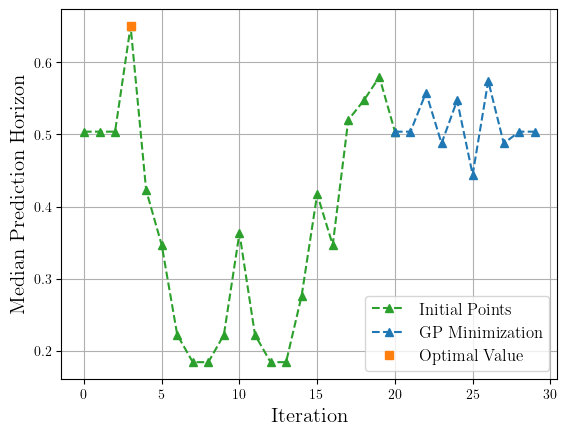

In [48]:
a = n_initial_points + len(x0)
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(func_iters.shape[0])

if a > 0:
    plt.plot(
        -func_iters[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, func_iters.shape[0])
plt.plot(
    xplot,
    -func_iters[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
plt.plot([optim_idx], [-func_iters[optim_idx]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Median Prediction Horizon', fontsize=15)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_rnn_plots+'/median_PH.pdf', bbox_inches='tight', dpi=300)
plt.show()

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

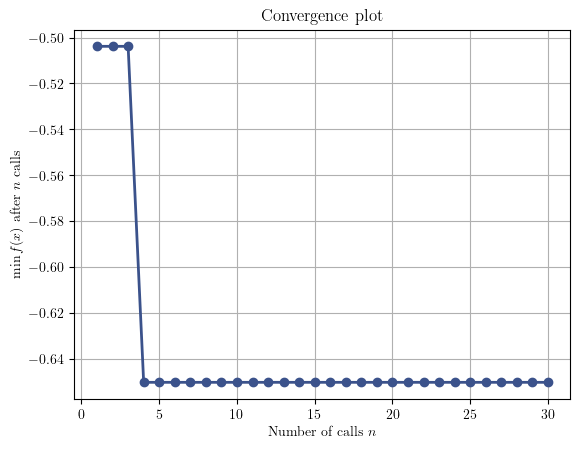

In [49]:
from skopt.plots import plot_convergence
plot_convergence(res)

In [50]:
optimized_vals_dict = {
    'x_iters':x_iters,
    'func_iters':func_iters,
    'optim_x':optim_x,
    'optim_idx':optim_idx,
    'optim_fun':func_iters[optim_idx]
}

with open(dir_name_rnn+'/optimized_vals.txt', 'w') as f:
    f.write(str(optimized_vals_dict))
    
np.savez(
    dir_name_rnn+'/optimized_vals',
    x_iters=x_iters,
    func_iters=func_iters,
    optim_x=optim_x,
    optim_idx=optim_idx,
    optim_fun=func_iters[optim_idx]
)

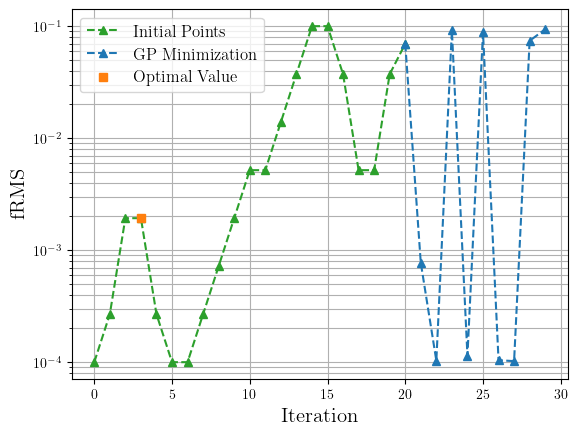

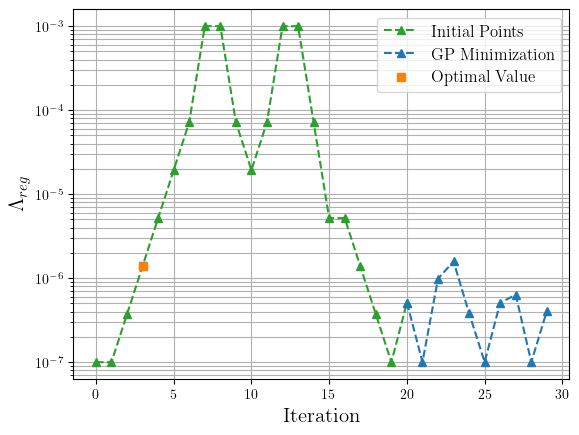

In [51]:
xoptim_names = [
    [r'fRMS', 'fRMS', plt.semilogy],
    [r'$\Lambda_{reg}$', 'lambda_reg', plt.semilogy],
]
if vary_zoneout == True:
    xoptim_names.append(
        [r'$p^{zoneout}$', 'zoneout', plt.plot]
    )

for i in range(len(xoptim_names)):
    a = n_initial_points + len(x0)
    # sorted_idx = np.argsort(x_iters[a:, 0])

    xplot = np.arange(x_iters.shape[0])
    if a > 0:
        xoptim_names[i][2](
            x_iters[:, i][0:a+1],
            linestyle='--',
            color='C2',
            marker='^',
            label='Initial Points',
        )
        xplot = np.arange(a, x_iters.shape[0])
    xoptim_names[i][2](
        xplot,
        x_iters[:, i][a:],
        linestyle='--',
        marker='^',
        label='GP Minimization',#'__nolegend__',
    )
    xoptim_names[i][2]([optim_idx], [x_iters[optim_idx, i]], 's', label='Optimal Value')

    plt.xlabel('Iteration', fontsize=15)
    plt.ylabel(xoptim_names[i][0], fontsize=15)
    plt.grid(True, which='major', axis='x')
    plt.grid(True, which='both', axis='y')
    plt.legend(fontsize=12)

    plt.savefig(dir_name_rnn_plots+'/'+xoptim_names[i][1]+'.pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [52]:
dir_list = os.listdir(dir_name_rnn+'/tested_rnn')
# dir_list

In [53]:
ph_mean_lst = []
for dir_name in dir_list:
    with np.load(dir_name_rnn+'/tested_rnn/'+dir_name+'/prediction_horizons-testingdata--combinedAERNN--ZEROoutsteps.npz') as f:
        ph_mean = np.mean(f['prediction_horizon_arr'])
        ph_mean_lst.append(ph_mean)
ph_mean_lst = np.array(ph_mean_lst)

In [54]:
idx = np.where(ph_mean_lst == ph_mean_lst.max())[0]

In [55]:
idx, dir_list[idx[0]]

(array([18]), 'test_rnn_003')

In [56]:
# convergence plot
convergence_f = np.empty_like(func_iters)
min_val = np.inf
for i in range(func_iters.shape[0]):
    if func_iters[i] < min_val:
        min_val = func_iters[i]
    convergence_f[i] = min_val

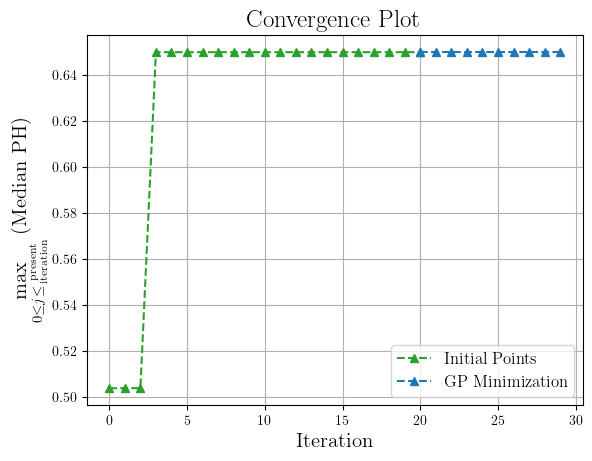

In [57]:
a = n_initial_points + len(x0)
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(x_iters.shape[0])

if a > 0:
    plt.plot(
        -convergence_f[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, x_iters.shape[0])
plt.plot(
    xplot,
    -convergence_f[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
# plt.semilogy([optim_idx], [func_iters[optim_idx, 0]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel(
#     r"$$\min_{0 \leq j \leq \mathrm{present \ iteration}} \left( \mathrm{Test \ MSE} \right)$$",
#     r"$$\min_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Test \ MSE} \right)$$",
    r"$$\max_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Median \ PH} \right)$$",
    fontsize=15,
)
plt.title('Convergence Plot', fontsize=18)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_rnn_plots+'/convergence_plot.pdf', bbox_inches='tight', dpi=300)
plt.show()

### Prediction horizon computation